**Chapter 11 – Deep Learning**

_This notebook contains all the sample code and solutions to the exercises in chapter 11._

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# Vanishing/Exploding Gradients Problem

In [2]:
def logit(z):
    return 1 / (1 + np.exp(-z))

Saving figure sigmoid_saturation_plot


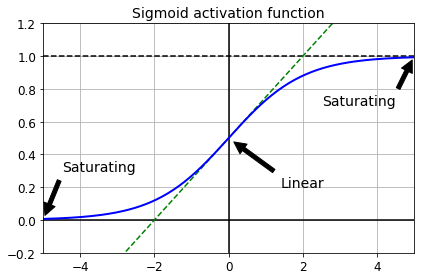

In [3]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("sigmoid_saturation_plot")
plt.show()

## Xavier and He Initialization

Note: the book uses `tensorflow.contrib.layers.fully_connected()` rather than `tf.layers.dense()` (which did not exist when this chapter was written). It is now preferable to use `tf.layers.dense()`, because anything in the contrib module may change or be deleted without notice. The `dense()` function is almost identical to the `fully_connected()` function. The main differences relevant to this chapter are:
* several parameters are renamed: `scope` becomes `name`, `activation_fn` becomes `activation` (and similarly the `_fn` suffix is removed from other parameters such as `normalizer_fn`), `weights_initializer` becomes `kernel_initializer`, etc.
* the default `activation` is now `None` rather than `tf.nn.relu`.
* it does not support `tensorflow.contrib.framework.arg_scope()` (introduced later in chapter 11).
* it does not support regularizer params (introduced later in chapter 11).

In [4]:
import tensorflow as tf

In [5]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [6]:
he_init = tf.variance_scaling_initializer()    # He Initialization
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                          kernel_initializer=he_init, name="hidden1")

## Nonsaturating Activation Functions

### Leaky ReLU

In [7]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

Saving figure leaky_relu_plot


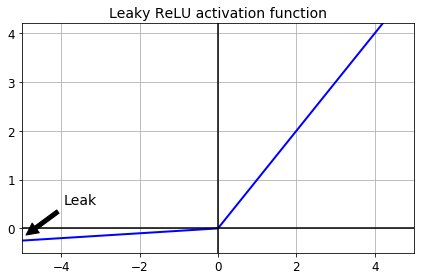

In [8]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

save_fig("leaky_relu_plot")
plt.show()

Implementing Leaky ReLU in TensorFlow:

In [9]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [10]:
def leaky_relu(z, name=None):
    return tf.maximum(0.01 * z, z, name=name)    # tensorflow 函数

hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")

Let's train a neural network on MNIST using the Leaky ReLU. First let's create the graph:

In [11]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

In [12]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [13]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=leaky_relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [14]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [15]:
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [16]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [17]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

Let's load the data:

**Warning**: `tf.examples.tutorials.mnist` is deprecated. We will use `tf.keras.datasets.mnist` instead.

In [18]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [19]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [20]:
n_epochs = 40
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 5 == 0:
            acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
            acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
            print(epoch, "Batch accuracy:", acc_batch, "Validation accuracy:", acc_valid)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Batch accuracy: 0.86 Validation accuracy: 0.904
5 Batch accuracy: 0.94 Validation accuracy: 0.9494
10 Batch accuracy: 0.92 Validation accuracy: 0.9656
15 Batch accuracy: 0.94 Validation accuracy: 0.9708
20 Batch accuracy: 1.0 Validation accuracy: 0.9762
25 Batch accuracy: 1.0 Validation accuracy: 0.9776
30 Batch accuracy: 0.98 Validation accuracy: 0.978
35 Batch accuracy: 1.0 Validation accuracy: 0.9788


### ELU

In [21]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)    # np.where

Saving figure elu_plot


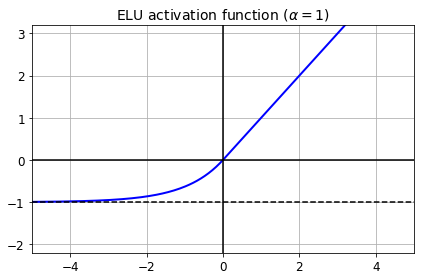

In [22]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("elu_plot")
plt.show()

Implementing ELU in TensorFlow is trivial, just specify the activation function when building each layer:

In [23]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [24]:
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.elu, name="hidden1")

### SELU

This activation function was proposed in this [great paper](https://arxiv.org/pdf/1706.02515.pdf) by Günter Klambauer, Thomas Unterthiner and Andreas Mayr, published in June 2017 (I will definitely add it to the book). During training, a neural network composed of a stack of dense layers using the SELU activation function will self-normalize: the output of each layer will tend to preserve the same mean and variance during training, which solves the vanishing/exploding gradients problem. As a result, this activation function outperforms the other activation functions very significantly for such neural nets, so you should really try it out.

In [25]:
def selu(z,
         scale=1.0507009873554804934193349852946,
         alpha=1.6732632423543772848170429916717):
    return scale * elu(z, alpha)

Saving figure selu_plot


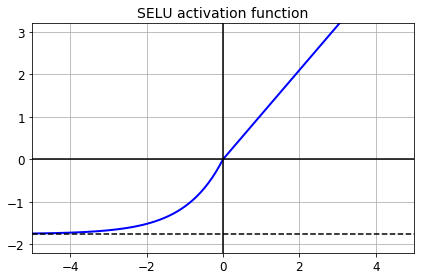

In [26]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("selu_plot")
plt.show()

By default, the SELU hyperparameters (`scale` and `alpha`) are tuned in such a way that the mean remains close to 0, and the standard deviation remains close to 1 (assuming the inputs are standardized with mean 0 and standard deviation 1 too). Using this activation function, even a 100 layer deep neural network preserves roughly mean 0 and standard deviation 1 across all layers, avoiding the exploding/vanishing gradients problem:

In [27]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100))
for layer in range(100):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1/100))   # forward pass 取 Var(Y) = 100 * Var(w) * Var(x)
    Z = selu(np.dot(Z, W))      # 激活值符合高斯分布，与BN不同，BN作用于输入值
    means = np.mean(Z, axis=1)  # 同层神经元输出的均值，而非单个神经元axis=0，不同于he_init保持单个输出N(0,1)
    stds = np.std(Z, axis=1)    # layer normalization
    if layer % 10 == 0:
        print("Layer {}: {:.2f} < mean < {:.2f}, {:.2f} < std deviation < {:.2f}".format(
            layer, means.min(), means.max(), stds.min(), stds.max()))

Layer 0: -0.26 < mean < 0.27, 0.74 < std deviation < 1.27
Layer 10: -0.24 < mean < 0.27, 0.74 < std deviation < 1.27
Layer 20: -0.17 < mean < 0.18, 0.74 < std deviation < 1.24
Layer 30: -0.27 < mean < 0.24, 0.78 < std deviation < 1.20
Layer 40: -0.38 < mean < 0.39, 0.74 < std deviation < 1.25
Layer 50: -0.27 < mean < 0.31, 0.73 < std deviation < 1.27
Layer 60: -0.26 < mean < 0.43, 0.74 < std deviation < 1.35
Layer 70: -0.19 < mean < 0.21, 0.75 < std deviation < 1.21
Layer 80: -0.18 < mean < 0.16, 0.72 < std deviation < 1.19
Layer 90: -0.19 < mean < 0.16, 0.75 < std deviation < 1.20


The `tf.nn.selu()` function was added in TensorFlow 1.4. For earlier versions, you can use the following implementation:

In [28]:
def selu(z,
         scale=1.0507009873554804934193349852946,
         alpha=1.6732632423543772848170429916717):
    return scale * tf.where(z >= 0.0, z, alpha * tf.nn.elu(z))    # elu函数内默认alpha==1.0

However, the SELU activation function cannot be used along with regular Dropout (this would cancel the SELU activation function's self-normalizing property). Fortunately, there is a Dropout variant called Alpha Dropout proposed in the same paper. It is available in `tf.contrib.nn.alpha_dropout()` since TF 1.4 (or check out [this implementation](https://github.com/bioinf-jku/SNNs/blob/master/selu.py) by the Institute of Bioinformatics, Johannes Kepler University Linz).

Let's create a neural net for MNIST using the SELU activation function:

In [29]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=selu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=selu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()
n_epochs = 40
batch_size = 50

Now let's train it. Do not forget to scale the inputs to mean 0 and standard deviation 1:

In [30]:
means = X_train.mean(axis=0, keepdims=True)
stds = X_train.std(axis=0, keepdims=True) + 1e-10
X_val_scaled = (X_valid - means) / stds

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            X_batch_scaled = (X_batch - means) / stds
            sess.run(training_op, feed_dict={X: X_batch_scaled, y: y_batch})
        if epoch % 5 == 0:
            acc_batch = accuracy.eval(feed_dict={X: X_batch_scaled, y: y_batch})
            acc_valid = accuracy.eval(feed_dict={X: X_val_scaled, y: y_valid})
            print(epoch, "Batch accuracy:", acc_batch, "Validation accuracy:", acc_valid)

    save_path = saver.save(sess, "./my_model_final_selu.ckpt")

0 Batch accuracy: 0.88 Validation accuracy: 0.9232
5 Batch accuracy: 0.98 Validation accuracy: 0.9576
10 Batch accuracy: 1.0 Validation accuracy: 0.9664
15 Batch accuracy: 0.96 Validation accuracy: 0.9684
20 Batch accuracy: 1.0 Validation accuracy: 0.9692
25 Batch accuracy: 1.0 Validation accuracy: 0.9688
30 Batch accuracy: 1.0 Validation accuracy: 0.9694
35 Batch accuracy: 1.0 Validation accuracy: 0.9698


# Batch Normalization

Note: the book uses `tensorflow.contrib.layers.batch_norm()` rather than `tf.layers.batch_normalization()` (which did not exist when this chapter was written). It is now preferable to use `tf.layers.batch_normalization()`, because anything in the contrib module may change or be deleted without notice. Instead of using the `batch_norm()` function as a regularizer parameter to the `fully_connected()` function, we now use `batch_normalization()` and we explicitly create a distinct layer. The parameters are a bit different, in particular:
* `decay` is renamed to `momentum`,
* `is_training` is renamed to `training`,
* `updates_collections` is removed: the update operations needed by batch normalization are added to the `UPDATE_OPS` collection and you need to explicity run these operations during training (see the execution phase below),
* we don't need to specify `scale=True`, as that is the default.

Also note that in order to run batch norm just _before_ each hidden layer's activation function, we apply the ELU activation function manually, right after the batch norm layer.

Note: since the `tf.layers.dense()` function is incompatible with `tf.contrib.layers.arg_scope()` (which is used in the book), we now use python's `functools.partial()` function instead. It makes it easy to create a `my_dense_layer()` function that just calls `tf.layers.dense()` with the desired parameters automatically set (unless they are overridden when calling `my_dense_layer()`). As you can see, the code remains very similar.

In [31]:
reset_graph()

import tensorflow as tf

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

training = tf.placeholder_with_default(False, shape=(), name='training')    # default

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = tf.layers.batch_normalization(hidden1, training=training, momentum=0.9)
bn1_act = tf.nn.elu(bn1)

hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = tf.layers.batch_normalization(hidden2, training=training, momentum=0.9)
bn2_act = tf.nn.elu(bn2)

logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = tf.layers.batch_normalization(logits_before_bn, training=training,
                                       momentum=0.9)

In [32]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
training = tf.placeholder_with_default(False, shape=(), name='training')

To avoid repeating the same parameters over and over again, we can use Python's `partial()` function:

In [33]:
from functools import partial

my_batch_norm_layer = partial(tf.layers.batch_normalization,
                              training=training, momentum=0.9)    # 保持部分默认值

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = my_batch_norm_layer(hidden1)
bn1_act = tf.nn.elu(bn1)
hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = my_batch_norm_layer(hidden2)
bn2_act = tf.nn.elu(bn2)
logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = my_batch_norm_layer(logits_before_bn)

Let's build a neural net for MNIST, using the ELU activation function and Batch Normalization at each layer:

In [34]:
reset_graph()

batch_norm_momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")
training = tf.placeholder_with_default(False, shape=(), name='training')

with tf.name_scope("dnn"):
    he_init = tf.variance_scaling_initializer()

    my_batch_norm_layer = partial(
            tf.layers.batch_normalization,
            training=training,
            momentum=batch_norm_momentum)

    my_dense_layer = partial(
            tf.layers.dense,
            kernel_initializer=he_init)

    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    bn1 = tf.nn.elu(my_batch_norm_layer(hidden1))
    hidden2 = my_dense_layer(bn1, n_hidden2, name="hidden2")
    bn2 = tf.nn.elu(my_batch_norm_layer(hidden2))
    logits_before_bn = my_dense_layer(bn2, n_outputs, name="outputs")
    logits = my_batch_norm_layer(logits_before_bn)    # 可以加BN

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

Note: since we are using `tf.layers.batch_normalization()` rather than `tf.contrib.layers.batch_norm()` (as in the book), we need to explicitly run the extra update operations needed by batch normalization (`sess.run([training_op, extra_update_ops],...`).

In [35]:
n_epochs = 20
batch_size = 200

In [36]:
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run([training_op, extra_update_ops],
                     feed_dict={training: True, X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.9042
1 Validation accuracy: 0.928
2 Validation accuracy: 0.9374
3 Validation accuracy: 0.9474
4 Validation accuracy: 0.9532
5 Validation accuracy: 0.9572
6 Validation accuracy: 0.9626
7 Validation accuracy: 0.9628
8 Validation accuracy: 0.9664
9 Validation accuracy: 0.968
10 Validation accuracy: 0.9694
11 Validation accuracy: 0.9696
12 Validation accuracy: 0.971
13 Validation accuracy: 0.971
14 Validation accuracy: 0.9728
15 Validation accuracy: 0.9734
16 Validation accuracy: 0.9728
17 Validation accuracy: 0.975
18 Validation accuracy: 0.9752
19 Validation accuracy: 0.976


What!? That's not a great accuracy for MNIST. Of course, if you train for longer it will get much better accuracy, but with such a shallow network, Batch Norm and ELU are unlikely to have very positive impact: they shine mostly for much deeper nets.

Note that you could also make the training operation depend on the update operations:

```python
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(extra_update_ops):
        training_op = optimizer.minimize(loss)
```

This way, you would just have to evaluate the `training_op` during training, TensorFlow would automatically run the update operations as well:

```python
sess.run(training_op, feed_dict={training: True, X: X_batch, y: y_batch})
```

One more thing: notice that the list of trainable variables is shorter than the list of all global variables. This is because the moving averages are non-trainable variables. If you want to reuse a pretrained neural network (see below), you must not forget these non-trainable variables.

In [37]:
[v.name for v in tf.trainable_variables()]

['hidden1/kernel:0',
 'hidden1/bias:0',
 'batch_normalization/gamma:0',
 'batch_normalization/beta:0',
 'hidden2/kernel:0',
 'hidden2/bias:0',
 'batch_normalization_1/gamma:0',
 'batch_normalization_1/beta:0',
 'outputs/kernel:0',
 'outputs/bias:0',
 'batch_normalization_2/gamma:0',
 'batch_normalization_2/beta:0']

In [38]:
[v.name for v in tf.global_variables()]

['hidden1/kernel:0',
 'hidden1/bias:0',
 'batch_normalization/gamma:0',
 'batch_normalization/beta:0',
 'batch_normalization/moving_mean:0',
 'batch_normalization/moving_variance:0',
 'hidden2/kernel:0',
 'hidden2/bias:0',
 'batch_normalization_1/gamma:0',
 'batch_normalization_1/beta:0',
 'batch_normalization_1/moving_mean:0',
 'batch_normalization_1/moving_variance:0',
 'outputs/kernel:0',
 'outputs/bias:0',
 'batch_normalization_2/gamma:0',
 'batch_normalization_2/beta:0',
 'batch_normalization_2/moving_mean:0',
 'batch_normalization_2/moving_variance:0']

## Gradient Clipping

Let's create a simple neural net for MNIST and add gradient clipping. The first part is the same as earlier (except we added a few more layers to demonstrate reusing pretrained models, see below):

In [39]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_hidden5 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [40]:
learning_rate = 0.01

Now we apply gradient clipping. For this, we need to get the gradients, use the `clip_by_value()` function to clip them, then apply them:

In [41]:
threshold = 1.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)    # minimize == (compute_gradients, apply_gradients)
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var)
              for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs)

In [42]:
grads_and_vars

[(<tf.Tensor 'gradients/dnn/hidden1/MatMul_grad/tuple/control_dependency_1:0' shape=(784, 300) dtype=float32>,
  <tf.Variable 'hidden1/kernel:0' shape=(784, 300) dtype=float32_ref>),
 (<tf.Tensor 'gradients/dnn/hidden1/BiasAdd_grad/tuple/control_dependency_1:0' shape=(300,) dtype=float32>,
  <tf.Variable 'hidden1/bias:0' shape=(300,) dtype=float32_ref>),
 (<tf.Tensor 'gradients/dnn/hidden2/MatMul_grad/tuple/control_dependency_1:0' shape=(300, 50) dtype=float32>,
  <tf.Variable 'hidden2/kernel:0' shape=(300, 50) dtype=float32_ref>),
 (<tf.Tensor 'gradients/dnn/hidden2/BiasAdd_grad/tuple/control_dependency_1:0' shape=(50,) dtype=float32>,
  <tf.Variable 'hidden2/bias:0' shape=(50,) dtype=float32_ref>),
 (<tf.Tensor 'gradients/dnn/hidden3/MatMul_grad/tuple/control_dependency_1:0' shape=(50, 50) dtype=float32>,
  <tf.Variable 'hidden3/kernel:0' shape=(50, 50) dtype=float32_ref>),
 (<tf.Tensor 'gradients/dnn/hidden3/BiasAdd_grad/tuple/control_dependency_1:0' shape=(50,) dtype=float32>,
  <t

The rest is the same as usual:

In [43]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [44]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [45]:
n_epochs = 20
batch_size = 200

In [46]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.288
1 Validation accuracy: 0.794
2 Validation accuracy: 0.8798
3 Validation accuracy: 0.906
4 Validation accuracy: 0.9164
5 Validation accuracy: 0.9214
6 Validation accuracy: 0.9292
7 Validation accuracy: 0.9358
8 Validation accuracy: 0.938
9 Validation accuracy: 0.9416
10 Validation accuracy: 0.946
11 Validation accuracy: 0.9472
12 Validation accuracy: 0.9476
13 Validation accuracy: 0.9532
14 Validation accuracy: 0.9564
15 Validation accuracy: 0.9566
16 Validation accuracy: 0.9576
17 Validation accuracy: 0.9588
18 Validation accuracy: 0.9624
19 Validation accuracy: 0.9616


## Reusing Pretrained Layers

## Reusing a TensorFlow Model

First you need to load the graph's structure. The `import_meta_graph()` function does just that, loading the graph's operations into the default graph, and returning a `Saver` that you can then use to restore the model's state. Note that by default, a `Saver` saves the structure of the graph into a `.meta` file, so that's the file you should load:

In [47]:
reset_graph()

In [48]:
saver = tf.train.import_meta_graph("./my_model_final.ckpt.meta")

Next you need to get a handle on all the operations you will need for training. If you don't know the graph's structure, you can list all the operations:

In [49]:
for op in tf.get_default_graph().get_operations():
    print(op.name)

X
y
hidden1/kernel/Initializer/random_uniform/shape
hidden1/kernel/Initializer/random_uniform/min
hidden1/kernel/Initializer/random_uniform/max
hidden1/kernel/Initializer/random_uniform/RandomUniform
hidden1/kernel/Initializer/random_uniform/sub
hidden1/kernel/Initializer/random_uniform/mul
hidden1/kernel/Initializer/random_uniform
hidden1/kernel
hidden1/kernel/Assign
hidden1/kernel/read
hidden1/bias/Initializer/zeros
hidden1/bias
hidden1/bias/Assign
hidden1/bias/read
dnn/hidden1/MatMul
dnn/hidden1/BiasAdd
dnn/hidden1/Relu
hidden2/kernel/Initializer/random_uniform/shape
hidden2/kernel/Initializer/random_uniform/min
hidden2/kernel/Initializer/random_uniform/max
hidden2/kernel/Initializer/random_uniform/RandomUniform
hidden2/kernel/Initializer/random_uniform/sub
hidden2/kernel/Initializer/random_uniform/mul
hidden2/kernel/Initializer/random_uniform
hidden2/kernel
hidden2/kernel/Assign
hidden2/kernel/read
hidden2/bias/Initializer/zeros
hidden2/bias
hidden2/bias/Assign
hidden2/bias/read
dn

Oops, that's a lot of operations! It's much easier to use TensorBoard to visualize the graph. The following hack will allow you to visualize the graph within Jupyter (if it does not work with your browser, you will need to use a `FileWriter` to save the graph and then visualize it in TensorBoard):

In [50]:
from tensorflow_graph_in_jupyter import show_graph

In [51]:
show_graph(tf.get_default_graph())

Once you know which operations you need, you can get a handle on them using the graph's `get_operation_by_name()` or `get_tensor_by_name()` methods:

In [52]:
X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

accuracy = tf.get_default_graph().get_tensor_by_name("eval/accuracy:0")

training_op = tf.get_default_graph().get_operation_by_name("GradientDescent")

If you are the author of the original model, you could make things easier for people who will reuse your model by giving operations very clear names and documenting them. Another approach is to create a collection containing all the important operations that people will want to get a handle on:

In [53]:
for op in (X, y, accuracy, training_op):
    tf.add_to_collection("my_important_ops", op)

This way people who reuse your model will be able to simply write:

In [54]:
X, y, accuracy, training_op = tf.get_collection("my_important_ops")

Now you can start a session, restore the model's state and continue training on your data:

In [55]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")
    # continue training the model...

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt


Actually, let's test this for real!

In [56]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")    

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.9634
1 Validation accuracy: 0.9632
2 Validation accuracy: 0.9654
3 Validation accuracy: 0.965
4 Validation accuracy: 0.9642
5 Validation accuracy: 0.9648
6 Validation accuracy: 0.9688
7 Validation accuracy: 0.9682
8 Validation accuracy: 0.9682
9 Validation accuracy: 0.9686
10 Validation accuracy: 0.9704
11 Validation accuracy: 0.9716
12 Validation accuracy: 0.967
13 Validation accuracy: 0.9698
14 Validation accuracy: 0.971
15 Validation accuracy: 0.972
16 Validation accuracy: 0.9722
17 Validation accuracy: 0.9712
18 Validation accuracy: 0.9712
19 Validation accuracy: 0.9716


Alternatively, if you have access to the Python code that built the original graph, you can use it instead of `import_meta_graph()`:

In [57]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01
threshold = 1.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var)
              for grad, var in grads_and_vars]    # 截断了梯度
training_op = optimizer.apply_gradients(capped_gvs)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

And continue training:

In [58]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")    

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.9642
1 Validation accuracy: 0.963
2 Validation accuracy: 0.9656
3 Validation accuracy: 0.9656
4 Validation accuracy: 0.9642
5 Validation accuracy: 0.965
6 Validation accuracy: 0.9688
7 Validation accuracy: 0.9684
8 Validation accuracy: 0.968
9 Validation accuracy: 0.9684
10 Validation accuracy: 0.9704
11 Validation accuracy: 0.9714
12 Validation accuracy: 0.967
13 Validation accuracy: 0.97
14 Validation accuracy: 0.9708
15 Validation accuracy: 0.9722
16 Validation accuracy: 0.9718
17 Validation accuracy: 0.9712
18 Validation accuracy: 0.9712
19 Validation accuracy: 0.9716


In general you will want to reuse only the lower layers. If you are using `import_meta_graph()` it will load the whole graph, but you can simply ignore the parts you do not need. In this example, we add a new 4th hidden layer on top of the pretrained 3rd layer (ignoring the old 4th hidden layer). We also build a new output layer, the loss for this new output, and a new optimizer to minimize it. We also need another saver to save the whole graph (containing both the entire old graph plus the new operations), and an initialization operation to initialize all the new variables:

In [59]:
reset_graph()

n_hidden4 = 20  # new layer
n_outputs = 10  # new layer

saver = tf.train.import_meta_graph("./my_model_final.ckpt.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

hidden3 = tf.get_default_graph().get_tensor_by_name("dnn/hidden4/Relu:0")

new_hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="new_hidden4")
new_logits = tf.layers.dense(new_hidden4, n_outputs, name="new_outputs")

with tf.name_scope("new_loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=new_logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("new_eval"):
    correct = tf.nn.in_top_k(new_logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("new_train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)    # 没有gradient clipping

init = tf.global_variables_initializer()
new_saver = tf.train.Saver()

In [60]:
tf.get_default_graph().get_operations()

[<tf.Operation 'X' type=Placeholder>,
 <tf.Operation 'y' type=Placeholder>,
 <tf.Operation 'hidden1/kernel/Initializer/random_uniform/shape' type=Const>,
 <tf.Operation 'hidden1/kernel/Initializer/random_uniform/min' type=Const>,
 <tf.Operation 'hidden1/kernel/Initializer/random_uniform/max' type=Const>,
 <tf.Operation 'hidden1/kernel/Initializer/random_uniform/RandomUniform' type=RandomUniform>,
 <tf.Operation 'hidden1/kernel/Initializer/random_uniform/sub' type=Sub>,
 <tf.Operation 'hidden1/kernel/Initializer/random_uniform/mul' type=Mul>,
 <tf.Operation 'hidden1/kernel/Initializer/random_uniform' type=Add>,
 <tf.Operation 'hidden1/kernel' type=VariableV2>,
 <tf.Operation 'hidden1/kernel/Assign' type=Assign>,
 <tf.Operation 'hidden1/kernel/read' type=Identity>,
 <tf.Operation 'hidden1/bias/Initializer/zeros' type=Const>,
 <tf.Operation 'hidden1/bias' type=VariableV2>,
 <tf.Operation 'hidden1/bias/Assign' type=Assign>,
 <tf.Operation 'hidden1/bias/read' type=Identity>,
 <tf.Operation 

In [61]:
show_graph(tf.get_default_graph())

And we can train this new model:

In [62]:
with tf.Session() as sess:
    init.run()
    saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = new_saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.9374
1 Validation accuracy: 0.952
2 Validation accuracy: 0.9564
3 Validation accuracy: 0.958
4 Validation accuracy: 0.9574
5 Validation accuracy: 0.9586
6 Validation accuracy: 0.9606
7 Validation accuracy: 0.964
8 Validation accuracy: 0.9644
9 Validation accuracy: 0.9632
10 Validation accuracy: 0.9634
11 Validation accuracy: 0.965
12 Validation accuracy: 0.9616
13 Validation accuracy: 0.966
14 Validation accuracy: 0.9676
15 Validation accuracy: 0.968
16 Validation accuracy: 0.9694
17 Validation accuracy: 0.9672
18 Validation accuracy: 0.97
19 Validation accuracy: 0.9672


If you have access to the Python code that built the original graph, you can just reuse the parts you need and drop the rest:

In [63]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")       # reused
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2") # reused
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3") # reused
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs")                         # new!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

However, you must create one `Saver` to restore the pretrained model (giving it the list of variables to restore, or else it will complain that the graphs don't match), and another `Saver` to save the new model, once it is trained:

In [64]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # regular expression
restore_saver = tf.train.Saver(reuse_vars) # to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):                                            # not shown in the book
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size): # not shown
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})        # not shown
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})     # not shown
        print(epoch, "Validation accuracy:", accuracy_val)                   # not shown

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.9026
1 Validation accuracy: 0.9332
2 Validation accuracy: 0.9428
3 Validation accuracy: 0.947
4 Validation accuracy: 0.952
5 Validation accuracy: 0.9532
6 Validation accuracy: 0.9556
7 Validation accuracy: 0.9588
8 Validation accuracy: 0.9588
9 Validation accuracy: 0.9606
10 Validation accuracy: 0.9622
11 Validation accuracy: 0.9622
12 Validation accuracy: 0.9638
13 Validation accuracy: 0.9662
14 Validation accuracy: 0.9664
15 Validation accuracy: 0.966
16 Validation accuracy: 0.9672
17 Validation accuracy: 0.9674
18 Validation accuracy: 0.9682
19 Validation accuracy: 0.9672


## Reusing Models from Other Frameworks

In this example, for each variable we want to reuse, we find its initializer's assignment operation, and we get its second input, which corresponds to the initialization value. When we run the initializer, we replace the initialization values with the ones we want, using a `feed_dict`:

In [65]:
reset_graph()

n_inputs = 2
n_hidden1 = 3

In [66]:
original_w = [[1., 2., 3.], [4., 5., 6.]] # Load the weights from the other framework
original_b = [7., 8., 9.]                 # Load the biases from the other framework

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
# [...] Build the rest of the model

# Get a handle on the assignment nodes for the hidden1 variables
graph = tf.get_default_graph()
assign_kernel = graph.get_operation_by_name("hidden1/kernel/Assign")
assign_bias = graph.get_operation_by_name("hidden1/bias/Assign")
init_kernel = assign_kernel.inputs[1]
init_bias = assign_bias.inputs[1]

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init, feed_dict={init_kernel: original_w, init_bias: original_b})
    # [...] Train the model on your new task
    print(hidden1.eval(feed_dict={X: [[10.0, 11.0]]}))  # not shown in the book

[[ 61.  83. 105.]]


Note: the weights variable created by the `tf.layers.dense()` function is called `"kernel"` (instead of `"weights"` when using the `tf.contrib.layers.fully_connected()`, as in the book), and the biases variable is called `bias` instead of `biases`.

Another approach (initially used in the book) would be to create dedicated assignment nodes and dedicated placeholders. This is more verbose and less efficient, but you may find this more explicit:

In [67]:
reset_graph()

n_inputs = 2
n_hidden1 = 3

original_w = [[1., 2., 3.], [4., 5., 6.]] # Load the weights from the other framework
original_b = [7., 8., 9.]                 # Load the biases from the other framework

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
# [...] Build the rest of the model

# Get a handle on the variables of layer hidden1
with tf.variable_scope("", default_name="", reuse=True):  # root scope
    hidden1_weights = tf.get_variable("hidden1/kernel")
    hidden1_biases = tf.get_variable("hidden1/bias")

# Create dedicated placeholders and assignment nodes
original_weights = tf.placeholder(tf.float32, shape=(n_inputs, n_hidden1))
original_biases = tf.placeholder(tf.float32, shape=n_hidden1)
assign_hidden1_weights = tf.assign(hidden1_weights, original_weights)
assign_hidden1_biases = tf.assign(hidden1_biases, original_biases)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    sess.run(assign_hidden1_weights, feed_dict={original_weights: original_w})
    sess.run(assign_hidden1_biases, feed_dict={original_biases: original_b})
    # [...] Train the model on your new task
    print(hidden1.eval(feed_dict={X: [[10.0, 11.0]]}))

[[ 61.  83. 105.]]


Note that we could also get a handle on the variables using `get_collection()` and specifying the `scope`:

In [68]:
tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="hidden1")

[<tf.Variable 'hidden1/kernel:0' shape=(2, 3) dtype=float32_ref>,
 <tf.Variable 'hidden1/bias:0' shape=(3,) dtype=float32_ref>]

Or we could use the graph's `get_tensor_by_name()` method:

In [69]:
tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")

<tf.Tensor 'hidden1/kernel:0' shape=(2, 3) dtype=float32_ref>

In [70]:
tf.get_default_graph().get_tensor_by_name("hidden1/bias:0")

<tf.Tensor 'hidden1/bias:0' shape=(3,) dtype=float32_ref>

### Freezing the Lower Layers

In [71]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")       # reused
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2") # reused
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3") # reused
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs")                         # new!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [72]:
with tf.name_scope("train"):                                         # not shown in the book
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)     # not shown
    train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                   scope="hidden[34]|outputs")
    training_op = optimizer.minimize(loss, var_list=train_vars)      # get_collection得到变量列表，可传给Saver,minimize作为参数变量

In [73]:
init = tf.global_variables_initializer()
new_saver = tf.train.Saver()

In [74]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # regular expression
restore_saver = tf.train.Saver(reuse_vars) # to restore layers 1-3，跟前一个get_collection相区别

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.8966
1 Validation accuracy: 0.9302
2 Validation accuracy: 0.9402
3 Validation accuracy: 0.9442
4 Validation accuracy: 0.9482
5 Validation accuracy: 0.9506
6 Validation accuracy: 0.951
7 Validation accuracy: 0.9536
8 Validation accuracy: 0.9554
9 Validation accuracy: 0.9564
10 Validation accuracy: 0.9562
11 Validation accuracy: 0.957
12 Validation accuracy: 0.9568
13 Validation accuracy: 0.9578
14 Validation accuracy: 0.9588
15 Validation accuracy: 0.958
16 Validation accuracy: 0.9576
17 Validation accuracy: 0.9602
18 Validation accuracy: 0.9594
19 Validation accuracy: 0.9602


In [75]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [76]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              name="hidden1") # reused frozen
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              name="hidden2") # reused frozen
    hidden2_stop = tf.stop_gradient(hidden2)
    hidden3 = tf.layers.dense(hidden2_stop, n_hidden3, activation=tf.nn.relu,
                              name="hidden3") # reused, not frozen
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu,
                              name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs") # new!

In [77]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

The training code is exactly the same as earlier:

In [78]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # regular expression
restore_saver = tf.train.Saver(reuse_vars) # to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.9018
1 Validation accuracy: 0.9304
2 Validation accuracy: 0.9436
3 Validation accuracy: 0.9476
4 Validation accuracy: 0.9512
5 Validation accuracy: 0.9524
6 Validation accuracy: 0.9526
7 Validation accuracy: 0.9558
8 Validation accuracy: 0.9552
9 Validation accuracy: 0.9558
10 Validation accuracy: 0.957
11 Validation accuracy: 0.9552
12 Validation accuracy: 0.9576
13 Validation accuracy: 0.9578
14 Validation accuracy: 0.9584
15 Validation accuracy: 0.9576
16 Validation accuracy: 0.9566
17 Validation accuracy: 0.9578
18 Validation accuracy: 0.9592
19 Validation accuracy: 0.9582


### Caching the Frozen Layers

In [79]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              name="hidden1") # reused frozen
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              name="hidden2") # reused frozen & cached
    hidden2_stop = tf.stop_gradient(hidden2)
    hidden3 = tf.layers.dense(hidden2_stop, n_hidden3, activation=tf.nn.relu,
                              name="hidden3") # reused, not frozen
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu,
                              name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs") # new!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [80]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # regular expression
restore_saver = tf.train.Saver(reuse_vars) # to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [81]:
import numpy as np

n_batches = len(X_train) // batch_size

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")
    
    h2_cache = sess.run(hidden2, feed_dict={X: X_train})
    h2_cache_valid = sess.run(hidden2, feed_dict={X: X_valid}) # not shown in the book

    for epoch in range(n_epochs):
        shuffled_idx = np.random.permutation(len(X_train))
        hidden2_batches = np.array_split(h2_cache[shuffled_idx], n_batches)
        y_batches = np.array_split(y_train[shuffled_idx], n_batches)
        for hidden2_batch, y_batch in zip(hidden2_batches, y_batches):
            sess.run(training_op, feed_dict={hidden2:hidden2_batch, y:y_batch})

        accuracy_val = accuracy.eval(feed_dict={hidden2: h2_cache_valid, # not shown
                                                y: y_valid})             # not shown
        print(epoch, "Validation accuracy:", accuracy_val)               # not shown

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.9018
1 Validation accuracy: 0.9304
2 Validation accuracy: 0.9436
3 Validation accuracy: 0.9476
4 Validation accuracy: 0.9512
5 Validation accuracy: 0.9524
6 Validation accuracy: 0.9526
7 Validation accuracy: 0.9558
8 Validation accuracy: 0.9552
9 Validation accuracy: 0.9558
10 Validation accuracy: 0.957
11 Validation accuracy: 0.9552
12 Validation accuracy: 0.9576
13 Validation accuracy: 0.9578
14 Validation accuracy: 0.9584
15 Validation accuracy: 0.9576
16 Validation accuracy: 0.9566
17 Validation accuracy: 0.9578
18 Validation accuracy: 0.9592
19 Validation accuracy: 0.9582


# Faster Optimizers

## Momentum optimization

In [82]:
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                       momentum=0.9)

## Nesterov Accelerated Gradient

In [83]:
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                       momentum=0.9, use_nesterov=True)

## AdaGrad

In [84]:
optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)

## RMSProp

In [85]:
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate,
                                      momentum=0.9, decay=0.9, epsilon=1e-10)

## Adam Optimization

In [86]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

## Learning Rate Scheduling

In [87]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [88]:
with tf.name_scope("train"):       # not shown in the book
    initial_learning_rate = 0.1
    decay_steps = 10000
    decay_rate = 1/10
    global_step = tf.Variable(0, trainable=False, name="global_step")
    learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step,
                                               decay_steps, decay_rate)
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    training_op = optimizer.minimize(loss, global_step=global_step)

In [89]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [90]:
n_epochs = 5
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.961
1 Validation accuracy: 0.974
2 Validation accuracy: 0.9696
3 Validation accuracy: 0.9826
4 Validation accuracy: 0.9828


# Avoiding Overfitting Through Regularization

## $\ell_1$ and $\ell_2$ regularization

Let's implement $\ell_1$ regularization manually. First, we create the model, as usual (with just one hidden layer this time, for simplicity):

In [117]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    logits = tf.layers.dense(hidden1, n_outputs, name="outputs")

Next, we get a handle on the layer weights, and we compute the total loss, which is equal to the sum of the usual cross entropy loss and the $\ell_1$ loss (i.e., the absolute values of the weights):

In [118]:
W1 = tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")
W2 = tf.get_default_graph().get_tensor_by_name("outputs/kernel:0")

scale = 0.001 # l1 regularization hyperparameter

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                              logits=logits)
    base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")
    reg_losses = tf.reduce_sum(tf.abs(W1)) + tf.reduce_sum(tf.abs(W2))
    loss = tf.add(base_loss, scale * reg_losses, name="loss")

The rest is just as usual:

In [119]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [120]:
n_epochs = 20
batch_size = 200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.831
1 Validation accuracy: 0.871
2 Validation accuracy: 0.8838
3 Validation accuracy: 0.8934
4 Validation accuracy: 0.8966
5 Validation accuracy: 0.8988
6 Validation accuracy: 0.9016
7 Validation accuracy: 0.9044
8 Validation accuracy: 0.9058
9 Validation accuracy: 0.906
10 Validation accuracy: 0.9068
11 Validation accuracy: 0.9054
12 Validation accuracy: 0.907
13 Validation accuracy: 0.9084
14 Validation accuracy: 0.9088
15 Validation accuracy: 0.9064
16 Validation accuracy: 0.9066
17 Validation accuracy: 0.9066
18 Validation accuracy: 0.9066
19 Validation accuracy: 0.9052


Alternatively, we can pass a regularization function to the `tf.layers.dense()` function, which will use it to create operations that will compute the regularization loss, and it adds these operations to the collection of regularization losses. The beginning is the same as above:

In [121]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

Next, we will use Python's `partial()` function to avoid repeating the same arguments over and over again. Note that we set the `kernel_regularizer` argument:

In [122]:
scale = 0.001

In [123]:
my_dense_layer = partial(
    tf.layers.dense, activation=tf.nn.relu,
    kernel_regularizer=tf.contrib.layers.l1_regularizer(scale))  # scale == 0.001

with tf.name_scope("dnn"):
    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    hidden2 = my_dense_layer(hidden1, n_hidden2, name="hidden2")
    logits = my_dense_layer(hidden2, n_outputs, activation=None,
                            name="outputs")

Next we must add the regularization losses to the base loss:

In [124]:
with tf.name_scope("loss"):                                     # not shown in the book
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(  # not shown
        labels=y, logits=logits)                                # not shown
    base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")   # not shown
    reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    loss = tf.add_n([base_loss] + reg_losses, name="loss")

And the rest is the same as usual:

In [125]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [126]:
n_epochs = 20
batch_size = 200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")    # 两层精度更高了

0 Validation accuracy: 0.8274
1 Validation accuracy: 0.8766
2 Validation accuracy: 0.8952
3 Validation accuracy: 0.9016
4 Validation accuracy: 0.908
5 Validation accuracy: 0.9096
6 Validation accuracy: 0.9126
7 Validation accuracy: 0.9154
8 Validation accuracy: 0.9178
9 Validation accuracy: 0.919
10 Validation accuracy: 0.92
11 Validation accuracy: 0.9224
12 Validation accuracy: 0.9212
13 Validation accuracy: 0.9228
14 Validation accuracy: 0.9222
15 Validation accuracy: 0.9214
16 Validation accuracy: 0.9218
17 Validation accuracy: 0.9228
18 Validation accuracy: 0.9216
19 Validation accuracy: 0.9214


## Dropout

Note: the book uses `tf.contrib.layers.dropout()` rather than `tf.layers.dropout()` (which did not exist when this chapter was written). It is now preferable to use `tf.layers.dropout()`, because anything in the contrib module may change or be deleted without notice. The `tf.layers.dropout()` function is almost identical to the `tf.contrib.layers.dropout()` function, except for a few minor differences. Most importantly:
* you must specify the dropout rate (`rate`) rather than the keep probability (`keep_prob`), where `rate` is simply equal to `1 - keep_prob`,
* the `is_training` parameter is renamed to `training`.

In [101]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [102]:
training = tf.placeholder_with_default(False, shape=(), name='training')

dropout_rate = 0.5  # == 1 - keep_prob
X_drop = tf.layers.dropout(X, dropout_rate, training=training)

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X_drop, n_hidden1, activation=tf.nn.relu,
                              name="hidden1")
    hidden1_drop = tf.layers.dropout(hidden1, dropout_rate, training=training)
    hidden2 = tf.layers.dense(hidden1_drop, n_hidden2, activation=tf.nn.relu,
                              name="hidden2")
    hidden2_drop = tf.layers.dropout(hidden2, dropout_rate, training=training)
    logits = tf.layers.dense(hidden2_drop, n_outputs, name="outputs")

In [103]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [104]:
n_epochs = 20
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch, training: True})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.9264
1 Validation accuracy: 0.9446
2 Validation accuracy: 0.9498
3 Validation accuracy: 0.9572
4 Validation accuracy: 0.959
5 Validation accuracy: 0.9598
6 Validation accuracy: 0.9618
7 Validation accuracy: 0.968
8 Validation accuracy: 0.9672
9 Validation accuracy: 0.9704
10 Validation accuracy: 0.969
11 Validation accuracy: 0.9696
12 Validation accuracy: 0.97
13 Validation accuracy: 0.9696
14 Validation accuracy: 0.9718
15 Validation accuracy: 0.9692
16 Validation accuracy: 0.972
17 Validation accuracy: 0.9724
18 Validation accuracy: 0.9736
19 Validation accuracy: 0.973


## Max norm

Let's go back to a plain and simple neural net for MNIST with just 2 hidden layers:

In [105]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

learning_rate = 0.01
momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

Next, let's get a handle on the first hidden layer's weight and create an operation that will compute the clipped weights using the `clip_by_norm()` function. Then we create an assignment operation to assign the clipped weights to the weights variable:

In [106]:
threshold = 1.0
weights = tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")
clipped_weights = tf.clip_by_norm(weights, clip_norm=threshold, axes=1)
clip_weights = tf.assign(weights, clipped_weights)

We can do this as well for the second hidden layer:

In [107]:
weights2 = tf.get_default_graph().get_tensor_by_name("hidden2/kernel:0")
clipped_weights2 = tf.clip_by_norm(weights2, clip_norm=threshold, axes=1)
clip_weights2 = tf.assign(weights2, clipped_weights2)

Let's add an initializer and a saver:

In [108]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

And now we can train the model. It's pretty much as usual, except that right after running the `training_op`, we run the `clip_weights` and `clip_weights2` operations:

In [109]:
n_epochs = 20
batch_size = 50

In [110]:
with tf.Session() as sess:                                              # not shown in the book
    init.run()                                                          # not shown
    for epoch in range(n_epochs):                                       # not shown
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size): # not shown
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            clip_weights.eval()
            clip_weights2.eval()                                        # not shown
        acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})   # not shown
        print(epoch, "Validation accuracy:", acc_valid)                 # not shown

    save_path = saver.save(sess, "./my_model_final.ckpt")               # not shown

0 Validation accuracy: 0.9568
1 Validation accuracy: 0.9696
2 Validation accuracy: 0.972
3 Validation accuracy: 0.9772
4 Validation accuracy: 0.9776
5 Validation accuracy: 0.9772
6 Validation accuracy: 0.9818
7 Validation accuracy: 0.9808
8 Validation accuracy: 0.9796
9 Validation accuracy: 0.9824
10 Validation accuracy: 0.9822
11 Validation accuracy: 0.9848
12 Validation accuracy: 0.9826
13 Validation accuracy: 0.9832
14 Validation accuracy: 0.984
15 Validation accuracy: 0.9844
16 Validation accuracy: 0.984
17 Validation accuracy: 0.9838
18 Validation accuracy: 0.9842
19 Validation accuracy: 0.985


The implementation above is straightforward and it works fine, but it is a bit messy. A better approach is to define a `max_norm_regularizer()` function:

In [111]:
def max_norm_regularizer(threshold, axes=1, name="max_norm",
                         collection="max_norm"):
    def max_norm(weights):
        clipped = tf.clip_by_norm(weights, clip_norm=threshold, axes=axes)
        clip_weights = tf.assign(weights, clipped, name=name)
        tf.add_to_collection(collection, clip_weights)
        return None # there is no regularization loss term
    return max_norm

Then you can call this function to get a max norm regularizer (with the threshold you want). When you create a hidden layer, you can pass this regularizer to the `kernel_regularizer` argument:

In [112]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

learning_rate = 0.01
momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [113]:
max_norm_reg = max_norm_regularizer(threshold=1.0)

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              kernel_regularizer=max_norm_reg, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              kernel_regularizer=max_norm_reg, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [114]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()

Training is as usual, except you must run the weights clipping operations after each training operation:

In [115]:
n_epochs = 20
batch_size = 50

In [116]:
clip_all_weights = tf.get_collection("max_norm")

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            sess.run(clip_all_weights)
        acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid}) # not shown
        print(epoch, "Validation accuracy:", acc_valid)               # not shown

    save_path = saver.save(sess, "./my_model_final.ckpt")             # not shown

0 Validation accuracy: 0.9556
1 Validation accuracy: 0.9706
2 Validation accuracy: 0.968
3 Validation accuracy: 0.973
4 Validation accuracy: 0.9776
5 Validation accuracy: 0.975
6 Validation accuracy: 0.981
7 Validation accuracy: 0.98
8 Validation accuracy: 0.9834
9 Validation accuracy: 0.9816
10 Validation accuracy: 0.9816
11 Validation accuracy: 0.9828
12 Validation accuracy: 0.9826
13 Validation accuracy: 0.9828
14 Validation accuracy: 0.9828
15 Validation accuracy: 0.9836
16 Validation accuracy: 0.9834
17 Validation accuracy: 0.9834
18 Validation accuracy: 0.9828
19 Validation accuracy: 0.9838


# Exercise solutions

## 1. to 7.

See appendix A.

## 8. Deep Learning

### 8.1.

_Exercise: Build a DNN with five hidden layers of 100 neurons each, He initialization, and the ELU activation function._

We will need similar DNNs in the next exercises, so let's create a function to build this DNN:

In [177]:
he_init = tf.variance_scaling_initializer()

def dnn(inputs, n_hidden_layers=5, n_neurons=100, name=None,
        activation=tf.nn.elu, initializer=he_init):
    with tf.variable_scope(name, "dnn"):    # 如果name为None，variable_scope取dnn, 对于空字符串，variable_scope仍取""
        for layer in range(n_hidden_layers):
            inputs = tf.layers.dense(inputs, n_neurons, activation=activation,
                                     kernel_initializer=initializer,
                                     name="hidden%d" % (layer + 1))
        return inputs

In [178]:
n_inputs = 28 * 28 # MNIST
n_outputs = 5

reset_graph(seed=24)

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

dnn_outputs = dnn(X)

logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init, name="logits")
Y_proba = tf.nn.softmax(logits, name="Y_proba")

### 8.2.

_Exercise: Using Adam optimization and early stopping, try training it on MNIST but only on digits 0 to 4, as we will use transfer learning for digits 5 to 9 in the next exercise. You will need a softmax output layer with five neurons, and as always make sure to save checkpoints at regular intervals and save the final model so you can reuse it later._

Let's complete the graph with the cost function, the training op, and all the other usual components:

In [179]:
learning_rate = 0.01

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss, name="training_op")

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

init = tf.global_variables_initializer()
saver = tf.train.Saver()

Now let's create the training set, validation and test set (we need the validation set to implement early stopping):

In [180]:
X_train1 = X_train[y_train < 5]
y_train1 = y_train[y_train < 5]
X_valid1 = X_valid[y_valid < 5]
y_valid1 = y_valid[y_valid < 5]
X_test1 = X_test[y_test < 5]
y_test1 = y_test[y_test < 5]

In [181]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train1))
        for rnd_indices in np.array_split(rnd_idx, len(X_train1) // batch_size):
            X_batch, y_batch = X_train1[rnd_indices], y_train1[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid1, y: y_valid1})
        if loss_val < best_loss:    # early stopping
            save_path = saver.save(sess, "./my_mnist_model_0_to_4.ckpt")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    saver.restore(sess, "./my_mnist_model_0_to_4.ckpt")
    acc_test = accuracy.eval(feed_dict={X: X_test1, y: y_test1})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

0	Validation loss: 0.475630	Best loss: 0.475630	Accuracy: 85.65%
1	Validation loss: 0.096193	Best loss: 0.096193	Accuracy: 97.46%
2	Validation loss: 0.196349	Best loss: 0.096193	Accuracy: 97.22%
3	Validation loss: 0.233567	Best loss: 0.096193	Accuracy: 96.44%
4	Validation loss: 0.187783	Best loss: 0.096193	Accuracy: 97.11%
5	Validation loss: 0.153515	Best loss: 0.096193	Accuracy: 98.08%
6	Validation loss: 0.154153	Best loss: 0.096193	Accuracy: 96.52%
7	Validation loss: 0.256703	Best loss: 0.096193	Accuracy: 97.03%
8	Validation loss: 0.359683	Best loss: 0.096193	Accuracy: 89.37%
9	Validation loss: 0.087182	Best loss: 0.087182	Accuracy: 98.51%
10	Validation loss: 0.203452	Best loss: 0.087182	Accuracy: 96.79%
11	Validation loss: 0.116301	Best loss: 0.087182	Accuracy: 98.24%
12	Validation loss: 0.748438	Best loss: 0.087182	Accuracy: 68.02%
13	Validation loss: 0.617278	Best loss: 0.087182	Accuracy: 75.45%
14	Validation loss: 0.475085	Best loss: 0.087182	Accuracy: 77.87%
15	Validation loss: 

We get 98.05% accuracy on the test set. That's not too bad, but let's see if we can do better by tuning the hyperparameters.

### 8.3.

_Exercise: Tune the hyperparameters using cross-validation and see what precision you can achieve._

Let's create a `DNNClassifier` class, compatible with Scikit-Learn's `RandomizedSearchCV` class, to perform hyperparameter tuning. Here are the key points of this implementation:
* the `__init__()` method (constructor) does nothing more than create instance variables for each of the hyperparameters.
* the `fit()` method creates the graph, starts a session and trains the model:
  * it calls the `_build_graph()` method to build the graph (much lile the graph we defined earlier). Once this method is done creating the graph, it saves all the important operations as instance variables for easy access by other methods.
  * the `_dnn()` method builds the hidden layers, just like the `dnn()` function above, but also with support for batch normalization and dropout (for the next exercises).
  * if the `fit()` method is given a validation set (`X_valid` and `y_valid`), then it implements early stopping. This implementation does not save the best model to disk, but rather to memory: it uses the `_get_model_params()` method to get all the graph's variables and their values, and the `_restore_model_params()` method to restore the variable values (of the best model found). This trick helps speed up training.
  * After the `fit()` method has finished training the model, it keeps the session open so that predictions can be made quickly, without having to save a model to disk and restore it for every prediction. You can close the session by calling the `close_session()` method.
* the `predict_proba()` method uses the trained model to predict the class probabilities.
* the `predict()` method calls `predict_proba()` and returns the class with the highest probability, for each instance.

In [183]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.exceptions import NotFittedError

class DNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_hidden_layers=5, n_neurons=100, optimizer_class=tf.train.AdamOptimizer,
                 learning_rate=0.01, batch_size=20, activation=tf.nn.elu, initializer=he_init,
                 batch_norm_momentum=None, dropout_rate=None, random_state=None):
        """Initialize the DNNClassifier by simply storing all the hyperparameters."""
        self.n_hidden_layers = n_hidden_layers
        self.n_neurons = n_neurons
        self.optimizer_class = optimizer_class
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.activation = activation
        self.initializer = initializer
        self.batch_norm_momentum = batch_norm_momentum
        self.dropout_rate = dropout_rate
        self.random_state = random_state
        self._session = None

    def _dnn(self, inputs):
        """Build the hidden layers, with support for batch normalization and dropout."""
        for layer in range(self.n_hidden_layers):
            if self.dropout_rate:
                inputs = tf.layers.dropout(inputs, self.dropout_rate, training=self._training)  # dropout 加到输出
            inputs = tf.layers.dense(inputs, self.n_neurons,
                                     kernel_initializer=self.initializer,
                                     name="hidden%d" % (layer + 1))
            if self.batch_norm_momentum:
                inputs = tf.layers.batch_normalization(inputs, momentum=self.batch_norm_momentum,
                                                       training=self._training)    # BN 加到输入
            inputs = self.activation(inputs, name="hidden%d_out" % (layer + 1))
        return inputs

    def _build_graph(self, n_inputs, n_outputs):
        """Build the same model as earlier"""
        if self.random_state is not None:
            tf.set_random_seed(self.random_state)
            np.random.seed(self.random_state)

        X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
        y = tf.placeholder(tf.int32, shape=(None), name="y")

        if self.batch_norm_momentum or self.dropout_rate:
            self._training = tf.placeholder_with_default(False, shape=(), name='training')
        else:
            self._training = None

        dnn_outputs = self._dnn(X)

        logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init, name="logits")  
        # logits到softmax不加BN和dropout，但是可以加BN（见3BN节），dropout应该不可以加
        Y_proba = tf.nn.softmax(logits, name="Y_proba")

        xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                                  logits=logits)
        loss = tf.reduce_mean(xentropy, name="loss")

        optimizer = self.optimizer_class(learning_rate=self.learning_rate)
        training_op = optimizer.minimize(loss)

        correct = tf.nn.in_top_k(logits, y, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

        init = tf.global_variables_initializer()
        saver = tf.train.Saver()

        # Make the important operations available easily through instance variables
        self._X, self._y = X, y
        self._Y_proba, self._loss = Y_proba, loss
        self._training_op, self._accuracy = training_op, accuracy
        self._init, self._saver = init, saver

    def close_session(self):
        if self._session:
            self._session.close()

    def _get_model_params(self):
        """Get all variable values (used for early stopping, faster than saving to disk)"""
        with self._graph.as_default():
            gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
        return {gvar.op.name: value for gvar, value in zip(gvars, self._session.run(gvars))}

    def _restore_model_params(self, model_params):
        """Set all variables to the given values (for early stopping, faster than loading from disk)"""
        gvar_names = list(model_params.keys())
        assign_ops = {gvar_name: self._graph.get_operation_by_name(gvar_name + "/Assign")
                      for gvar_name in gvar_names}    # Assign操作符
        init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
        feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}  # 3.4节 assign.output[1]: new_value
        self._session.run(assign_ops, feed_dict=feed_dict)

    def fit(self, X, y, n_epochs=100, X_valid=None, y_valid=None):
        """Fit the model to the training set. If X_valid and y_valid are provided, use early stopping."""
        self.close_session()

        # infer n_inputs and n_outputs from the training set.
        n_inputs = X.shape[1] 
        self.classes_ = np.unique(y) # sorted
        n_outputs = len(self.classes_)
        
        # Translate the labels vector to a vector of sorted class indices, containing
        # integers from 0 to n_outputs - 1.
        # For example, if y is equal to [8, 8, 9, 5, 7, 6, 6, 6], then the sorted class
        # labels (self.classes_) will be equal to [5, 6, 7, 8, 9], and the labels vector
        # will be translated to [3, 3, 4, 0, 2, 1, 1, 1]
        self.class_to_index_ = {label: index
                                for index, label in enumerate(self.classes_)}
        y = np.array([self.class_to_index_[label]
                      for label in y], dtype=np.int32)  # np.int32
        
        self._graph = tf.Graph()
        with self._graph.as_default():
            self._build_graph(n_inputs, n_outputs)
            # extra ops for batch normalization
            extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

        # needed in case of early stopping
        max_checks_without_progress = 20
        checks_without_progress = 0
        best_loss = np.infty
        best_params = None
        
        # Now train the model!
        self._session = tf.Session(graph=self._graph)
        with self._session.as_default() as sess:
            self._init.run()
            for epoch in range(n_epochs):
                rnd_idx = np.random.permutation(len(X))
                for rnd_indices in np.array_split(rnd_idx, len(X) // self.batch_size):
                    X_batch, y_batch = X[rnd_indices], y[rnd_indices]
                    feed_dict = {self._X: X_batch, self._y: y_batch}
                    if self._training is not None:
                        feed_dict[self._training] = True
                    sess.run(self._training_op, feed_dict=feed_dict)
                    if extra_update_ops:
                        sess.run(extra_update_ops, feed_dict=feed_dict)
                if X_valid is not None and y_valid is not None:
                    loss_val, acc_val = sess.run([self._loss, self._accuracy],
                                                 feed_dict={self._X: X_valid,
                                                            self._y: y_valid})
                    if loss_val < best_loss:
                        best_params = self._get_model_params()
                        best_loss = loss_val
                        checks_without_progress = 0
                    else:
                        checks_without_progress += 1
                    print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
                        epoch, loss_val, best_loss, acc_val * 100))
                    if checks_without_progress > max_checks_without_progress:
                        print("Early stopping!")
                        break
                else:
                    loss_train, acc_train = sess.run([self._loss, self._accuracy],
                                                     feed_dict={self._X: X_batch,
                                                                self._y: y_batch})
                    print("{}\tLast training batch loss: {:.6f}\tAccuracy: {:.2f}%".format(
                        epoch, loss_train, acc_train * 100))
            # If we used early stopping then rollback to the best model found
            if best_params:
                self._restore_model_params(best_params)
            return self

    def predict_proba(self, X):
        if not self._session:
            raise NotFittedError("This %s instance is not fitted yet" % self.__class__.__name__)
        with self._session.as_default() as sess:
            return self._Y_proba.eval(feed_dict={self._X: X})    # 直接计算softmax值就可以

    def predict(self, X):
        class_indices = np.argmax(self.predict_proba(X), axis=1)
        return np.array([[self.classes_[class_index]]
                         for class_index in class_indices], np.int32)

    def save(self, path):
        self._saver.save(self._session, path)

Let's see if we get the exact same accuracy as earlier using this class (without dropout or batch norm):

In [185]:
dnn_clf = DNNClassifier(random_state=24)
dnn_clf.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	Validation loss: 0.475630	Best loss: 0.475630	Accuracy: 85.65%
1	Validation loss: 0.096193	Best loss: 0.096193	Accuracy: 97.46%
2	Validation loss: 0.196349	Best loss: 0.096193	Accuracy: 97.22%
3	Validation loss: 0.233567	Best loss: 0.096193	Accuracy: 96.44%
4	Validation loss: 0.187783	Best loss: 0.096193	Accuracy: 97.11%
5	Validation loss: 0.153515	Best loss: 0.096193	Accuracy: 98.08%
6	Validation loss: 0.154153	Best loss: 0.096193	Accuracy: 96.52%
7	Validation loss: 0.256703	Best loss: 0.096193	Accuracy: 97.03%
8	Validation loss: 0.359683	Best loss: 0.096193	Accuracy: 89.37%
9	Validation loss: 0.087182	Best loss: 0.087182	Accuracy: 98.51%
10	Validation loss: 0.203452	Best loss: 0.087182	Accuracy: 96.79%
11	Validation loss: 0.116301	Best loss: 0.087182	Accuracy: 98.24%
12	Validation loss: 0.748438	Best loss: 0.087182	Accuracy: 68.02%
13	Validation loss: 0.617278	Best loss: 0.087182	Accuracy: 75.45%
14	Validation loss: 0.475085	Best loss: 0.087182	Accuracy: 77.87%
15	Validation loss: 

DNNClassifier(activation=<function elu at 0x7fbb65d527b8>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7fb9d8b22630>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=24)

The model is trained, let's see if it gets the same accuracy as earlier:

In [186]:
from sklearn.metrics import accuracy_score

y_pred = dnn_clf.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9856003113446196

Yep! Working fine. Now we can use Scikit-Learn's `RandomizedSearchCV` class to search for better hyperparameters (this may take over an hour, depending on your system):

In [187]:
from sklearn.model_selection import RandomizedSearchCV

def leaky_relu(alpha=0.01):
    def parametrized_leaky_relu(z, name=None):
        return tf.maximum(alpha * z, z, name=name)
    return parametrized_leaky_relu

param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # you could also try exploring different numbers of hidden layers, different optimizers, etc.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
}

rnd_search = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
                                random_state=42, verbose=2)
rnd_search.fit(X_train1, y_train1, X_valid=X_valid1, y_valid=y_valid1, n_epochs=1000)

# If you have Scikit-Learn 0.18 or earlier, you should upgrade, or use the fit_params argument:
# fit_params={"X_valid": X_valid1, "y_valid": y_valid1, "n_epochs": 1000}
# rnd_search = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
#                                 fit_params=fit_params, random_state=42, verbose=2)
# rnd_search.fit(X_train1, y_train1)


Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] n_neurons=10, learning_rate=0.05, batch_size=100, activation=<function elu at 0x7fbb65d527b8> 
0	Validation loss: 0.151327	Best loss: 0.151327	Accuracy: 95.82%
1	Validation loss: 0.138895	Best loss: 0.138895	Accuracy: 96.52%
2	Validation loss: 0.106629	Best loss: 0.106629	Accuracy: 97.03%
3	Validation loss: 0.171158	Best loss: 0.106629	Accuracy: 95.54%
4	Validation loss: 0.190754	Best loss: 0.106629	Accuracy: 96.60%
5	Validation loss: 1.617532	Best loss: 0.106629	Accuracy: 22.01%
6	Validation loss: 1.632467	Best loss: 0.106629	Accuracy: 22.01%
7	Validation loss: 1.623779	Best loss: 0.106629	Accuracy: 22.01%
8	Validation loss: 1.616856	Best loss: 0.106629	Accuracy: 19.27%
9	Validation loss: 1.613470	Best loss: 0.106629	Accuracy: 22.01%
10	Validation loss: 1.612714	Best loss: 0.106629	Accuracy: 22.01%
11	Validation loss: 1.612307	Best loss: 0.106629	Accuracy: 18.73%
12	Validation loss: 1.620450	Best loss: 0.106629	Accurac

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.4s remaining:    0.0s


0	Validation loss: 0.153435	Best loss: 0.153435	Accuracy: 95.86%
1	Validation loss: 0.147326	Best loss: 0.147326	Accuracy: 96.68%
2	Validation loss: 0.123078	Best loss: 0.123078	Accuracy: 96.91%
3	Validation loss: 0.174345	Best loss: 0.123078	Accuracy: 95.93%
4	Validation loss: 0.258253	Best loss: 0.123078	Accuracy: 94.64%
5	Validation loss: 0.161568	Best loss: 0.123078	Accuracy: 95.97%
6	Validation loss: 0.134363	Best loss: 0.123078	Accuracy: 96.91%
7	Validation loss: 0.180485	Best loss: 0.123078	Accuracy: 96.33%
8	Validation loss: 0.126185	Best loss: 0.123078	Accuracy: 96.91%
9	Validation loss: 0.187337	Best loss: 0.123078	Accuracy: 95.27%
10	Validation loss: 0.158462	Best loss: 0.123078	Accuracy: 95.74%
11	Validation loss: 0.189778	Best loss: 0.123078	Accuracy: 94.37%
12	Validation loss: 1.425159	Best loss: 0.123078	Accuracy: 35.38%
13	Validation loss: 1.331579	Best loss: 0.123078	Accuracy: 34.25%
14	Validation loss: 0.997601	Best loss: 0.123078	Accuracy: 63.68%
15	Validation loss: 

[CV]  n_neurons=30, learning_rate=0.02, batch_size=500, activation=<function relu at 0x7fbb65cfbae8>, total=   6.8s
[CV] n_neurons=30, learning_rate=0.02, batch_size=500, activation=<function relu at 0x7fbb65cfbae8> 
0	Validation loss: 0.115925	Best loss: 0.115925	Accuracy: 96.36%
1	Validation loss: 0.076872	Best loss: 0.076872	Accuracy: 97.58%
2	Validation loss: 0.067116	Best loss: 0.067116	Accuracy: 98.01%
3	Validation loss: 0.058144	Best loss: 0.058144	Accuracy: 98.36%
4	Validation loss: 0.074453	Best loss: 0.058144	Accuracy: 98.16%
5	Validation loss: 0.054237	Best loss: 0.054237	Accuracy: 98.40%
6	Validation loss: 0.061965	Best loss: 0.054237	Accuracy: 98.48%
7	Validation loss: 0.089931	Best loss: 0.054237	Accuracy: 97.77%
8	Validation loss: 0.084550	Best loss: 0.054237	Accuracy: 97.93%
9	Validation loss: 0.064555	Best loss: 0.054237	Accuracy: 98.44%
10	Validation loss: 0.072397	Best loss: 0.054237	Accuracy: 98.51%
11	Validation loss: 0.065843	Best loss: 0.054237	Accuracy: 98.48%
1

28	Validation loss: 69.772995	Best loss: 0.643366	Accuracy: 57.90%
29	Validation loss: 15.532194	Best loss: 0.643366	Accuracy: 87.88%
Early stopping!
[CV]  n_neurons=90, learning_rate=0.05, batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fbb8c3430d0>, total=  27.8s
[CV] n_neurons=70, learning_rate=0.1, batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fba946fb730> 
0	Validation loss: 119.362137	Best loss: 119.362137	Accuracy: 75.25%
1	Validation loss: 109.005142	Best loss: 109.005142	Accuracy: 80.22%
2	Validation loss: 22.180744	Best loss: 22.180744	Accuracy: 93.55%
3	Validation loss: 12.606094	Best loss: 12.606094	Accuracy: 96.01%
4	Validation loss: 10.411256	Best loss: 10.411256	Accuracy: 96.29%
5	Validation loss: 23.647461	Best loss: 10.411256	Accuracy: 94.80%
6	Validation loss: 14.331949	Best loss: 10.411256	Accuracy: 94.18%
7	Validation loss: 13.649621	Best loss: 10.411256	Accuracy: 95.82%
8	Validation loss:

25	Validation loss: 0.056613	Best loss: 0.046317	Accuracy: 98.71%
26	Validation loss: 0.075654	Best loss: 0.046317	Accuracy: 98.32%
Early stopping!
[CV]  n_neurons=120, learning_rate=0.01, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fbb8c3430d0>, total=   9.6s
[CV] n_neurons=120, learning_rate=0.01, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fbb8c3430d0> 
0	Validation loss: 0.105041	Best loss: 0.105041	Accuracy: 96.79%
1	Validation loss: 0.068896	Best loss: 0.068896	Accuracy: 98.01%
2	Validation loss: 0.058891	Best loss: 0.058891	Accuracy: 98.12%
3	Validation loss: 0.061140	Best loss: 0.058891	Accuracy: 98.16%
4	Validation loss: 0.060419	Best loss: 0.058891	Accuracy: 98.32%
5	Validation loss: 0.049982	Best loss: 0.049982	Accuracy: 98.79%
6	Validation loss: 0.078211	Best loss: 0.049982	Accuracy: 98.08%
7	Validation loss: 0.090680	Best loss: 0.049982	Accuracy: 97.77%
8	Validation loss: 0.057556	Best lo

0	Validation loss: 0.096781	Best loss: 0.096781	Accuracy: 97.19%
1	Validation loss: 0.063260	Best loss: 0.063260	Accuracy: 98.08%
2	Validation loss: 0.050572	Best loss: 0.050572	Accuracy: 98.40%
3	Validation loss: 0.055273	Best loss: 0.050572	Accuracy: 98.40%
4	Validation loss: 0.058841	Best loss: 0.050572	Accuracy: 98.44%
5	Validation loss: 0.059766	Best loss: 0.050572	Accuracy: 98.44%
6	Validation loss: 0.066072	Best loss: 0.050572	Accuracy: 98.40%
7	Validation loss: 0.058829	Best loss: 0.050572	Accuracy: 98.32%
8	Validation loss: 0.047970	Best loss: 0.047970	Accuracy: 98.71%
9	Validation loss: 0.050747	Best loss: 0.047970	Accuracy: 98.67%
10	Validation loss: 0.041726	Best loss: 0.041726	Accuracy: 99.06%
11	Validation loss: 0.039226	Best loss: 0.039226	Accuracy: 98.98%
12	Validation loss: 0.058528	Best loss: 0.039226	Accuracy: 98.75%
13	Validation loss: 0.052645	Best loss: 0.039226	Accuracy: 98.94%
14	Validation loss: 0.050289	Best loss: 0.039226	Accuracy: 98.79%
15	Validation loss: 

0	Validation loss: 0.133312	Best loss: 0.133312	Accuracy: 95.70%
1	Validation loss: 0.081172	Best loss: 0.081172	Accuracy: 97.46%
2	Validation loss: 0.067674	Best loss: 0.067674	Accuracy: 97.89%
3	Validation loss: 0.058299	Best loss: 0.058299	Accuracy: 98.28%
4	Validation loss: 0.065549	Best loss: 0.058299	Accuracy: 98.08%
5	Validation loss: 0.056145	Best loss: 0.056145	Accuracy: 98.51%
6	Validation loss: 0.057569	Best loss: 0.056145	Accuracy: 98.48%
7	Validation loss: 0.051622	Best loss: 0.051622	Accuracy: 98.71%
8	Validation loss: 0.043165	Best loss: 0.043165	Accuracy: 98.67%
9	Validation loss: 0.062223	Best loss: 0.043165	Accuracy: 98.48%
10	Validation loss: 0.052627	Best loss: 0.043165	Accuracy: 98.71%
11	Validation loss: 0.060892	Best loss: 0.043165	Accuracy: 98.63%
12	Validation loss: 0.043075	Best loss: 0.043075	Accuracy: 99.02%
13	Validation loss: 0.047426	Best loss: 0.043075	Accuracy: 98.79%
14	Validation loss: 0.071114	Best loss: 0.043075	Accuracy: 98.59%
15	Validation loss: 

6	Validation loss: 1.635101	Best loss: 1.611657	Accuracy: 19.27%
7	Validation loss: 1.630914	Best loss: 1.611657	Accuracy: 18.73%
8	Validation loss: 1.639863	Best loss: 1.611657	Accuracy: 22.01%
9	Validation loss: 1.611894	Best loss: 1.611657	Accuracy: 20.91%
10	Validation loss: 1.613292	Best loss: 1.611657	Accuracy: 22.01%
11	Validation loss: 1.614465	Best loss: 1.611657	Accuracy: 22.01%
12	Validation loss: 1.615519	Best loss: 1.611657	Accuracy: 20.91%
13	Validation loss: 1.609593	Best loss: 1.609593	Accuracy: 22.01%
14	Validation loss: 1.628134	Best loss: 1.609593	Accuracy: 22.01%
15	Validation loss: 1.613723	Best loss: 1.609593	Accuracy: 19.08%
16	Validation loss: 1.621646	Best loss: 1.609593	Accuracy: 22.01%
17	Validation loss: 1.612428	Best loss: 1.609593	Accuracy: 19.08%
18	Validation loss: 1.622170	Best loss: 1.609593	Accuracy: 22.01%
19	Validation loss: 1.611825	Best loss: 1.609593	Accuracy: 22.01%
20	Validation loss: 1.612158	Best loss: 1.609593	Accuracy: 20.91%
21	Validation 

8	Validation loss: 0.067860	Best loss: 0.067860	Accuracy: 98.28%
9	Validation loss: 0.074092	Best loss: 0.067860	Accuracy: 98.16%
10	Validation loss: 0.131516	Best loss: 0.067860	Accuracy: 97.65%
11	Validation loss: 0.096573	Best loss: 0.067860	Accuracy: 97.65%
12	Validation loss: 0.076859	Best loss: 0.067860	Accuracy: 97.89%
13	Validation loss: 0.127441	Best loss: 0.067860	Accuracy: 97.85%
14	Validation loss: 0.074169	Best loss: 0.067860	Accuracy: 97.81%
15	Validation loss: 0.103513	Best loss: 0.067860	Accuracy: 97.46%
16	Validation loss: 0.081229	Best loss: 0.067860	Accuracy: 98.48%
17	Validation loss: 0.071363	Best loss: 0.067860	Accuracy: 98.08%
18	Validation loss: 0.076147	Best loss: 0.067860	Accuracy: 98.28%
19	Validation loss: 0.071301	Best loss: 0.067860	Accuracy: 98.32%
20	Validation loss: 0.101503	Best loss: 0.067860	Accuracy: 98.28%
21	Validation loss: 0.062775	Best loss: 0.062775	Accuracy: 98.44%
22	Validation loss: 0.070930	Best loss: 0.062775	Accuracy: 98.01%
23	Validatio

28	Validation loss: 0.078882	Best loss: 0.065427	Accuracy: 98.36%
Early stopping!
[CV]  n_neurons=30, learning_rate=0.02, batch_size=100, activation=<function relu at 0x7fbb65cfbae8>, total=  11.2s
[CV] n_neurons=50, learning_rate=0.05, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fbb8c3430d0> 
0	Validation loss: 0.161523	Best loss: 0.161523	Accuracy: 95.86%
1	Validation loss: 1.277997	Best loss: 0.161523	Accuracy: 50.94%
2	Validation loss: 0.508051	Best loss: 0.161523	Accuracy: 81.78%
3	Validation loss: 0.538966	Best loss: 0.161523	Accuracy: 80.57%
4	Validation loss: 0.226849	Best loss: 0.161523	Accuracy: 93.94%
5	Validation loss: 0.382326	Best loss: 0.161523	Accuracy: 94.68%
6	Validation loss: 0.345804	Best loss: 0.161523	Accuracy: 88.62%
7	Validation loss: 0.254717	Best loss: 0.161523	Accuracy: 92.73%
8	Validation loss: 0.266144	Best loss: 0.161523	Accuracy: 93.75%
9	Validation loss: 0.290741	Best loss: 0.161523	Accuracy: 94.29%
10	Validatio

0	Validation loss: 0.109189	Best loss: 0.109189	Accuracy: 96.79%
1	Validation loss: 0.097596	Best loss: 0.097596	Accuracy: 97.62%
2	Validation loss: 0.075723	Best loss: 0.075723	Accuracy: 97.93%
3	Validation loss: 0.069436	Best loss: 0.069436	Accuracy: 98.24%
4	Validation loss: 0.084673	Best loss: 0.069436	Accuracy: 98.12%
5	Validation loss: 0.075126	Best loss: 0.069436	Accuracy: 98.24%
6	Validation loss: 0.079478	Best loss: 0.069436	Accuracy: 98.16%
7	Validation loss: 0.467309	Best loss: 0.069436	Accuracy: 95.74%
8	Validation loss: 0.123405	Best loss: 0.069436	Accuracy: 96.91%
9	Validation loss: 0.120666	Best loss: 0.069436	Accuracy: 98.05%
10	Validation loss: 0.080823	Best loss: 0.069436	Accuracy: 97.73%
11	Validation loss: 0.156367	Best loss: 0.069436	Accuracy: 98.08%
12	Validation loss: 0.070226	Best loss: 0.069436	Accuracy: 98.24%
13	Validation loss: 0.067614	Best loss: 0.067614	Accuracy: 98.40%
14	Validation loss: 0.286996	Best loss: 0.067614	Accuracy: 94.80%
15	Validation loss: 

[CV]  n_neurons=120, learning_rate=0.02, batch_size=10, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fba946fb730>, total= 1.2min
[CV] n_neurons=120, learning_rate=0.02, batch_size=10, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fba946fb730> 
0	Validation loss: 0.377368	Best loss: 0.377368	Accuracy: 95.39%
1	Validation loss: 133.673050	Best loss: 0.377368	Accuracy: 95.23%
2	Validation loss: 63.417446	Best loss: 0.377368	Accuracy: 96.60%
3	Validation loss: 643.842957	Best loss: 0.377368	Accuracy: 92.73%
4	Validation loss: 54.359882	Best loss: 0.377368	Accuracy: 91.01%
5	Validation loss: 40.591412	Best loss: 0.377368	Accuracy: 94.96%
6	Validation loss: 886.443909	Best loss: 0.377368	Accuracy: 94.45%
7	Validation loss: 251.101791	Best loss: 0.377368	Accuracy: 93.12%
8	Validation loss: 349.635651	Best loss: 0.377368	Accuracy: 93.55%
9	Validation loss: 990.438538	Best loss: 0.377368	Accuracy: 94.68%
10	Validation loss: 424.234009	Best loss

0	Validation loss: 0.855156	Best loss: 0.855156	Accuracy: 83.70%
1	Validation loss: 0.211973	Best loss: 0.211973	Accuracy: 94.76%
2	Validation loss: 0.148612	Best loss: 0.148612	Accuracy: 95.93%
3	Validation loss: 0.138061	Best loss: 0.138061	Accuracy: 96.48%
4	Validation loss: 0.112382	Best loss: 0.112382	Accuracy: 96.95%
5	Validation loss: 0.134040	Best loss: 0.112382	Accuracy: 96.68%
6	Validation loss: 0.129024	Best loss: 0.112382	Accuracy: 96.83%
7	Validation loss: 0.124957	Best loss: 0.112382	Accuracy: 96.36%
8	Validation loss: 0.129940	Best loss: 0.112382	Accuracy: 96.83%
9	Validation loss: 0.098376	Best loss: 0.098376	Accuracy: 97.34%
10	Validation loss: 0.115158	Best loss: 0.098376	Accuracy: 97.03%
11	Validation loss: 0.106303	Best loss: 0.098376	Accuracy: 97.54%
12	Validation loss: 0.136009	Best loss: 0.098376	Accuracy: 96.60%
13	Validation loss: 0.112304	Best loss: 0.098376	Accuracy: 97.38%
14	Validation loss: 0.116851	Best loss: 0.098376	Accuracy: 97.42%
15	Validation loss: 

5	Validation loss: 0.164601	Best loss: 0.164601	Accuracy: 96.33%
6	Validation loss: 0.208523	Best loss: 0.164601	Accuracy: 94.29%
7	Validation loss: 0.170142	Best loss: 0.164601	Accuracy: 96.60%
8	Validation loss: 0.526970	Best loss: 0.164601	Accuracy: 96.01%
9	Validation loss: 47648.542969	Best loss: 0.164601	Accuracy: 80.34%
10	Validation loss: 10668.673828	Best loss: 0.164601	Accuracy: 85.85%
11	Validation loss: 5056.998047	Best loss: 0.164601	Accuracy: 86.98%
12	Validation loss: 2251.083496	Best loss: 0.164601	Accuracy: 92.03%
13	Validation loss: 2170.018066	Best loss: 0.164601	Accuracy: 91.71%
14	Validation loss: 1865.171631	Best loss: 0.164601	Accuracy: 93.43%
15	Validation loss: 1408.070923	Best loss: 0.164601	Accuracy: 90.42%
16	Validation loss: 1326.752686	Best loss: 0.164601	Accuracy: 93.08%
17	Validation loss: 1024.381592	Best loss: 0.164601	Accuracy: 95.04%
18	Validation loss: 1019.544189	Best loss: 0.164601	Accuracy: 93.00%
19	Validation loss: 1186.929688	Best loss: 0.1646

4	Validation loss: 2.013346	Best loss: 1.728383	Accuracy: 20.91%
5	Validation loss: 2.124150	Best loss: 1.728383	Accuracy: 19.27%
6	Validation loss: 1.798456	Best loss: 1.728383	Accuracy: 19.27%
7	Validation loss: 2.029032	Best loss: 1.728383	Accuracy: 19.08%
8	Validation loss: 2.358150	Best loss: 1.728383	Accuracy: 18.73%
9	Validation loss: 1.772399	Best loss: 1.728383	Accuracy: 19.27%
10	Validation loss: 2.146663	Best loss: 1.728383	Accuracy: 19.08%
11	Validation loss: 2.742457	Best loss: 1.728383	Accuracy: 22.01%
12	Validation loss: 2.148648	Best loss: 1.728383	Accuracy: 19.27%
13	Validation loss: 2.504805	Best loss: 1.728383	Accuracy: 19.27%
14	Validation loss: 2.295739	Best loss: 1.728383	Accuracy: 19.27%
15	Validation loss: 2.061067	Best loss: 1.728383	Accuracy: 18.73%
16	Validation loss: 1.657122	Best loss: 1.657122	Accuracy: 19.08%
17	Validation loss: 1.926883	Best loss: 1.657122	Accuracy: 18.73%
18	Validation loss: 1.868702	Best loss: 1.657122	Accuracy: 19.08%
19	Validation lo

7	Validation loss: 0.058099	Best loss: 0.047626	Accuracy: 98.44%
8	Validation loss: 0.099680	Best loss: 0.047626	Accuracy: 97.89%
9	Validation loss: 0.072081	Best loss: 0.047626	Accuracy: 98.28%
10	Validation loss: 0.065853	Best loss: 0.047626	Accuracy: 98.59%
11	Validation loss: 0.066767	Best loss: 0.047626	Accuracy: 98.71%
12	Validation loss: 0.056879	Best loss: 0.047626	Accuracy: 98.98%
13	Validation loss: 0.066323	Best loss: 0.047626	Accuracy: 98.59%
14	Validation loss: 0.086823	Best loss: 0.047626	Accuracy: 98.67%
15	Validation loss: 0.082439	Best loss: 0.047626	Accuracy: 98.48%
16	Validation loss: 0.067166	Best loss: 0.047626	Accuracy: 98.55%
17	Validation loss: 0.057441	Best loss: 0.047626	Accuracy: 98.75%
18	Validation loss: 0.070759	Best loss: 0.047626	Accuracy: 98.83%
19	Validation loss: 0.067760	Best loss: 0.047626	Accuracy: 98.91%
20	Validation loss: 0.078865	Best loss: 0.047626	Accuracy: 98.51%
21	Validation loss: 0.066000	Best loss: 0.047626	Accuracy: 98.79%
22	Validation

4	Validation loss: 1.078659	Best loss: 0.316921	Accuracy: 46.52%
5	Validation loss: 0.906257	Best loss: 0.316921	Accuracy: 53.52%
6	Validation loss: 0.888420	Best loss: 0.316921	Accuracy: 55.47%
7	Validation loss: 0.900282	Best loss: 0.316921	Accuracy: 56.29%
8	Validation loss: 0.903234	Best loss: 0.316921	Accuracy: 54.57%
9	Validation loss: 0.925973	Best loss: 0.316921	Accuracy: 53.83%
10	Validation loss: 0.831794	Best loss: 0.316921	Accuracy: 57.43%
11	Validation loss: 0.851574	Best loss: 0.316921	Accuracy: 56.53%
12	Validation loss: 0.947776	Best loss: 0.316921	Accuracy: 54.93%
13	Validation loss: 0.928273	Best loss: 0.316921	Accuracy: 52.27%
14	Validation loss: 0.902093	Best loss: 0.316921	Accuracy: 58.72%
15	Validation loss: 0.844719	Best loss: 0.316921	Accuracy: 62.47%
16	Validation loss: 0.762670	Best loss: 0.316921	Accuracy: 65.21%
17	Validation loss: 0.756291	Best loss: 0.316921	Accuracy: 64.66%
18	Validation loss: 0.808358	Best loss: 0.316921	Accuracy: 62.55%
19	Validation lo

7	Validation loss: 0.203361	Best loss: 0.116058	Accuracy: 93.94%
8	Validation loss: 0.175464	Best loss: 0.116058	Accuracy: 96.83%
9	Validation loss: 0.181356	Best loss: 0.116058	Accuracy: 95.97%
10	Validation loss: 0.208920	Best loss: 0.116058	Accuracy: 95.78%
11	Validation loss: 0.240579	Best loss: 0.116058	Accuracy: 95.86%
12	Validation loss: 0.373976	Best loss: 0.116058	Accuracy: 94.06%
13	Validation loss: 0.227727	Best loss: 0.116058	Accuracy: 94.64%
14	Validation loss: 0.351659	Best loss: 0.116058	Accuracy: 95.43%
15	Validation loss: 0.583175	Best loss: 0.116058	Accuracy: 73.65%
16	Validation loss: 0.610860	Best loss: 0.116058	Accuracy: 75.80%
17	Validation loss: 0.471677	Best loss: 0.116058	Accuracy: 78.19%
18	Validation loss: 0.518494	Best loss: 0.116058	Accuracy: 77.56%
19	Validation loss: 0.842130	Best loss: 0.116058	Accuracy: 56.25%
20	Validation loss: 0.628353	Best loss: 0.116058	Accuracy: 76.27%
21	Validation loss: 0.447021	Best loss: 0.116058	Accuracy: 76.15%
22	Validation

3	Validation loss: 0.852113	Best loss: 0.568966	Accuracy: 91.48%
4	Validation loss: 0.240633	Best loss: 0.240633	Accuracy: 96.01%
5	Validation loss: 0.191166	Best loss: 0.191166	Accuracy: 96.21%
6	Validation loss: 0.160739	Best loss: 0.160739	Accuracy: 96.76%
7	Validation loss: 0.165237	Best loss: 0.160739	Accuracy: 96.44%
8	Validation loss: 0.143974	Best loss: 0.143974	Accuracy: 96.72%
9	Validation loss: 0.120344	Best loss: 0.120344	Accuracy: 97.11%
10	Validation loss: 0.118947	Best loss: 0.118947	Accuracy: 97.34%
11	Validation loss: 0.106618	Best loss: 0.106618	Accuracy: 97.65%
12	Validation loss: 0.130422	Best loss: 0.106618	Accuracy: 97.03%
13	Validation loss: 0.107996	Best loss: 0.106618	Accuracy: 97.58%
14	Validation loss: 0.137350	Best loss: 0.106618	Accuracy: 96.21%
15	Validation loss: 0.097681	Best loss: 0.097681	Accuracy: 97.73%
16	Validation loss: 0.093752	Best loss: 0.093752	Accuracy: 97.65%
17	Validation loss: 0.098787	Best loss: 0.093752	Accuracy: 97.65%
18	Validation los

14	Validation loss: 0.850858	Best loss: 0.217463	Accuracy: 56.06%
15	Validation loss: 0.869909	Best loss: 0.217463	Accuracy: 71.03%
16	Validation loss: 0.870221	Best loss: 0.217463	Accuracy: 52.97%
17	Validation loss: 0.777032	Best loss: 0.217463	Accuracy: 72.56%
18	Validation loss: 0.561899	Best loss: 0.217463	Accuracy: 77.52%
19	Validation loss: 0.572022	Best loss: 0.217463	Accuracy: 77.37%
20	Validation loss: 0.592039	Best loss: 0.217463	Accuracy: 75.57%
21	Validation loss: 0.655844	Best loss: 0.217463	Accuracy: 76.04%
22	Validation loss: 1.439830	Best loss: 0.217463	Accuracy: 35.11%
23	Validation loss: 1.181018	Best loss: 0.217463	Accuracy: 39.33%
24	Validation loss: 1.163731	Best loss: 0.217463	Accuracy: 39.72%
25	Validation loss: 1.160909	Best loss: 0.217463	Accuracy: 40.11%
26	Validation loss: 1.148490	Best loss: 0.217463	Accuracy: 42.10%
27	Validation loss: 1.179271	Best loss: 0.217463	Accuracy: 40.19%
Early stopping!
[CV]  n_neurons=10, learning_rate=0.05, batch_size=100, acti

4	Validation loss: 0.098351	Best loss: 0.098351	Accuracy: 96.95%
5	Validation loss: 0.099833	Best loss: 0.098351	Accuracy: 97.15%
6	Validation loss: 0.124006	Best loss: 0.098351	Accuracy: 96.09%
7	Validation loss: 0.099166	Best loss: 0.098351	Accuracy: 97.19%
8	Validation loss: 0.096065	Best loss: 0.096065	Accuracy: 97.11%
9	Validation loss: 0.095624	Best loss: 0.095624	Accuracy: 97.30%
10	Validation loss: 0.092122	Best loss: 0.092122	Accuracy: 97.30%
11	Validation loss: 0.094856	Best loss: 0.092122	Accuracy: 97.38%
12	Validation loss: 0.095563	Best loss: 0.092122	Accuracy: 97.30%
13	Validation loss: 0.090044	Best loss: 0.090044	Accuracy: 97.81%
14	Validation loss: 0.096387	Best loss: 0.090044	Accuracy: 97.77%
15	Validation loss: 0.089944	Best loss: 0.089944	Accuracy: 97.54%
16	Validation loss: 0.093119	Best loss: 0.089944	Accuracy: 97.73%
17	Validation loss: 0.095931	Best loss: 0.089944	Accuracy: 97.50%
18	Validation loss: 0.095436	Best loss: 0.089944	Accuracy: 98.01%
19	Validation lo

27	Validation loss: 1.662118	Best loss: 0.057761	Accuracy: 18.73%
28	Validation loss: 1.649794	Best loss: 0.057761	Accuracy: 19.27%
Early stopping!
[CV]  n_neurons=70, learning_rate=0.02, batch_size=100, activation=<function elu at 0x7fbb65d527b8>, total=  13.9s
[CV] n_neurons=30, learning_rate=0.02, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fba946fb730> 
0	Validation loss: 0.115102	Best loss: 0.115102	Accuracy: 96.76%
1	Validation loss: 0.104229	Best loss: 0.104229	Accuracy: 97.50%
2	Validation loss: 0.088050	Best loss: 0.088050	Accuracy: 97.85%
3	Validation loss: 0.090298	Best loss: 0.088050	Accuracy: 98.08%
4	Validation loss: 0.112466	Best loss: 0.088050	Accuracy: 97.65%
5	Validation loss: 1.365009	Best loss: 0.088050	Accuracy: 95.39%
6	Validation loss: 0.188467	Best loss: 0.088050	Accuracy: 96.64%
7	Validation loss: 0.201271	Best loss: 0.088050	Accuracy: 96.72%
8	Validation loss: 0.137662	Best loss: 0.088050	Accuracy: 97.11%
9	Validation

34	Validation loss: 2.538164	Best loss: 1.792857	Accuracy: 20.91%
35	Validation loss: 2.718445	Best loss: 1.792857	Accuracy: 19.27%
36	Validation loss: 3.791663	Best loss: 1.792857	Accuracy: 22.01%
37	Validation loss: 1.783586	Best loss: 1.783586	Accuracy: 20.91%
38	Validation loss: 1.971561	Best loss: 1.783586	Accuracy: 22.01%
39	Validation loss: 3.912920	Best loss: 1.783586	Accuracy: 19.27%
40	Validation loss: 2.874421	Best loss: 1.783586	Accuracy: 18.73%
41	Validation loss: 2.702598	Best loss: 1.783586	Accuracy: 19.27%
42	Validation loss: 2.143730	Best loss: 1.783586	Accuracy: 19.27%
43	Validation loss: 3.701835	Best loss: 1.783586	Accuracy: 22.01%
44	Validation loss: 4.467383	Best loss: 1.783586	Accuracy: 19.08%
45	Validation loss: 2.943161	Best loss: 1.783586	Accuracy: 18.73%
46	Validation loss: 2.675368	Best loss: 1.783586	Accuracy: 18.73%
47	Validation loss: 2.855207	Best loss: 1.783586	Accuracy: 22.01%
48	Validation loss: 2.665429	Best loss: 1.783586	Accuracy: 18.73%
49	Validat

21	Validation loss: 1.683504	Best loss: 1.611045	Accuracy: 22.01%
22	Validation loss: 1.676853	Best loss: 1.611045	Accuracy: 19.27%
23	Validation loss: 1.660796	Best loss: 1.611045	Accuracy: 19.27%
24	Validation loss: 1.714126	Best loss: 1.611045	Accuracy: 18.73%
25	Validation loss: 1.769712	Best loss: 1.611045	Accuracy: 22.01%
26	Validation loss: 1.792799	Best loss: 1.611045	Accuracy: 19.08%
27	Validation loss: 1.905071	Best loss: 1.611045	Accuracy: 19.27%
28	Validation loss: 1.885515	Best loss: 1.611045	Accuracy: 22.01%
29	Validation loss: 1.671128	Best loss: 1.611045	Accuracy: 18.73%
30	Validation loss: 1.732357	Best loss: 1.611045	Accuracy: 19.08%
31	Validation loss: 1.645509	Best loss: 1.611045	Accuracy: 19.27%
32	Validation loss: 1.805384	Best loss: 1.611045	Accuracy: 18.73%
33	Validation loss: 1.976463	Best loss: 1.611045	Accuracy: 22.01%
34	Validation loss: 1.686584	Best loss: 1.611045	Accuracy: 22.01%
Early stopping!
[CV]  n_neurons=90, learning_rate=0.1, batch_size=100, activ

7	Validation loss: 0.131659	Best loss: 0.125099	Accuracy: 95.93%
8	Validation loss: 0.116020	Best loss: 0.116020	Accuracy: 96.44%
9	Validation loss: 0.122793	Best loss: 0.116020	Accuracy: 96.36%
10	Validation loss: 0.165179	Best loss: 0.116020	Accuracy: 94.92%
11	Validation loss: 0.109804	Best loss: 0.109804	Accuracy: 96.60%
12	Validation loss: 0.133087	Best loss: 0.109804	Accuracy: 96.64%
13	Validation loss: 0.127552	Best loss: 0.109804	Accuracy: 96.60%
14	Validation loss: 0.121713	Best loss: 0.109804	Accuracy: 96.72%
15	Validation loss: 51.719391	Best loss: 0.109804	Accuracy: 32.33%
16	Validation loss: 3313.759277	Best loss: 0.109804	Accuracy: 18.73%
17	Validation loss: 1716.505127	Best loss: 0.109804	Accuracy: 36.47%
18	Validation loss: 629.106567	Best loss: 0.109804	Accuracy: 49.61%
19	Validation loss: 52.297901	Best loss: 0.109804	Accuracy: 56.53%
20	Validation loss: 21.349789	Best loss: 0.109804	Accuracy: 55.32%
21	Validation loss: 18.948975	Best loss: 0.109804	Accuracy: 56.76%
2

12	Validation loss: 0.064889	Best loss: 0.054015	Accuracy: 98.36%
13	Validation loss: 0.052553	Best loss: 0.052553	Accuracy: 98.71%
14	Validation loss: 0.054598	Best loss: 0.052553	Accuracy: 98.63%
15	Validation loss: 0.068075	Best loss: 0.052553	Accuracy: 98.55%
16	Validation loss: 0.063706	Best loss: 0.052553	Accuracy: 98.67%
17	Validation loss: 0.051459	Best loss: 0.051459	Accuracy: 98.40%
18	Validation loss: 0.059084	Best loss: 0.051459	Accuracy: 98.75%
19	Validation loss: 0.051985	Best loss: 0.051459	Accuracy: 98.83%
20	Validation loss: 0.067402	Best loss: 0.051459	Accuracy: 98.71%
21	Validation loss: 0.094417	Best loss: 0.051459	Accuracy: 98.48%
22	Validation loss: 0.076043	Best loss: 0.051459	Accuracy: 98.48%
23	Validation loss: 952.447937	Best loss: 0.051459	Accuracy: 20.91%
24	Validation loss: 2.276787	Best loss: 0.051459	Accuracy: 19.27%
25	Validation loss: 1.659623	Best loss: 0.051459	Accuracy: 22.01%
26	Validation loss: 1.614310	Best loss: 0.051459	Accuracy: 22.01%
27	Valid

12	Validation loss: 0.062847	Best loss: 0.044537	Accuracy: 98.79%
13	Validation loss: 0.054733	Best loss: 0.044537	Accuracy: 98.71%
14	Validation loss: 0.066872	Best loss: 0.044537	Accuracy: 98.87%
15	Validation loss: 0.086099	Best loss: 0.044537	Accuracy: 98.20%
16	Validation loss: 0.086510	Best loss: 0.044537	Accuracy: 98.32%
17	Validation loss: 0.098107	Best loss: 0.044537	Accuracy: 98.01%
18	Validation loss: 0.082122	Best loss: 0.044537	Accuracy: 98.48%
19	Validation loss: 0.077609	Best loss: 0.044537	Accuracy: 97.93%
20	Validation loss: 0.098811	Best loss: 0.044537	Accuracy: 98.55%
21	Validation loss: 0.057949	Best loss: 0.044537	Accuracy: 98.59%
22	Validation loss: 0.085870	Best loss: 0.044537	Accuracy: 98.67%
23	Validation loss: 0.089118	Best loss: 0.044537	Accuracy: 98.40%
24	Validation loss: 0.065317	Best loss: 0.044537	Accuracy: 98.71%
25	Validation loss: 0.069973	Best loss: 0.044537	Accuracy: 98.63%
26	Validation loss: 0.067319	Best loss: 0.044537	Accuracy: 98.71%
27	Validat

1	Validation loss: 0.105638	Best loss: 0.105638	Accuracy: 97.11%
2	Validation loss: 0.091638	Best loss: 0.091638	Accuracy: 97.15%
3	Validation loss: 0.088444	Best loss: 0.088444	Accuracy: 97.46%
4	Validation loss: 0.090872	Best loss: 0.088444	Accuracy: 97.15%
5	Validation loss: 0.096567	Best loss: 0.088444	Accuracy: 96.79%
6	Validation loss: 0.069030	Best loss: 0.069030	Accuracy: 97.73%
7	Validation loss: 0.090520	Best loss: 0.069030	Accuracy: 97.46%
8	Validation loss: 0.080209	Best loss: 0.069030	Accuracy: 97.65%
9	Validation loss: 0.087958	Best loss: 0.069030	Accuracy: 97.97%
10	Validation loss: 0.072463	Best loss: 0.069030	Accuracy: 97.85%
11	Validation loss: 0.084440	Best loss: 0.069030	Accuracy: 97.65%
12	Validation loss: 0.064761	Best loss: 0.064761	Accuracy: 98.08%
13	Validation loss: 0.080550	Best loss: 0.064761	Accuracy: 97.85%
14	Validation loss: 0.069548	Best loss: 0.064761	Accuracy: 98.28%
15	Validation loss: 0.076501	Best loss: 0.064761	Accuracy: 98.20%
16	Validation loss:

21	Validation loss: 0.138695	Best loss: 0.083735	Accuracy: 98.01%
22	Validation loss: 0.165629	Best loss: 0.083735	Accuracy: 97.62%
23	Validation loss: 0.186557	Best loss: 0.083735	Accuracy: 97.85%
Early stopping!
[CV]  n_neurons=70, learning_rate=0.02, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fba946fb730>, total=  13.8s
[CV] n_neurons=70, learning_rate=0.02, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fba946fb730> 
0	Validation loss: 0.165737	Best loss: 0.165737	Accuracy: 96.33%
1	Validation loss: 0.783349	Best loss: 0.165737	Accuracy: 93.43%
2	Validation loss: 0.135247	Best loss: 0.135247	Accuracy: 96.36%
3	Validation loss: 0.143065	Best loss: 0.135247	Accuracy: 96.36%
4	Validation loss: 0.187056	Best loss: 0.135247	Accuracy: 95.97%
5	Validation loss: 0.109622	Best loss: 0.109622	Accuracy: 97.38%
6	Validation loss: 0.113884	Best loss: 0.109622	Accuracy: 97.62%
7	Validation loss: 0.122477	Best los

0	Validation loss: 2390.868896	Best loss: 2390.868896	Accuracy: 79.63%
1	Validation loss: 554.413086	Best loss: 554.413086	Accuracy: 90.70%
2	Validation loss: 146.069000	Best loss: 146.069000	Accuracy: 95.93%
3	Validation loss: 425.387024	Best loss: 146.069000	Accuracy: 86.20%
4	Validation loss: 158.506042	Best loss: 146.069000	Accuracy: 94.45%
5	Validation loss: 327.045715	Best loss: 146.069000	Accuracy: 91.83%
6	Validation loss: 416.224060	Best loss: 146.069000	Accuracy: 93.78%
7	Validation loss: 298.778381	Best loss: 146.069000	Accuracy: 96.99%
8	Validation loss: 348.986176	Best loss: 146.069000	Accuracy: 94.64%
9	Validation loss: 98.006172	Best loss: 98.006172	Accuracy: 94.96%
10	Validation loss: 78.533653	Best loss: 78.533653	Accuracy: 96.05%
11	Validation loss: 60.311756	Best loss: 60.311756	Accuracy: 95.27%
12	Validation loss: 91.985504	Best loss: 60.311756	Accuracy: 92.03%
13	Validation loss: 95.758682	Best loss: 60.311756	Accuracy: 95.43%
14	Validation loss: 87.888756	Best los

6	Validation loss: 0.092890	Best loss: 0.079634	Accuracy: 97.93%
7	Validation loss: 0.087090	Best loss: 0.079634	Accuracy: 97.58%
8	Validation loss: 0.068849	Best loss: 0.068849	Accuracy: 98.01%
9	Validation loss: 0.087295	Best loss: 0.068849	Accuracy: 97.81%
10	Validation loss: 0.080306	Best loss: 0.068849	Accuracy: 98.20%
11	Validation loss: 0.074598	Best loss: 0.068849	Accuracy: 98.12%
12	Validation loss: 0.093363	Best loss: 0.068849	Accuracy: 97.89%
13	Validation loss: 0.086328	Best loss: 0.068849	Accuracy: 97.89%
14	Validation loss: 0.086443	Best loss: 0.068849	Accuracy: 98.32%
15	Validation loss: 0.097510	Best loss: 0.068849	Accuracy: 97.46%
16	Validation loss: 0.129445	Best loss: 0.068849	Accuracy: 97.15%
17	Validation loss: 0.094629	Best loss: 0.068849	Accuracy: 97.73%
18	Validation loss: 0.205584	Best loss: 0.068849	Accuracy: 94.64%
19	Validation loss: 0.220867	Best loss: 0.068849	Accuracy: 95.97%
20	Validation loss: 0.350083	Best loss: 0.068849	Accuracy: 94.84%
21	Validation 

3	Validation loss: 0.121311	Best loss: 0.121311	Accuracy: 96.44%
4	Validation loss: 0.121726	Best loss: 0.121311	Accuracy: 96.40%
5	Validation loss: 0.121745	Best loss: 0.121311	Accuracy: 96.60%
6	Validation loss: 0.126083	Best loss: 0.121311	Accuracy: 96.64%
7	Validation loss: 0.131396	Best loss: 0.121311	Accuracy: 96.40%
8	Validation loss: 0.105555	Best loss: 0.105555	Accuracy: 96.87%
9	Validation loss: 0.118423	Best loss: 0.105555	Accuracy: 97.19%
10	Validation loss: 0.115368	Best loss: 0.105555	Accuracy: 97.03%
11	Validation loss: 0.105595	Best loss: 0.105555	Accuracy: 97.15%
12	Validation loss: 0.124332	Best loss: 0.105555	Accuracy: 96.76%
13	Validation loss: 0.131190	Best loss: 0.105555	Accuracy: 96.52%
14	Validation loss: 0.130150	Best loss: 0.105555	Accuracy: 96.76%
15	Validation loss: 0.112157	Best loss: 0.105555	Accuracy: 97.22%
16	Validation loss: 0.128493	Best loss: 0.105555	Accuracy: 96.83%
17	Validation loss: 0.120185	Best loss: 0.105555	Accuracy: 96.99%
18	Validation los

8	Validation loss: 0.274758	Best loss: 0.253577	Accuracy: 95.11%
9	Validation loss: 0.243876	Best loss: 0.243876	Accuracy: 95.78%
10	Validation loss: 0.562812	Best loss: 0.243876	Accuracy: 77.87%
11	Validation loss: 1.152837	Best loss: 0.243876	Accuracy: 42.85%
12	Validation loss: 1.151940	Best loss: 0.243876	Accuracy: 39.48%
13	Validation loss: 1.226201	Best loss: 0.243876	Accuracy: 36.59%
14	Validation loss: 1.237390	Best loss: 0.243876	Accuracy: 40.73%
15	Validation loss: 1.183007	Best loss: 0.243876	Accuracy: 39.09%
16	Validation loss: 1.388983	Best loss: 0.243876	Accuracy: 35.26%
17	Validation loss: 1.363365	Best loss: 0.243876	Accuracy: 32.76%
18	Validation loss: 1.221633	Best loss: 0.243876	Accuracy: 41.59%
19	Validation loss: 1.133177	Best loss: 0.243876	Accuracy: 42.77%
20	Validation loss: 1.372826	Best loss: 0.243876	Accuracy: 37.69%
21	Validation loss: 1.619857	Best loss: 0.243876	Accuracy: 22.01%
22	Validation loss: 1.620795	Best loss: 0.243876	Accuracy: 19.27%
23	Validatio

11	Validation loss: 0.053625	Best loss: 0.053625	Accuracy: 99.10%
12	Validation loss: 0.094026	Best loss: 0.053625	Accuracy: 98.71%
13	Validation loss: 0.078476	Best loss: 0.053625	Accuracy: 98.36%
14	Validation loss: 0.251242	Best loss: 0.053625	Accuracy: 96.36%
15	Validation loss: 0.108795	Best loss: 0.053625	Accuracy: 98.51%
16	Validation loss: 0.168420	Best loss: 0.053625	Accuracy: 98.32%
17	Validation loss: 0.349327	Best loss: 0.053625	Accuracy: 98.59%
18	Validation loss: 0.123214	Best loss: 0.053625	Accuracy: 98.32%
19	Validation loss: 0.146901	Best loss: 0.053625	Accuracy: 96.79%
20	Validation loss: 0.106568	Best loss: 0.053625	Accuracy: 98.75%
21	Validation loss: 0.127617	Best loss: 0.053625	Accuracy: 97.73%
22	Validation loss: 0.087075	Best loss: 0.053625	Accuracy: 98.28%
23	Validation loss: 0.087619	Best loss: 0.053625	Accuracy: 98.67%
24	Validation loss: 0.063169	Best loss: 0.053625	Accuracy: 98.87%
25	Validation loss: 0.074228	Best loss: 0.053625	Accuracy: 98.98%
26	Validat

5	Validation loss: 44.985737	Best loss: 44.985737	Accuracy: 93.78%
6	Validation loss: 36.669292	Best loss: 36.669292	Accuracy: 92.49%
7	Validation loss: 39.432831	Best loss: 36.669292	Accuracy: 92.38%
8	Validation loss: 41.016895	Best loss: 36.669292	Accuracy: 92.06%
9	Validation loss: 23.737814	Best loss: 23.737814	Accuracy: 93.47%
10	Validation loss: 25.834709	Best loss: 23.737814	Accuracy: 93.43%
11	Validation loss: 28.415840	Best loss: 23.737814	Accuracy: 93.55%
12	Validation loss: 18.296076	Best loss: 18.296076	Accuracy: 94.61%
13	Validation loss: 15.198459	Best loss: 15.198459	Accuracy: 94.80%
14	Validation loss: 13.520855	Best loss: 13.520855	Accuracy: 93.90%
15	Validation loss: 14.695995	Best loss: 13.520855	Accuracy: 94.57%
16	Validation loss: 15.296248	Best loss: 13.520855	Accuracy: 93.51%
17	Validation loss: 19.675486	Best loss: 13.520855	Accuracy: 94.92%
18	Validation loss: 23.685089	Best loss: 13.520855	Accuracy: 93.35%
19	Validation loss: 12.436520	Best loss: 12.436520	Ac

21	Validation loss: 0.308474	Best loss: 0.308474	Accuracy: 97.30%
22	Validation loss: 0.453854	Best loss: 0.308474	Accuracy: 95.90%
23	Validation loss: 0.419534	Best loss: 0.308474	Accuracy: 96.72%
24	Validation loss: 0.430610	Best loss: 0.308474	Accuracy: 97.38%
25	Validation loss: 0.381080	Best loss: 0.308474	Accuracy: 97.07%
26	Validation loss: 0.378232	Best loss: 0.308474	Accuracy: 97.11%
27	Validation loss: 0.487893	Best loss: 0.308474	Accuracy: 96.95%
28	Validation loss: 0.442362	Best loss: 0.308474	Accuracy: 96.99%
29	Validation loss: 0.404270	Best loss: 0.308474	Accuracy: 97.34%
30	Validation loss: 0.386355	Best loss: 0.308474	Accuracy: 97.46%
31	Validation loss: 0.394426	Best loss: 0.308474	Accuracy: 97.50%
32	Validation loss: 0.658825	Best loss: 0.308474	Accuracy: 95.82%
33	Validation loss: 0.495731	Best loss: 0.308474	Accuracy: 97.62%
34	Validation loss: 0.558718	Best loss: 0.308474	Accuracy: 96.68%
35	Validation loss: 0.556574	Best loss: 0.308474	Accuracy: 96.52%
36	Validat

7	Validation loss: 0.057220	Best loss: 0.045214	Accuracy: 98.55%
8	Validation loss: 0.068914	Best loss: 0.045214	Accuracy: 98.24%
9	Validation loss: 0.082161	Best loss: 0.045214	Accuracy: 97.81%
10	Validation loss: 0.071603	Best loss: 0.045214	Accuracy: 98.63%
11	Validation loss: 0.049007	Best loss: 0.045214	Accuracy: 98.79%
12	Validation loss: 0.059970	Best loss: 0.045214	Accuracy: 98.71%
13	Validation loss: 0.036084	Best loss: 0.036084	Accuracy: 98.94%
14	Validation loss: 0.056821	Best loss: 0.036084	Accuracy: 98.98%
15	Validation loss: 0.057204	Best loss: 0.036084	Accuracy: 98.94%
16	Validation loss: 0.066999	Best loss: 0.036084	Accuracy: 98.55%
17	Validation loss: 0.055989	Best loss: 0.036084	Accuracy: 98.94%
18	Validation loss: 0.067690	Best loss: 0.036084	Accuracy: 98.55%
19	Validation loss: 0.081795	Best loss: 0.036084	Accuracy: 98.48%
20	Validation loss: 0.093075	Best loss: 0.036084	Accuracy: 98.59%
21	Validation loss: 0.083356	Best loss: 0.036084	Accuracy: 98.75%
22	Validation

30	Validation loss: 1.854671	Best loss: 1.628994	Accuracy: 19.27%
31	Validation loss: 1.956271	Best loss: 1.628994	Accuracy: 18.73%
32	Validation loss: 1.666341	Best loss: 1.628994	Accuracy: 19.08%
33	Validation loss: 1.684591	Best loss: 1.628994	Accuracy: 20.91%
34	Validation loss: 1.747720	Best loss: 1.628994	Accuracy: 19.08%
35	Validation loss: 1.761387	Best loss: 1.628994	Accuracy: 22.01%
36	Validation loss: 1.971676	Best loss: 1.628994	Accuracy: 22.01%
37	Validation loss: 1.921873	Best loss: 1.628994	Accuracy: 22.01%
38	Validation loss: 1.989987	Best loss: 1.628994	Accuracy: 18.73%
39	Validation loss: 1.904658	Best loss: 1.628994	Accuracy: 19.08%
40	Validation loss: 1.730791	Best loss: 1.628994	Accuracy: 19.08%
Early stopping!
[CV]  n_neurons=30, learning_rate=0.05, batch_size=10, activation=<function elu at 0x7fbb65d527b8>, total= 1.2min
[CV] n_neurons=100, learning_rate=0.05, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fbb8c3430d0> 
0	V

23	Validation loss: 2.055045	Best loss: 0.155821	Accuracy: 96.29%
24	Validation loss: 2.449388	Best loss: 0.155821	Accuracy: 96.40%
25	Validation loss: 1.241324	Best loss: 0.155821	Accuracy: 95.78%
26	Validation loss: 1.497175	Best loss: 0.155821	Accuracy: 97.03%
27	Validation loss: 7.099024	Best loss: 0.155821	Accuracy: 94.41%
28	Validation loss: 3.014909	Best loss: 0.155821	Accuracy: 96.33%
29	Validation loss: 2.050773	Best loss: 0.155821	Accuracy: 96.48%
Early stopping!
[CV]  n_neurons=100, learning_rate=0.02, batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fbb8c3430d0>, total=  27.2s
[CV] n_neurons=100, learning_rate=0.02, batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fbb8c3430d0> 
0	Validation loss: 0.192794	Best loss: 0.192794	Accuracy: 95.70%
1	Validation loss: 0.192106	Best loss: 0.192106	Accuracy: 94.41%
2	Validation loss: 0.276423	Best loss: 0.192106	Accuracy: 93.32%
3	Validation loss: 0.480222	Best

0	Validation loss: 1.901149	Best loss: 1.901149	Accuracy: 19.27%
1	Validation loss: 1.861239	Best loss: 1.861239	Accuracy: 22.01%
2	Validation loss: 2.011556	Best loss: 1.861239	Accuracy: 18.73%
3	Validation loss: 2.016553	Best loss: 1.861239	Accuracy: 22.01%
4	Validation loss: 1.970853	Best loss: 1.861239	Accuracy: 19.08%
5	Validation loss: 1.647391	Best loss: 1.647391	Accuracy: 20.91%
6	Validation loss: 1.701503	Best loss: 1.647391	Accuracy: 19.27%
7	Validation loss: 2.395791	Best loss: 1.647391	Accuracy: 19.08%
8	Validation loss: 1.941442	Best loss: 1.647391	Accuracy: 18.73%
9	Validation loss: 1.963344	Best loss: 1.647391	Accuracy: 20.91%
10	Validation loss: 1.835825	Best loss: 1.647391	Accuracy: 19.08%
11	Validation loss: 1.930026	Best loss: 1.647391	Accuracy: 22.01%
12	Validation loss: 1.885898	Best loss: 1.647391	Accuracy: 20.91%
13	Validation loss: 2.390908	Best loss: 1.647391	Accuracy: 19.08%
14	Validation loss: 1.961099	Best loss: 1.647391	Accuracy: 19.27%
15	Validation loss: 

0	Validation loss: 0.103135	Best loss: 0.103135	Accuracy: 96.91%
1	Validation loss: 0.069164	Best loss: 0.069164	Accuracy: 97.81%
2	Validation loss: 0.055046	Best loss: 0.055046	Accuracy: 98.32%
3	Validation loss: 0.052805	Best loss: 0.052805	Accuracy: 98.16%
4	Validation loss: 0.050822	Best loss: 0.050822	Accuracy: 98.20%
5	Validation loss: 0.048034	Best loss: 0.048034	Accuracy: 98.36%
6	Validation loss: 0.062660	Best loss: 0.048034	Accuracy: 98.32%
7	Validation loss: 0.047343	Best loss: 0.047343	Accuracy: 98.59%
8	Validation loss: 0.046215	Best loss: 0.046215	Accuracy: 99.06%
9	Validation loss: 0.086287	Best loss: 0.046215	Accuracy: 98.05%
10	Validation loss: 0.045259	Best loss: 0.045259	Accuracy: 98.51%
11	Validation loss: 0.058227	Best loss: 0.045259	Accuracy: 98.87%
12	Validation loss: 0.050018	Best loss: 0.045259	Accuracy: 98.94%
13	Validation loss: 0.070383	Best loss: 0.045259	Accuracy: 98.44%
14	Validation loss: 0.059002	Best loss: 0.045259	Accuracy: 98.63%
15	Validation loss: 

0	Validation loss: 1.733752	Best loss: 1.733752	Accuracy: 20.91%
1	Validation loss: 1.675641	Best loss: 1.675641	Accuracy: 19.27%
2	Validation loss: 1.791427	Best loss: 1.675641	Accuracy: 20.91%
3	Validation loss: 1.701317	Best loss: 1.675641	Accuracy: 22.01%
4	Validation loss: 1.676219	Best loss: 1.675641	Accuracy: 19.27%
5	Validation loss: 2.072568	Best loss: 1.675641	Accuracy: 20.91%
6	Validation loss: 1.938479	Best loss: 1.675641	Accuracy: 19.27%
7	Validation loss: 1.804240	Best loss: 1.675641	Accuracy: 18.73%
8	Validation loss: 1.861657	Best loss: 1.675641	Accuracy: 18.73%
9	Validation loss: 1.893757	Best loss: 1.675641	Accuracy: 22.01%
10	Validation loss: 1.771874	Best loss: 1.675641	Accuracy: 18.73%
11	Validation loss: 2.085540	Best loss: 1.675641	Accuracy: 20.91%
12	Validation loss: 2.046793	Best loss: 1.675641	Accuracy: 19.08%
13	Validation loss: 1.980128	Best loss: 1.675641	Accuracy: 19.08%
14	Validation loss: 1.784739	Best loss: 1.675641	Accuracy: 18.73%
15	Validation loss: 

21	Validation loss: 1.619602	Best loss: 0.783197	Accuracy: 19.27%
22	Validation loss: 1.616395	Best loss: 0.783197	Accuracy: 18.73%
Early stopping!
[CV]  n_neurons=140, learning_rate=0.1, batch_size=50, activation=<function relu at 0x7fbb65cfbae8>, total=  23.8s
[CV] n_neurons=140, learning_rate=0.1, batch_size=50, activation=<function relu at 0x7fbb65cfbae8> 
0	Validation loss: 1.612284	Best loss: 1.612284	Accuracy: 22.01%
1	Validation loss: 1.619703	Best loss: 1.612284	Accuracy: 19.27%
2	Validation loss: 1.609295	Best loss: 1.609295	Accuracy: 22.01%
3	Validation loss: 1.619969	Best loss: 1.609295	Accuracy: 18.73%
4	Validation loss: 1.611204	Best loss: 1.609295	Accuracy: 22.01%
5	Validation loss: 1.612417	Best loss: 1.609295	Accuracy: 22.01%
6	Validation loss: 1.632256	Best loss: 1.609295	Accuracy: 19.08%
7	Validation loss: 1.622910	Best loss: 1.609295	Accuracy: 18.73%
8	Validation loss: 1.613104	Best loss: 1.609295	Accuracy: 22.01%
9	Validation loss: 1.611246	Best loss: 1.609295	Accu

44	Validation loss: 0.123322	Best loss: 0.123322	Accuracy: 97.54%
45	Validation loss: 0.132284	Best loss: 0.123322	Accuracy: 97.50%
46	Validation loss: 0.133465	Best loss: 0.123322	Accuracy: 97.22%
47	Validation loss: 0.275863	Best loss: 0.123322	Accuracy: 96.33%
48	Validation loss: 0.147486	Best loss: 0.123322	Accuracy: 97.19%
49	Validation loss: 0.145703	Best loss: 0.123322	Accuracy: 97.54%
50	Validation loss: 0.139488	Best loss: 0.123322	Accuracy: 97.46%
51	Validation loss: 0.159201	Best loss: 0.123322	Accuracy: 96.99%
52	Validation loss: 0.117821	Best loss: 0.117821	Accuracy: 97.46%
53	Validation loss: 0.543625	Best loss: 0.117821	Accuracy: 97.07%
54	Validation loss: 90.785362	Best loss: 0.117821	Accuracy: 55.24%
55	Validation loss: 13151496.000000	Best loss: 0.117821	Accuracy: 34.36%
56	Validation loss: 452489.500000	Best loss: 0.117821	Accuracy: 82.29%
57	Validation loss: 154082.234375	Best loss: 0.117821	Accuracy: 90.46%
58	Validation loss: 46800.437500	Best loss: 0.117821	Accur

43	Validation loss: 55.490311	Best loss: 44.562813	Accuracy: 94.25%
44	Validation loss: 50.914093	Best loss: 44.562813	Accuracy: 94.10%
45	Validation loss: 41.219460	Best loss: 41.219460	Accuracy: 94.02%
46	Validation loss: 35.949215	Best loss: 35.949215	Accuracy: 94.57%
47	Validation loss: 60.003872	Best loss: 35.949215	Accuracy: 91.83%
48	Validation loss: 38.828442	Best loss: 35.949215	Accuracy: 94.61%
49	Validation loss: 190.688446	Best loss: 35.949215	Accuracy: 77.91%
50	Validation loss: 94.854546	Best loss: 35.949215	Accuracy: 93.55%
51	Validation loss: 107.847168	Best loss: 35.949215	Accuracy: 90.11%
52	Validation loss: 82.418465	Best loss: 35.949215	Accuracy: 90.23%
53	Validation loss: 56.853424	Best loss: 35.949215	Accuracy: 92.46%
54	Validation loss: 57.088558	Best loss: 35.949215	Accuracy: 91.48%
55	Validation loss: 37.964237	Best loss: 35.949215	Accuracy: 94.96%
56	Validation loss: 27.355434	Best loss: 27.355434	Accuracy: 94.84%
57	Validation loss: 32.070324	Best loss: 27.35

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 69.0min finished


0	Validation loss: 0.081523	Best loss: 0.081523	Accuracy: 97.46%
1	Validation loss: 0.045178	Best loss: 0.045178	Accuracy: 98.48%
2	Validation loss: 0.045383	Best loss: 0.045178	Accuracy: 98.40%
3	Validation loss: 0.061357	Best loss: 0.045178	Accuracy: 98.16%
4	Validation loss: 0.047197	Best loss: 0.045178	Accuracy: 98.36%
5	Validation loss: 0.047076	Best loss: 0.045178	Accuracy: 98.79%
6	Validation loss: 0.040258	Best loss: 0.040258	Accuracy: 98.87%
7	Validation loss: 0.041509	Best loss: 0.040258	Accuracy: 98.83%
8	Validation loss: 0.057725	Best loss: 0.040258	Accuracy: 98.36%
9	Validation loss: 0.063990	Best loss: 0.040258	Accuracy: 98.16%
10	Validation loss: 0.033548	Best loss: 0.033548	Accuracy: 99.06%
11	Validation loss: 0.041261	Best loss: 0.033548	Accuracy: 98.75%
12	Validation loss: 0.051155	Best loss: 0.033548	Accuracy: 98.98%
13	Validation loss: 0.055602	Best loss: 0.033548	Accuracy: 98.75%
14	Validation loss: 0.054609	Best loss: 0.033548	Accuracy: 98.98%
15	Validation loss: 

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=DNNClassifier(activation=<function elu at 0x7fbb65d527b8>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7fb9d8b22630>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42),
          fit_params=None, iid=True, n_iter=50, n_jobs=1,
          param_distributions={'n_neurons': [10, 30, 50, 70, 90, 100, 120, 140, 160], 'batch_size': [10, 50, 100, 500], 'learning_rate': [0.01, 0.02, 0.05, 0.1], 'activation': [<function relu at 0x7fbb65cfbae8>, <function elu at 0x7fbb65d527b8>, <function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fbb8c3430d0>, <function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fba946fb730>]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_scor

In [188]:
rnd_search.best_params_

{'activation': <function __main__.leaky_relu.<locals>.parametrized_leaky_relu>,
 'batch_size': 500,
 'learning_rate': 0.01,
 'n_neurons': 140}

In [189]:
y_pred = rnd_search.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9912434325744308

Wonderful! Tuning the hyperparameters got us up to 99.32% accuracy! It may not sound like a great improvement to go from 98.05% to 99.32% accuracy, but consider the error rate: it went from roughly 2% to 0.7%. That's a 65% reduction of the number of errors this model will produce!

It's a good idea to save this model:

In [190]:
rnd_search.best_estimator_.save("./my_best_mnist_model_0_to_4")

### 8.4.

_Exercise: Now try adding Batch Normalization and compare the learning curves: is it converging faster than before? Does it produce a better model?_

Let's train the best model found, once again, to see how fast it converges (alternatively, you could tweak the code above to make it write summaries for TensorBoard, so you can visualize the learning curve):

In [191]:
dnn_clf = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                        n_neurons=140, random_state=42)
dnn_clf.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	Validation loss: 0.081523	Best loss: 0.081523	Accuracy: 97.46%
1	Validation loss: 0.045178	Best loss: 0.045178	Accuracy: 98.48%
2	Validation loss: 0.045383	Best loss: 0.045178	Accuracy: 98.40%
3	Validation loss: 0.061357	Best loss: 0.045178	Accuracy: 98.16%
4	Validation loss: 0.047197	Best loss: 0.045178	Accuracy: 98.36%
5	Validation loss: 0.047076	Best loss: 0.045178	Accuracy: 98.79%
6	Validation loss: 0.040258	Best loss: 0.040258	Accuracy: 98.87%
7	Validation loss: 0.041509	Best loss: 0.040258	Accuracy: 98.83%
8	Validation loss: 0.057725	Best loss: 0.040258	Accuracy: 98.36%
9	Validation loss: 0.063990	Best loss: 0.040258	Accuracy: 98.16%
10	Validation loss: 0.033548	Best loss: 0.033548	Accuracy: 99.06%
11	Validation loss: 0.041261	Best loss: 0.033548	Accuracy: 98.75%
12	Validation loss: 0.051155	Best loss: 0.033548	Accuracy: 98.98%
13	Validation loss: 0.055602	Best loss: 0.033548	Accuracy: 98.75%
14	Validation loss: 0.054609	Best loss: 0.033548	Accuracy: 98.98%
15	Validation loss: 

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fbb54b111e0>,
       batch_norm_momentum=None, batch_size=500, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7fb9d8b22630>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=140,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

The best loss is reached at epoch 19, but it was already within 10% of that result at epoch 9.

Let's check that we do indeed get 99.32% accuracy on the test set:

In [192]:
y_pred = dnn_clf.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9912434325744308

Good, now let's use the exact same model, but this time with batch normalization:

In [193]:
dnn_clf_bn = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                           n_neurons=90, random_state=42,
                           batch_norm_momentum=0.95)
dnn_clf_bn.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	Validation loss: 0.046238	Best loss: 0.046238	Accuracy: 98.75%
1	Validation loss: 0.042641	Best loss: 0.042641	Accuracy: 98.48%
2	Validation loss: 0.041154	Best loss: 0.041154	Accuracy: 98.67%
3	Validation loss: 0.039080	Best loss: 0.039080	Accuracy: 98.79%
4	Validation loss: 0.039422	Best loss: 0.039080	Accuracy: 98.94%
5	Validation loss: 0.041970	Best loss: 0.039080	Accuracy: 98.55%
6	Validation loss: 0.042677	Best loss: 0.039080	Accuracy: 98.55%
7	Validation loss: 0.028907	Best loss: 0.028907	Accuracy: 99.14%
8	Validation loss: 0.026021	Best loss: 0.026021	Accuracy: 99.06%
9	Validation loss: 0.037461	Best loss: 0.026021	Accuracy: 98.83%
10	Validation loss: 0.033957	Best loss: 0.026021	Accuracy: 99.02%
11	Validation loss: 0.038562	Best loss: 0.026021	Accuracy: 99.18%
12	Validation loss: 0.040750	Best loss: 0.026021	Accuracy: 99.02%
13	Validation loss: 0.039715	Best loss: 0.026021	Accuracy: 99.06%
14	Validation loss: 0.032070	Best loss: 0.026021	Accuracy: 99.14%
15	Validation loss: 

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fb9e1aafae8>,
       batch_norm_momentum=0.95, batch_size=500, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7fb9d8b22630>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=90,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

The best params are reached during epoch 48, that's actually a slower convergence than earlier. Let's check the accuracy:

In [194]:
y_pred = dnn_clf_bn.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9941622883829538

Well, batch normalization did not improve accuracy. Let's see if we can find a good set of hyperparameters that will work well with batch normalization:

In [195]:
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # you could also try exploring different numbers of hidden layers, different optimizers, etc.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
    "batch_norm_momentum": [0.9, 0.95, 0.98, 0.99, 0.999],
}

rnd_search_bn = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
                                   fit_params={"X_valid": X_valid1, "y_valid": y_valid1, "n_epochs": 1000},
                                   random_state=42, verbose=2)
rnd_search_bn.fit(X_train1, y_train1)

/root/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:585: DeprecationWarning: "fit_params" as a constructor argument was deprecated in version 0.19 and will be removed in version 0.21. Pass fit parameters to the "fit" method instead.
  '"fit" method instead.', DeprecationWarning)


Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] n_neurons=70, learning_rate=0.01, batch_size=50, batch_norm_momentum=0.99, activation=<function relu at 0x7fbb65cfbae8> 
0	Validation loss: 0.089236	Best loss: 0.089236	Accuracy: 97.85%
1	Validation loss: 0.067497	Best loss: 0.067497	Accuracy: 98.36%
2	Validation loss: 0.096441	Best loss: 0.067497	Accuracy: 97.42%
3	Validation loss: 0.050378	Best loss: 0.050378	Accuracy: 98.40%
4	Validation loss: 0.062904	Best loss: 0.050378	Accuracy: 98.16%
5	Validation loss: 0.056682	Best loss: 0.050378	Accuracy: 98.59%
6	Validation loss: 0.035989	Best loss: 0.035989	Accuracy: 98.91%
7	Validation loss: 0.043031	Best loss: 0.035989	Accuracy: 98.79%
8	Validation loss: 0.045227	Best loss: 0.035989	Accuracy: 98.71%
9	Validation loss: 0.056690	Best loss: 0.035989	Accuracy: 98.48%
10	Validation loss: 0.033723	Best loss: 0.033723	Accuracy: 99.02%
11	Validation loss: 0.034280	Best loss: 0.033723	Accuracy: 99.10%
12	Validation loss: 0.045820	B

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s


0	Validation loss: 0.119221	Best loss: 0.119221	Accuracy: 96.76%
1	Validation loss: 0.058804	Best loss: 0.058804	Accuracy: 98.32%
2	Validation loss: 0.044573	Best loss: 0.044573	Accuracy: 98.55%
3	Validation loss: 0.048656	Best loss: 0.044573	Accuracy: 98.63%
4	Validation loss: 0.066508	Best loss: 0.044573	Accuracy: 98.28%
5	Validation loss: 0.053293	Best loss: 0.044573	Accuracy: 98.55%
6	Validation loss: 0.048632	Best loss: 0.044573	Accuracy: 98.71%
7	Validation loss: 0.074321	Best loss: 0.044573	Accuracy: 98.44%
8	Validation loss: 0.040325	Best loss: 0.040325	Accuracy: 98.87%
9	Validation loss: 0.047959	Best loss: 0.040325	Accuracy: 98.94%
10	Validation loss: 0.047975	Best loss: 0.040325	Accuracy: 99.06%
11	Validation loss: 0.047162	Best loss: 0.040325	Accuracy: 99.06%
12	Validation loss: 0.066843	Best loss: 0.040325	Accuracy: 98.51%
13	Validation loss: 0.052629	Best loss: 0.040325	Accuracy: 98.87%
14	Validation loss: 0.047470	Best loss: 0.040325	Accuracy: 98.79%
15	Validation loss: 

30	Validation loss: 0.053827	Best loss: 0.034461	Accuracy: 98.79%
31	Validation loss: 0.053372	Best loss: 0.034461	Accuracy: 98.87%
32	Validation loss: 0.038885	Best loss: 0.034461	Accuracy: 99.10%
33	Validation loss: 0.046752	Best loss: 0.034461	Accuracy: 98.94%
34	Validation loss: 0.052049	Best loss: 0.034461	Accuracy: 98.98%
35	Validation loss: 0.055410	Best loss: 0.034461	Accuracy: 98.67%
Early stopping!
[CV]  n_neurons=90, learning_rate=0.02, batch_size=10, batch_norm_momentum=0.9, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fbb08737c80>, total= 4.3min
[CV] n_neurons=90, learning_rate=0.02, batch_size=10, batch_norm_momentum=0.9, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fbb08737c80> 
0	Validation loss: 0.106125	Best loss: 0.106125	Accuracy: 96.72%
1	Validation loss: 0.074871	Best loss: 0.074871	Accuracy: 97.81%
2	Validation loss: 0.070001	Best loss: 0.070001	Accuracy: 98.12%
3	Validation loss: 0.069887	Best loss: 0.069887	Ac

17	Validation loss: 0.048655	Best loss: 0.031223	Accuracy: 98.71%
18	Validation loss: 0.046826	Best loss: 0.031223	Accuracy: 98.87%
19	Validation loss: 0.055899	Best loss: 0.031223	Accuracy: 98.40%
20	Validation loss: 0.060016	Best loss: 0.031223	Accuracy: 98.55%
21	Validation loss: 0.067661	Best loss: 0.031223	Accuracy: 98.44%
22	Validation loss: 0.055583	Best loss: 0.031223	Accuracy: 98.44%
23	Validation loss: 0.047904	Best loss: 0.031223	Accuracy: 98.55%
24	Validation loss: 0.036798	Best loss: 0.031223	Accuracy: 99.02%
25	Validation loss: 0.038182	Best loss: 0.031223	Accuracy: 98.98%
26	Validation loss: 0.052429	Best loss: 0.031223	Accuracy: 98.98%
27	Validation loss: 0.046931	Best loss: 0.031223	Accuracy: 98.71%
28	Validation loss: 0.062717	Best loss: 0.031223	Accuracy: 98.67%
29	Validation loss: 0.066128	Best loss: 0.031223	Accuracy: 98.63%
Early stopping!
[CV]  n_neurons=30, learning_rate=0.01, batch_size=100, batch_norm_momentum=0.95, activation=<function leaky_relu.<locals>.par

38	Validation loss: 0.040098	Best loss: 0.030053	Accuracy: 99.22%
39	Validation loss: 0.038168	Best loss: 0.030053	Accuracy: 99.18%
Early stopping!
[CV]  n_neurons=160, learning_rate=0.02, batch_size=10, batch_norm_momentum=0.95, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fbb08737c80>, total= 6.0min
[CV] n_neurons=160, learning_rate=0.02, batch_size=10, batch_norm_momentum=0.95, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fbb08737c80> 
0	Validation loss: 0.123053	Best loss: 0.123053	Accuracy: 96.01%
1	Validation loss: 0.078117	Best loss: 0.078117	Accuracy: 97.62%
2	Validation loss: 0.063148	Best loss: 0.063148	Accuracy: 98.16%
3	Validation loss: 0.062363	Best loss: 0.062363	Accuracy: 98.05%
4	Validation loss: 0.065169	Best loss: 0.062363	Accuracy: 98.16%
5	Validation loss: 0.075484	Best loss: 0.062363	Accuracy: 97.93%
6	Validation loss: 0.057984	Best loss: 0.057984	Accuracy: 98.36%
7	Validation loss: 0.044591	Best loss: 0.044591	Ac

20	Validation loss: 0.067501	Best loss: 0.047491	Accuracy: 98.67%
21	Validation loss: 0.053082	Best loss: 0.047491	Accuracy: 98.94%
22	Validation loss: 0.046353	Best loss: 0.046353	Accuracy: 98.91%
23	Validation loss: 0.056167	Best loss: 0.046353	Accuracy: 98.98%
24	Validation loss: 0.038005	Best loss: 0.038005	Accuracy: 98.94%
25	Validation loss: 0.055831	Best loss: 0.038005	Accuracy: 98.98%
26	Validation loss: 0.046603	Best loss: 0.038005	Accuracy: 98.79%
27	Validation loss: 0.053773	Best loss: 0.038005	Accuracy: 98.91%
28	Validation loss: 0.063480	Best loss: 0.038005	Accuracy: 98.75%
29	Validation loss: 0.063258	Best loss: 0.038005	Accuracy: 98.59%
30	Validation loss: 0.060520	Best loss: 0.038005	Accuracy: 98.91%
31	Validation loss: 0.069895	Best loss: 0.038005	Accuracy: 98.63%
32	Validation loss: 0.101071	Best loss: 0.038005	Accuracy: 98.48%
33	Validation loss: 0.064768	Best loss: 0.038005	Accuracy: 98.75%
34	Validation loss: 0.079501	Best loss: 0.038005	Accuracy: 98.55%
35	Validat

34	Validation loss: 0.069763	Best loss: 0.037263	Accuracy: 98.63%
35	Validation loss: 0.038984	Best loss: 0.037263	Accuracy: 99.22%
36	Validation loss: 0.060281	Best loss: 0.037263	Accuracy: 98.67%
37	Validation loss: 0.061100	Best loss: 0.037263	Accuracy: 98.83%
Early stopping!
[CV]  n_neurons=100, learning_rate=0.02, batch_size=100, batch_norm_momentum=0.98, activation=<function elu at 0x7fbb65d527b8>, total= 1.2min
[CV] n_neurons=90, learning_rate=0.1, batch_size=100, batch_norm_momentum=0.99, activation=<function elu at 0x7fbb65d527b8> 
0	Validation loss: 0.128625	Best loss: 0.128625	Accuracy: 96.48%
1	Validation loss: 0.081749	Best loss: 0.081749	Accuracy: 97.93%
2	Validation loss: 0.220158	Best loss: 0.081749	Accuracy: 94.57%
3	Validation loss: 0.066892	Best loss: 0.066892	Accuracy: 98.16%
4	Validation loss: 0.107896	Best loss: 0.066892	Accuracy: 96.95%
5	Validation loss: 0.120789	Best loss: 0.066892	Accuracy: 97.97%
6	Validation loss: 0.075865	Best loss: 0.066892	Accuracy: 98.16

34	Validation loss: 0.181635	Best loss: 0.047825	Accuracy: 98.91%
35	Validation loss: 0.112670	Best loss: 0.047825	Accuracy: 98.94%
36	Validation loss: 0.107478	Best loss: 0.047825	Accuracy: 99.06%
37	Validation loss: 0.078576	Best loss: 0.047825	Accuracy: 98.87%
38	Validation loss: 0.120410	Best loss: 0.047825	Accuracy: 98.79%
39	Validation loss: 0.083218	Best loss: 0.047825	Accuracy: 98.91%
40	Validation loss: 0.119446	Best loss: 0.047825	Accuracy: 98.55%
41	Validation loss: 0.085327	Best loss: 0.047825	Accuracy: 98.98%
42	Validation loss: 0.094497	Best loss: 0.047825	Accuracy: 98.79%
Early stopping!
[CV]  n_neurons=90, learning_rate=0.1, batch_size=100, batch_norm_momentum=0.99, activation=<function elu at 0x7fbb65d527b8>, total= 1.2min
[CV] n_neurons=70, learning_rate=0.02, batch_size=500, batch_norm_momentum=0.98, activation=<function elu at 0x7fbb65d527b8> 
0	Validation loss: 0.231257	Best loss: 0.231257	Accuracy: 96.25%
1	Validation loss: 0.089400	Best loss: 0.089400	Accuracy: 9

23	Validation loss: 0.083011	Best loss: 0.045961	Accuracy: 98.63%
24	Validation loss: 0.090312	Best loss: 0.045961	Accuracy: 98.01%
25	Validation loss: 0.077372	Best loss: 0.045961	Accuracy: 98.44%
26	Validation loss: 0.068451	Best loss: 0.045961	Accuracy: 98.63%
27	Validation loss: 0.069521	Best loss: 0.045961	Accuracy: 98.75%
28	Validation loss: 0.061163	Best loss: 0.045961	Accuracy: 98.91%
29	Validation loss: 0.072410	Best loss: 0.045961	Accuracy: 98.55%
30	Validation loss: 0.079164	Best loss: 0.045961	Accuracy: 98.51%
31	Validation loss: 0.066753	Best loss: 0.045961	Accuracy: 98.75%
32	Validation loss: 0.070248	Best loss: 0.045961	Accuracy: 98.59%
33	Validation loss: 0.075352	Best loss: 0.045961	Accuracy: 98.63%
34	Validation loss: 0.082906	Best loss: 0.045961	Accuracy: 98.67%
35	Validation loss: 0.062152	Best loss: 0.045961	Accuracy: 98.67%
36	Validation loss: 0.067135	Best loss: 0.045961	Accuracy: 98.87%
Early stopping!
[CV]  n_neurons=70, learning_rate=0.02, batch_size=500, batc

6	Validation loss: 0.053009	Best loss: 0.053009	Accuracy: 98.48%
7	Validation loss: 0.059981	Best loss: 0.053009	Accuracy: 98.40%
8	Validation loss: 0.064944	Best loss: 0.053009	Accuracy: 98.71%
9	Validation loss: 0.084022	Best loss: 0.053009	Accuracy: 98.20%
10	Validation loss: 0.067302	Best loss: 0.053009	Accuracy: 98.48%
11	Validation loss: 0.061381	Best loss: 0.053009	Accuracy: 98.51%
12	Validation loss: 0.048782	Best loss: 0.048782	Accuracy: 98.51%
13	Validation loss: 0.063069	Best loss: 0.048782	Accuracy: 98.55%
14	Validation loss: 0.056394	Best loss: 0.048782	Accuracy: 98.51%
15	Validation loss: 0.059667	Best loss: 0.048782	Accuracy: 98.75%
16	Validation loss: 0.072946	Best loss: 0.048782	Accuracy: 98.40%
17	Validation loss: 0.058242	Best loss: 0.048782	Accuracy: 98.63%
18	Validation loss: 0.057935	Best loss: 0.048782	Accuracy: 98.51%
19	Validation loss: 0.051665	Best loss: 0.048782	Accuracy: 98.79%
20	Validation loss: 0.073686	Best loss: 0.048782	Accuracy: 98.32%
21	Validation 

7	Validation loss: 0.065129	Best loss: 0.065129	Accuracy: 98.12%
8	Validation loss: 0.064598	Best loss: 0.064598	Accuracy: 98.32%
9	Validation loss: 0.072894	Best loss: 0.064598	Accuracy: 97.46%
10	Validation loss: 0.066896	Best loss: 0.064598	Accuracy: 97.81%
11	Validation loss: 0.065412	Best loss: 0.064598	Accuracy: 98.20%
12	Validation loss: 0.071413	Best loss: 0.064598	Accuracy: 97.81%
13	Validation loss: 0.072785	Best loss: 0.064598	Accuracy: 98.08%
14	Validation loss: 0.076814	Best loss: 0.064598	Accuracy: 97.81%
15	Validation loss: 0.087073	Best loss: 0.064598	Accuracy: 97.58%
16	Validation loss: 0.061471	Best loss: 0.061471	Accuracy: 98.63%
17	Validation loss: 0.087960	Best loss: 0.061471	Accuracy: 97.93%
18	Validation loss: 0.067466	Best loss: 0.061471	Accuracy: 98.24%
19	Validation loss: 0.064033	Best loss: 0.061471	Accuracy: 98.40%
20	Validation loss: 0.061486	Best loss: 0.061471	Accuracy: 98.44%
21	Validation loss: 0.064164	Best loss: 0.061471	Accuracy: 98.24%
22	Validation

34	Validation loss: 0.086998	Best loss: 0.064343	Accuracy: 98.08%
35	Validation loss: 0.076446	Best loss: 0.064343	Accuracy: 98.20%
36	Validation loss: 0.079776	Best loss: 0.064343	Accuracy: 97.97%
37	Validation loss: 0.085836	Best loss: 0.064343	Accuracy: 98.12%
38	Validation loss: 0.109162	Best loss: 0.064343	Accuracy: 97.85%
39	Validation loss: 0.082345	Best loss: 0.064343	Accuracy: 98.08%
40	Validation loss: 0.095202	Best loss: 0.064343	Accuracy: 98.01%
41	Validation loss: 0.082359	Best loss: 0.064343	Accuracy: 98.16%
42	Validation loss: 0.083004	Best loss: 0.064343	Accuracy: 98.20%
43	Validation loss: 0.073663	Best loss: 0.064343	Accuracy: 98.16%
44	Validation loss: 0.067652	Best loss: 0.064343	Accuracy: 98.44%
45	Validation loss: 0.083270	Best loss: 0.064343	Accuracy: 97.97%
Early stopping!
[CV]  n_neurons=10, learning_rate=0.01, batch_size=100, batch_norm_momentum=0.98, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fbb08737c80>, total=  36.3s
[CV] n_neur

53	Validation loss: 0.042186	Best loss: 0.038768	Accuracy: 99.14%
54	Validation loss: 0.052708	Best loss: 0.038768	Accuracy: 99.14%
55	Validation loss: 0.052665	Best loss: 0.038768	Accuracy: 98.87%
56	Validation loss: 0.042769	Best loss: 0.038768	Accuracy: 99.26%
57	Validation loss: 0.137546	Best loss: 0.038768	Accuracy: 98.55%
58	Validation loss: 0.062651	Best loss: 0.038768	Accuracy: 99.10%
59	Validation loss: 0.079459	Best loss: 0.038768	Accuracy: 98.75%
Early stopping!
[CV]  n_neurons=50, learning_rate=0.01, batch_size=50, batch_norm_momentum=0.999, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fba946fb840>, total= 1.8min
[CV] n_neurons=50, learning_rate=0.01, batch_size=50, batch_norm_momentum=0.999, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fba946fb840> 
0	Validation loss: 0.660320	Best loss: 0.660320	Accuracy: 95.74%
1	Validation loss: 0.211094	Best loss: 0.211094	Accuracy: 98.24%
2	Validation loss: 0.227080	Best loss: 0.2110

50	Validation loss: 0.054333	Best loss: 0.042634	Accuracy: 98.98%
51	Validation loss: 0.065660	Best loss: 0.042634	Accuracy: 98.94%
52	Validation loss: 0.094735	Best loss: 0.042634	Accuracy: 98.75%
53	Validation loss: 0.052288	Best loss: 0.042634	Accuracy: 99.06%
54	Validation loss: 0.062052	Best loss: 0.042634	Accuracy: 98.94%
55	Validation loss: 0.064415	Best loss: 0.042634	Accuracy: 98.71%
56	Validation loss: 0.052941	Best loss: 0.042634	Accuracy: 99.14%
57	Validation loss: 0.067497	Best loss: 0.042634	Accuracy: 98.87%
58	Validation loss: 0.064170	Best loss: 0.042634	Accuracy: 99.10%
59	Validation loss: 0.051589	Best loss: 0.042634	Accuracy: 99.10%
60	Validation loss: 0.061240	Best loss: 0.042634	Accuracy: 99.22%
61	Validation loss: 0.086362	Best loss: 0.042634	Accuracy: 98.71%
62	Validation loss: 0.078770	Best loss: 0.042634	Accuracy: 98.55%
63	Validation loss: 0.062412	Best loss: 0.042634	Accuracy: 99.10%
64	Validation loss: 0.052702	Best loss: 0.042634	Accuracy: 99.18%
65	Validat

30	Validation loss: 0.191212	Best loss: 0.104001	Accuracy: 96.99%
31	Validation loss: 0.095648	Best loss: 0.095648	Accuracy: 98.20%
32	Validation loss: 0.115604	Best loss: 0.095648	Accuracy: 98.16%
33	Validation loss: 0.107189	Best loss: 0.095648	Accuracy: 97.97%
34	Validation loss: 0.085767	Best loss: 0.085767	Accuracy: 98.01%
35	Validation loss: 0.146491	Best loss: 0.085767	Accuracy: 97.50%
36	Validation loss: 0.104062	Best loss: 0.085767	Accuracy: 98.12%
37	Validation loss: 0.123258	Best loss: 0.085767	Accuracy: 97.85%
38	Validation loss: 0.129707	Best loss: 0.085767	Accuracy: 97.97%
39	Validation loss: 0.189123	Best loss: 0.085767	Accuracy: 96.99%
40	Validation loss: 0.164297	Best loss: 0.085767	Accuracy: 97.22%
41	Validation loss: 0.113629	Best loss: 0.085767	Accuracy: 97.85%
42	Validation loss: 0.121030	Best loss: 0.085767	Accuracy: 97.89%
43	Validation loss: 0.118718	Best loss: 0.085767	Accuracy: 97.89%
44	Validation loss: 0.166499	Best loss: 0.085767	Accuracy: 97.26%
45	Validat

25	Validation loss: 0.058862	Best loss: 0.032805	Accuracy: 98.91%
Early stopping!
[CV]  n_neurons=160, learning_rate=0.01, batch_size=100, batch_norm_momentum=0.98, activation=<function relu at 0x7fbb65cfbae8>, total=  48.8s
[CV] n_neurons=160, learning_rate=0.01, batch_size=100, batch_norm_momentum=0.98, activation=<function relu at 0x7fbb65cfbae8> 
0	Validation loss: 0.109610	Best loss: 0.109610	Accuracy: 97.03%
1	Validation loss: 0.096025	Best loss: 0.096025	Accuracy: 96.83%
2	Validation loss: 0.050784	Best loss: 0.050784	Accuracy: 98.67%
3	Validation loss: 0.047535	Best loss: 0.047535	Accuracy: 98.67%
4	Validation loss: 0.049042	Best loss: 0.047535	Accuracy: 98.40%
5	Validation loss: 0.064593	Best loss: 0.047535	Accuracy: 98.48%
6	Validation loss: 0.054390	Best loss: 0.047535	Accuracy: 98.48%
7	Validation loss: 0.038675	Best loss: 0.038675	Accuracy: 98.98%
8	Validation loss: 0.042638	Best loss: 0.038675	Accuracy: 98.91%
9	Validation loss: 0.046023	Best loss: 0.038675	Accuracy: 99.0

45	Validation loss: 0.046993	Best loss: 0.028699	Accuracy: 99.02%
Early stopping!
[CV]  n_neurons=160, learning_rate=0.01, batch_size=100, batch_norm_momentum=0.98, activation=<function relu at 0x7fbb65cfbae8>, total= 1.4min
[CV] n_neurons=100, learning_rate=0.1, batch_size=10, batch_norm_momentum=0.98, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fbb08737c80> 
0	Validation loss: 0.340183	Best loss: 0.340183	Accuracy: 92.34%
1	Validation loss: 0.095360	Best loss: 0.095360	Accuracy: 97.07%
2	Validation loss: 0.120611	Best loss: 0.095360	Accuracy: 96.83%
3	Validation loss: 0.089968	Best loss: 0.089968	Accuracy: 96.87%
4	Validation loss: 0.099844	Best loss: 0.089968	Accuracy: 96.76%
5	Validation loss: 0.072930	Best loss: 0.072930	Accuracy: 98.01%
6	Validation loss: 0.137056	Best loss: 0.072930	Accuracy: 96.87%
7	Validation loss: 0.121932	Best loss: 0.072930	Accuracy: 97.15%
8	Validation loss: 0.067515	Best loss: 0.067515	Accuracy: 98.01%
9	Validation loss: 0.0802

0	Validation loss: 0.164328	Best loss: 0.164328	Accuracy: 95.78%
1	Validation loss: 0.083865	Best loss: 0.083865	Accuracy: 97.42%
2	Validation loss: 0.172838	Best loss: 0.083865	Accuracy: 95.54%
3	Validation loss: 0.092994	Best loss: 0.083865	Accuracy: 97.50%
4	Validation loss: 0.130951	Best loss: 0.083865	Accuracy: 96.09%
5	Validation loss: 0.115161	Best loss: 0.083865	Accuracy: 96.72%
6	Validation loss: 0.105040	Best loss: 0.083865	Accuracy: 98.05%
7	Validation loss: 0.067747	Best loss: 0.067747	Accuracy: 98.12%
8	Validation loss: 0.101175	Best loss: 0.067747	Accuracy: 97.69%
9	Validation loss: 0.096785	Best loss: 0.067747	Accuracy: 98.01%
10	Validation loss: 0.082247	Best loss: 0.067747	Accuracy: 98.05%
11	Validation loss: 0.063279	Best loss: 0.063279	Accuracy: 98.20%
12	Validation loss: 0.084372	Best loss: 0.063279	Accuracy: 97.97%
13	Validation loss: 0.077273	Best loss: 0.063279	Accuracy: 98.24%
14	Validation loss: 0.077474	Best loss: 0.063279	Accuracy: 97.97%
15	Validation loss: 

0	Validation loss: 0.097066	Best loss: 0.097066	Accuracy: 96.79%
1	Validation loss: 0.087118	Best loss: 0.087118	Accuracy: 97.22%
2	Validation loss: 0.058866	Best loss: 0.058866	Accuracy: 98.08%
3	Validation loss: 0.053876	Best loss: 0.053876	Accuracy: 98.24%
4	Validation loss: 0.062714	Best loss: 0.053876	Accuracy: 98.01%
5	Validation loss: 0.041795	Best loss: 0.041795	Accuracy: 98.71%
6	Validation loss: 0.080935	Best loss: 0.041795	Accuracy: 97.81%
7	Validation loss: 0.075178	Best loss: 0.041795	Accuracy: 98.01%
8	Validation loss: 0.049103	Best loss: 0.041795	Accuracy: 98.59%
9	Validation loss: 0.044770	Best loss: 0.041795	Accuracy: 98.67%
10	Validation loss: 0.053378	Best loss: 0.041795	Accuracy: 98.59%
11	Validation loss: 0.059517	Best loss: 0.041795	Accuracy: 98.63%
12	Validation loss: 0.046669	Best loss: 0.041795	Accuracy: 98.87%
13	Validation loss: 0.043884	Best loss: 0.041795	Accuracy: 99.02%
14	Validation loss: 0.080257	Best loss: 0.041795	Accuracy: 98.55%
15	Validation loss: 

33	Validation loss: 0.071194	Best loss: 0.036887	Accuracy: 98.98%
34	Validation loss: 0.086318	Best loss: 0.036887	Accuracy: 98.87%
Early stopping!
[CV]  n_neurons=140, learning_rate=0.05, batch_size=50, batch_norm_momentum=0.9, activation=<function elu at 0x7fbb65d527b8>, total= 1.8min
[CV] n_neurons=140, learning_rate=0.05, batch_size=50, batch_norm_momentum=0.9, activation=<function elu at 0x7fbb65d527b8> 
0	Validation loss: 0.122462	Best loss: 0.122462	Accuracy: 96.56%
1	Validation loss: 0.088253	Best loss: 0.088253	Accuracy: 97.19%
2	Validation loss: 0.070345	Best loss: 0.070345	Accuracy: 97.81%
3	Validation loss: 0.074156	Best loss: 0.070345	Accuracy: 98.32%
4	Validation loss: 0.084214	Best loss: 0.070345	Accuracy: 97.81%
5	Validation loss: 0.082710	Best loss: 0.070345	Accuracy: 97.81%
6	Validation loss: 0.048219	Best loss: 0.048219	Accuracy: 98.55%
7	Validation loss: 0.063058	Best loss: 0.048219	Accuracy: 98.59%
8	Validation loss: 0.065885	Best loss: 0.048219	Accuracy: 98.55%
9	

9	Validation loss: 0.057608	Best loss: 0.055278	Accuracy: 98.36%
10	Validation loss: 0.070395	Best loss: 0.055278	Accuracy: 98.20%
11	Validation loss: 0.082461	Best loss: 0.055278	Accuracy: 98.24%
12	Validation loss: 0.051420	Best loss: 0.051420	Accuracy: 98.94%
13	Validation loss: 0.082195	Best loss: 0.051420	Accuracy: 98.40%
14	Validation loss: 0.067897	Best loss: 0.051420	Accuracy: 98.51%
15	Validation loss: 0.045390	Best loss: 0.045390	Accuracy: 98.87%
16	Validation loss: 0.083135	Best loss: 0.045390	Accuracy: 98.08%
17	Validation loss: 0.080606	Best loss: 0.045390	Accuracy: 98.16%
18	Validation loss: 0.089366	Best loss: 0.045390	Accuracy: 98.05%
19	Validation loss: 0.074811	Best loss: 0.045390	Accuracy: 98.51%
20	Validation loss: 0.078576	Best loss: 0.045390	Accuracy: 98.51%
21	Validation loss: 0.052534	Best loss: 0.045390	Accuracy: 98.71%
22	Validation loss: 0.049730	Best loss: 0.045390	Accuracy: 99.06%
23	Validation loss: 0.073499	Best loss: 0.045390	Accuracy: 98.48%
24	Validati

18	Validation loss: 0.062278	Best loss: 0.039304	Accuracy: 98.48%
19	Validation loss: 0.053305	Best loss: 0.039304	Accuracy: 98.83%
20	Validation loss: 0.038717	Best loss: 0.038717	Accuracy: 99.06%
21	Validation loss: 0.065551	Best loss: 0.038717	Accuracy: 98.71%
22	Validation loss: 0.038378	Best loss: 0.038378	Accuracy: 99.06%
23	Validation loss: 0.057773	Best loss: 0.038378	Accuracy: 98.83%
24	Validation loss: 0.056406	Best loss: 0.038378	Accuracy: 98.71%
25	Validation loss: 0.039858	Best loss: 0.038378	Accuracy: 99.06%
26	Validation loss: 0.049167	Best loss: 0.038378	Accuracy: 98.91%
27	Validation loss: 0.054247	Best loss: 0.038378	Accuracy: 98.94%
28	Validation loss: 0.100834	Best loss: 0.038378	Accuracy: 98.12%
29	Validation loss: 0.046892	Best loss: 0.038378	Accuracy: 98.98%
30	Validation loss: 0.054492	Best loss: 0.038378	Accuracy: 99.10%
31	Validation loss: 0.075567	Best loss: 0.038378	Accuracy: 98.87%
32	Validation loss: 0.048143	Best loss: 0.038378	Accuracy: 99.18%
33	Validat

16	Validation loss: 0.044478	Best loss: 0.033758	Accuracy: 99.06%
17	Validation loss: 0.037306	Best loss: 0.033758	Accuracy: 98.98%
18	Validation loss: 0.039403	Best loss: 0.033758	Accuracy: 99.02%
19	Validation loss: 0.032249	Best loss: 0.032249	Accuracy: 99.22%
20	Validation loss: 0.041131	Best loss: 0.032249	Accuracy: 98.83%
21	Validation loss: 0.040961	Best loss: 0.032249	Accuracy: 99.26%
22	Validation loss: 0.037014	Best loss: 0.032249	Accuracy: 99.06%
23	Validation loss: 0.036855	Best loss: 0.032249	Accuracy: 99.26%
24	Validation loss: 0.029001	Best loss: 0.029001	Accuracy: 99.02%
25	Validation loss: 0.046196	Best loss: 0.029001	Accuracy: 99.10%
26	Validation loss: 0.053826	Best loss: 0.029001	Accuracy: 98.91%
27	Validation loss: 0.042583	Best loss: 0.029001	Accuracy: 98.91%
28	Validation loss: 0.040154	Best loss: 0.029001	Accuracy: 99.18%
29	Validation loss: 0.046041	Best loss: 0.029001	Accuracy: 99.18%
30	Validation loss: 0.041113	Best loss: 0.029001	Accuracy: 99.06%
31	Validat

3	Validation loss: 0.064981	Best loss: 0.064981	Accuracy: 98.20%
4	Validation loss: 0.066465	Best loss: 0.064981	Accuracy: 97.89%
5	Validation loss: 0.060560	Best loss: 0.060560	Accuracy: 97.97%
6	Validation loss: 0.057543	Best loss: 0.057543	Accuracy: 98.32%
7	Validation loss: 0.063072	Best loss: 0.057543	Accuracy: 98.28%
8	Validation loss: 0.049673	Best loss: 0.049673	Accuracy: 98.71%
9	Validation loss: 0.065696	Best loss: 0.049673	Accuracy: 98.01%
10	Validation loss: 0.060123	Best loss: 0.049673	Accuracy: 98.28%
11	Validation loss: 0.082012	Best loss: 0.049673	Accuracy: 98.16%
12	Validation loss: 0.082489	Best loss: 0.049673	Accuracy: 98.12%
13	Validation loss: 0.063728	Best loss: 0.049673	Accuracy: 98.55%
14	Validation loss: 0.063059	Best loss: 0.049673	Accuracy: 98.24%
15	Validation loss: 0.076947	Best loss: 0.049673	Accuracy: 98.44%
16	Validation loss: 0.056651	Best loss: 0.049673	Accuracy: 98.40%
17	Validation loss: 0.084072	Best loss: 0.049673	Accuracy: 98.44%
18	Validation los

10	Validation loss: 0.051806	Best loss: 0.043487	Accuracy: 98.51%
11	Validation loss: 0.111304	Best loss: 0.043487	Accuracy: 97.38%
12	Validation loss: 0.033872	Best loss: 0.033872	Accuracy: 99.14%
13	Validation loss: 0.049737	Best loss: 0.033872	Accuracy: 98.71%
14	Validation loss: 0.056611	Best loss: 0.033872	Accuracy: 98.55%
15	Validation loss: 0.048750	Best loss: 0.033872	Accuracy: 98.71%
16	Validation loss: 0.053380	Best loss: 0.033872	Accuracy: 98.83%
17	Validation loss: 0.068477	Best loss: 0.033872	Accuracy: 98.63%
18	Validation loss: 0.048089	Best loss: 0.033872	Accuracy: 99.06%
19	Validation loss: 0.057816	Best loss: 0.033872	Accuracy: 98.63%
20	Validation loss: 0.057229	Best loss: 0.033872	Accuracy: 98.83%
21	Validation loss: 0.053265	Best loss: 0.033872	Accuracy: 99.02%
22	Validation loss: 0.037912	Best loss: 0.033872	Accuracy: 98.91%
23	Validation loss: 0.066833	Best loss: 0.033872	Accuracy: 98.83%
24	Validation loss: 0.037455	Best loss: 0.033872	Accuracy: 99.02%
25	Validat

9	Validation loss: 0.080184	Best loss: 0.057615	Accuracy: 98.48%
10	Validation loss: 0.052715	Best loss: 0.052715	Accuracy: 98.91%
11	Validation loss: 0.062309	Best loss: 0.052715	Accuracy: 98.75%
12	Validation loss: 0.042975	Best loss: 0.042975	Accuracy: 98.79%
13	Validation loss: 0.101338	Best loss: 0.042975	Accuracy: 98.44%
14	Validation loss: 2.598285	Best loss: 0.042975	Accuracy: 95.15%
15	Validation loss: 0.105536	Best loss: 0.042975	Accuracy: 98.63%
16	Validation loss: 0.097962	Best loss: 0.042975	Accuracy: 98.67%
17	Validation loss: 0.125262	Best loss: 0.042975	Accuracy: 98.55%
18	Validation loss: 0.073818	Best loss: 0.042975	Accuracy: 98.91%
19	Validation loss: 0.123939	Best loss: 0.042975	Accuracy: 98.63%
20	Validation loss: 0.078114	Best loss: 0.042975	Accuracy: 98.87%
21	Validation loss: 0.136851	Best loss: 0.042975	Accuracy: 98.63%
22	Validation loss: 0.212556	Best loss: 0.042975	Accuracy: 98.67%
23	Validation loss: 0.217180	Best loss: 0.042975	Accuracy: 98.98%
24	Validati

22	Validation loss: 0.093086	Best loss: 0.090728	Accuracy: 97.97%
23	Validation loss: 0.111245	Best loss: 0.090728	Accuracy: 97.85%
24	Validation loss: 0.110921	Best loss: 0.090728	Accuracy: 97.65%
25	Validation loss: 0.106919	Best loss: 0.090728	Accuracy: 97.73%
Early stopping!
[CV]  n_neurons=10, learning_rate=0.02, batch_size=500, batch_norm_momentum=0.99, activation=<function elu at 0x7fbb65d527b8>, total=  11.1s
[CV] n_neurons=10, learning_rate=0.02, batch_size=500, batch_norm_momentum=0.99, activation=<function elu at 0x7fbb65d527b8> 
0	Validation loss: 0.237765	Best loss: 0.237765	Accuracy: 92.49%
1	Validation loss: 0.268939	Best loss: 0.237765	Accuracy: 89.72%
2	Validation loss: 0.294172	Best loss: 0.237765	Accuracy: 89.84%
3	Validation loss: 0.202691	Best loss: 0.202691	Accuracy: 93.16%
4	Validation loss: 0.088063	Best loss: 0.088063	Accuracy: 97.07%
5	Validation loss: 0.108631	Best loss: 0.088063	Accuracy: 96.17%
6	Validation loss: 0.090758	Best loss: 0.088063	Accuracy: 96.79

23	Validation loss: 0.131449	Best loss: 0.052339	Accuracy: 98.63%
24	Validation loss: 0.078472	Best loss: 0.052339	Accuracy: 98.67%
25	Validation loss: 0.070582	Best loss: 0.052339	Accuracy: 99.02%
26	Validation loss: 0.081473	Best loss: 0.052339	Accuracy: 98.98%
27	Validation loss: 0.080264	Best loss: 0.052339	Accuracy: 98.94%
28	Validation loss: 0.087481	Best loss: 0.052339	Accuracy: 98.94%
29	Validation loss: 0.060079	Best loss: 0.052339	Accuracy: 98.98%
30	Validation loss: 0.105798	Best loss: 0.052339	Accuracy: 98.75%
31	Validation loss: 0.069244	Best loss: 0.052339	Accuracy: 99.10%
32	Validation loss: 0.170801	Best loss: 0.052339	Accuracy: 98.67%
Early stopping!
[CV]  n_neurons=160, learning_rate=0.1, batch_size=50, batch_norm_momentum=0.95, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fba946fb840>, total= 1.8min
[CV] n_neurons=160, learning_rate=0.1, batch_size=50, batch_norm_momentum=0.95, activation=<function leaky_relu.<locals>.parametrized_leaky_relu

16	Validation loss: 0.050792	Best loss: 0.032909	Accuracy: 98.79%
17	Validation loss: 0.051863	Best loss: 0.032909	Accuracy: 98.79%
18	Validation loss: 0.049640	Best loss: 0.032909	Accuracy: 98.83%
19	Validation loss: 0.045954	Best loss: 0.032909	Accuracy: 98.98%
20	Validation loss: 0.051227	Best loss: 0.032909	Accuracy: 98.94%
21	Validation loss: 0.042032	Best loss: 0.032909	Accuracy: 98.98%
22	Validation loss: 0.053430	Best loss: 0.032909	Accuracy: 98.79%
23	Validation loss: 0.058818	Best loss: 0.032909	Accuracy: 98.91%
24	Validation loss: 0.054722	Best loss: 0.032909	Accuracy: 99.10%
25	Validation loss: 0.049637	Best loss: 0.032909	Accuracy: 98.91%
26	Validation loss: 0.054900	Best loss: 0.032909	Accuracy: 98.71%
27	Validation loss: 0.061162	Best loss: 0.032909	Accuracy: 98.94%
28	Validation loss: 0.062945	Best loss: 0.032909	Accuracy: 98.51%
29	Validation loss: 0.057611	Best loss: 0.032909	Accuracy: 99.02%
30	Validation loss: 0.068996	Best loss: 0.032909	Accuracy: 98.94%
31	Validat

25	Validation loss: 0.044972	Best loss: 0.030407	Accuracy: 99.22%
26	Validation loss: 0.045570	Best loss: 0.030407	Accuracy: 98.91%
27	Validation loss: 0.054524	Best loss: 0.030407	Accuracy: 98.91%
28	Validation loss: 0.051192	Best loss: 0.030407	Accuracy: 98.94%
29	Validation loss: 0.044063	Best loss: 0.030407	Accuracy: 99.22%
30	Validation loss: 0.042176	Best loss: 0.030407	Accuracy: 99.26%
31	Validation loss: 0.046346	Best loss: 0.030407	Accuracy: 99.06%
32	Validation loss: 0.043774	Best loss: 0.030407	Accuracy: 99.14%
33	Validation loss: 0.055129	Best loss: 0.030407	Accuracy: 99.10%
34	Validation loss: 0.050116	Best loss: 0.030407	Accuracy: 99.18%
35	Validation loss: 0.045506	Best loss: 0.030407	Accuracy: 99.22%
Early stopping!
[CV]  n_neurons=100, learning_rate=0.01, batch_size=100, batch_norm_momentum=0.9, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fbb08737c80>, total= 1.1min
[CV] n_neurons=100, learning_rate=0.01, batch_size=100, batch_norm_momentum=0

2	Validation loss: 0.137763	Best loss: 0.137763	Accuracy: 97.89%
3	Validation loss: 0.118948	Best loss: 0.118948	Accuracy: 97.26%
4	Validation loss: 0.102652	Best loss: 0.102652	Accuracy: 98.05%
5	Validation loss: 0.071087	Best loss: 0.071087	Accuracy: 98.16%
6	Validation loss: 0.084405	Best loss: 0.071087	Accuracy: 98.01%
7	Validation loss: 0.079802	Best loss: 0.071087	Accuracy: 98.16%
8	Validation loss: 0.067545	Best loss: 0.067545	Accuracy: 98.40%
9	Validation loss: 0.070027	Best loss: 0.067545	Accuracy: 98.51%
10	Validation loss: 0.078747	Best loss: 0.067545	Accuracy: 98.40%
11	Validation loss: 0.116771	Best loss: 0.067545	Accuracy: 97.85%
12	Validation loss: 0.066481	Best loss: 0.066481	Accuracy: 98.75%
13	Validation loss: 0.075583	Best loss: 0.066481	Accuracy: 98.40%
14	Validation loss: 0.056962	Best loss: 0.056962	Accuracy: 98.67%
15	Validation loss: 0.065662	Best loss: 0.056962	Accuracy: 98.55%
16	Validation loss: 0.070034	Best loss: 0.056962	Accuracy: 98.79%
17	Validation loss

25	Validation loss: 0.073609	Best loss: 0.041603	Accuracy: 99.06%
26	Validation loss: 0.048618	Best loss: 0.041603	Accuracy: 99.06%
27	Validation loss: 0.071622	Best loss: 0.041603	Accuracy: 98.87%
28	Validation loss: 0.053054	Best loss: 0.041603	Accuracy: 99.14%
29	Validation loss: 0.051106	Best loss: 0.041603	Accuracy: 98.83%
30	Validation loss: 0.086887	Best loss: 0.041603	Accuracy: 98.71%
31	Validation loss: 0.072950	Best loss: 0.041603	Accuracy: 99.02%
32	Validation loss: 0.070479	Best loss: 0.041603	Accuracy: 98.94%
33	Validation loss: 0.104731	Best loss: 0.041603	Accuracy: 98.40%
34	Validation loss: 0.092657	Best loss: 0.041603	Accuracy: 98.55%
35	Validation loss: 0.073188	Best loss: 0.041603	Accuracy: 98.79%
36	Validation loss: 0.079367	Best loss: 0.041603	Accuracy: 98.44%
37	Validation loss: 0.042833	Best loss: 0.041603	Accuracy: 99.02%
38	Validation loss: 0.044665	Best loss: 0.041603	Accuracy: 99.14%
39	Validation loss: 0.063833	Best loss: 0.041603	Accuracy: 98.91%
Early stop

6	Validation loss: 0.073927	Best loss: 0.052322	Accuracy: 97.34%
7	Validation loss: 0.037608	Best loss: 0.037608	Accuracy: 98.63%
8	Validation loss: 0.050626	Best loss: 0.037608	Accuracy: 98.40%
9	Validation loss: 0.045962	Best loss: 0.037608	Accuracy: 98.44%
10	Validation loss: 0.043729	Best loss: 0.037608	Accuracy: 98.59%
11	Validation loss: 0.057521	Best loss: 0.037608	Accuracy: 98.24%
12	Validation loss: 0.035816	Best loss: 0.035816	Accuracy: 98.71%
13	Validation loss: 0.047580	Best loss: 0.035816	Accuracy: 98.48%
14	Validation loss: 0.044849	Best loss: 0.035816	Accuracy: 98.51%
15	Validation loss: 0.032938	Best loss: 0.032938	Accuracy: 98.91%
16	Validation loss: 0.034228	Best loss: 0.032938	Accuracy: 99.02%
17	Validation loss: 0.050302	Best loss: 0.032938	Accuracy: 98.51%
18	Validation loss: 0.035199	Best loss: 0.032938	Accuracy: 98.94%
19	Validation loss: 0.043838	Best loss: 0.032938	Accuracy: 98.71%
20	Validation loss: 0.042405	Best loss: 0.032938	Accuracy: 98.83%
21	Validation 

0	Validation loss: 0.183824	Best loss: 0.183824	Accuracy: 94.72%
1	Validation loss: 0.080615	Best loss: 0.080615	Accuracy: 97.58%
2	Validation loss: 0.078722	Best loss: 0.078722	Accuracy: 97.62%
3	Validation loss: 0.077149	Best loss: 0.077149	Accuracy: 97.65%
4	Validation loss: 0.076513	Best loss: 0.076513	Accuracy: 97.85%
5	Validation loss: 0.094067	Best loss: 0.076513	Accuracy: 97.22%
6	Validation loss: 0.064249	Best loss: 0.064249	Accuracy: 98.40%
7	Validation loss: 0.046534	Best loss: 0.046534	Accuracy: 98.36%
8	Validation loss: 0.058690	Best loss: 0.046534	Accuracy: 98.75%
9	Validation loss: 0.081827	Best loss: 0.046534	Accuracy: 97.73%
10	Validation loss: 0.319263	Best loss: 0.046534	Accuracy: 94.21%
11	Validation loss: 0.057827	Best loss: 0.046534	Accuracy: 98.28%
12	Validation loss: 0.056447	Best loss: 0.046534	Accuracy: 98.40%
13	Validation loss: 0.050307	Best loss: 0.046534	Accuracy: 98.67%
14	Validation loss: 0.064871	Best loss: 0.046534	Accuracy: 98.28%
15	Validation loss: 

0	Validation loss: 0.136125	Best loss: 0.136125	Accuracy: 96.79%
1	Validation loss: 0.064053	Best loss: 0.064053	Accuracy: 98.36%
2	Validation loss: 0.079042	Best loss: 0.064053	Accuracy: 97.97%
3	Validation loss: 0.080442	Best loss: 0.064053	Accuracy: 97.81%
4	Validation loss: 0.050423	Best loss: 0.050423	Accuracy: 98.40%
5	Validation loss: 0.054287	Best loss: 0.050423	Accuracy: 98.48%
6	Validation loss: 0.040658	Best loss: 0.040658	Accuracy: 98.91%
7	Validation loss: 0.060243	Best loss: 0.040658	Accuracy: 98.44%
8	Validation loss: 0.056329	Best loss: 0.040658	Accuracy: 98.71%
9	Validation loss: 0.042111	Best loss: 0.040658	Accuracy: 98.87%
10	Validation loss: 0.047054	Best loss: 0.040658	Accuracy: 98.71%
11	Validation loss: 0.047872	Best loss: 0.040658	Accuracy: 98.94%
12	Validation loss: 0.040412	Best loss: 0.040412	Accuracy: 99.02%
13	Validation loss: 0.035690	Best loss: 0.035690	Accuracy: 99.10%
14	Validation loss: 0.064091	Best loss: 0.035690	Accuracy: 98.51%
15	Validation loss: 

31	Validation loss: 0.342199	Best loss: 0.229862	Accuracy: 98.24%
32	Validation loss: 0.217964	Best loss: 0.217964	Accuracy: 98.55%
33	Validation loss: 0.194513	Best loss: 0.194513	Accuracy: 98.67%
34	Validation loss: 0.344918	Best loss: 0.194513	Accuracy: 97.93%
35	Validation loss: 0.279685	Best loss: 0.194513	Accuracy: 98.40%
36	Validation loss: 0.280866	Best loss: 0.194513	Accuracy: 98.20%
37	Validation loss: 0.200206	Best loss: 0.194513	Accuracy: 98.44%
38	Validation loss: 0.202018	Best loss: 0.194513	Accuracy: 98.55%
39	Validation loss: 0.201425	Best loss: 0.194513	Accuracy: 98.98%
40	Validation loss: 0.225722	Best loss: 0.194513	Accuracy: 98.55%
41	Validation loss: 0.215205	Best loss: 0.194513	Accuracy: 98.83%
42	Validation loss: 0.170314	Best loss: 0.170314	Accuracy: 98.87%
43	Validation loss: 0.167782	Best loss: 0.167782	Accuracy: 98.98%
44	Validation loss: 0.216516	Best loss: 0.167782	Accuracy: 98.83%
45	Validation loss: 0.255468	Best loss: 0.167782	Accuracy: 98.05%
46	Validat

155	Validation loss: 47.637070	Best loss: 0.065729	Accuracy: 96.83%
156	Validation loss: 19.833651	Best loss: 0.065729	Accuracy: 97.69%
157	Validation loss: 11.985269	Best loss: 0.065729	Accuracy: 97.89%
158	Validation loss: 5.381888	Best loss: 0.065729	Accuracy: 98.44%
159	Validation loss: 4.537962	Best loss: 0.065729	Accuracy: 98.36%
160	Validation loss: 2.588799	Best loss: 0.065729	Accuracy: 98.71%
Early stopping!
[CV]  n_neurons=140, learning_rate=0.05, batch_size=500, batch_norm_momentum=0.999, activation=<function elu at 0x7fbb65d527b8>, total= 2.0min
[CV] n_neurons=140, learning_rate=0.05, batch_size=500, batch_norm_momentum=0.999, activation=<function elu at 0x7fbb65d527b8> 
0	Validation loss: 237.321411	Best loss: 237.321411	Accuracy: 86.51%
1	Validation loss: 57.771637	Best loss: 57.771637	Accuracy: 85.85%
2	Validation loss: 19.301651	Best loss: 19.301651	Accuracy: 87.14%
3	Validation loss: 7.157674	Best loss: 7.157674	Accuracy: 91.67%
4	Validation loss: 4.721735	Best loss: 4

29	Validation loss: 0.272267	Best loss: 0.212797	Accuracy: 98.16%
30	Validation loss: 0.363831	Best loss: 0.212797	Accuracy: 97.65%
31	Validation loss: 0.248705	Best loss: 0.212797	Accuracy: 98.63%
32	Validation loss: 0.279295	Best loss: 0.212797	Accuracy: 98.08%
33	Validation loss: 0.340154	Best loss: 0.212797	Accuracy: 97.93%
34	Validation loss: 0.373984	Best loss: 0.212797	Accuracy: 97.89%
35	Validation loss: 0.331673	Best loss: 0.212797	Accuracy: 97.81%
36	Validation loss: 0.202449	Best loss: 0.202449	Accuracy: 98.51%
37	Validation loss: 0.273365	Best loss: 0.202449	Accuracy: 98.12%
38	Validation loss: 0.200681	Best loss: 0.200681	Accuracy: 98.55%
39	Validation loss: 0.208474	Best loss: 0.200681	Accuracy: 98.51%
40	Validation loss: 0.156245	Best loss: 0.156245	Accuracy: 98.94%
41	Validation loss: 0.192783	Best loss: 0.156245	Accuracy: 98.63%
42	Validation loss: 0.175397	Best loss: 0.156245	Accuracy: 98.79%
43	Validation loss: 0.247374	Best loss: 0.156245	Accuracy: 97.85%
44	Validat

17	Validation loss: 0.052695	Best loss: 0.041158	Accuracy: 98.87%
18	Validation loss: 0.049442	Best loss: 0.041158	Accuracy: 98.79%
19	Validation loss: 0.047487	Best loss: 0.041158	Accuracy: 98.87%
20	Validation loss: 0.052438	Best loss: 0.041158	Accuracy: 98.67%
21	Validation loss: 0.045697	Best loss: 0.041158	Accuracy: 98.79%
22	Validation loss: 0.053346	Best loss: 0.041158	Accuracy: 98.83%
23	Validation loss: 0.041565	Best loss: 0.041158	Accuracy: 99.02%
24	Validation loss: 0.050684	Best loss: 0.041158	Accuracy: 98.98%
25	Validation loss: 0.039795	Best loss: 0.039795	Accuracy: 98.98%
26	Validation loss: 0.055728	Best loss: 0.039795	Accuracy: 98.94%
27	Validation loss: 0.041022	Best loss: 0.039795	Accuracy: 98.79%
28	Validation loss: 0.039891	Best loss: 0.039795	Accuracy: 98.83%
29	Validation loss: 0.041652	Best loss: 0.039795	Accuracy: 99.18%
30	Validation loss: 0.043616	Best loss: 0.039795	Accuracy: 99.02%
31	Validation loss: 0.034200	Best loss: 0.034200	Accuracy: 99.10%
32	Validat

39	Validation loss: 0.107774	Best loss: 0.046534	Accuracy: 98.94%
40	Validation loss: 0.067753	Best loss: 0.046534	Accuracy: 99.06%
41	Validation loss: 0.063685	Best loss: 0.046534	Accuracy: 98.91%
42	Validation loss: 0.070809	Best loss: 0.046534	Accuracy: 99.10%
43	Validation loss: 0.119454	Best loss: 0.046534	Accuracy: 98.75%
44	Validation loss: 0.147933	Best loss: 0.046534	Accuracy: 98.71%
45	Validation loss: 0.093688	Best loss: 0.046534	Accuracy: 98.98%
46	Validation loss: 0.075411	Best loss: 0.046534	Accuracy: 99.06%
47	Validation loss: 0.104166	Best loss: 0.046534	Accuracy: 98.87%
48	Validation loss: 0.065578	Best loss: 0.046534	Accuracy: 99.06%
49	Validation loss: 0.078350	Best loss: 0.046534	Accuracy: 99.02%
50	Validation loss: 0.161492	Best loss: 0.046534	Accuracy: 98.71%
51	Validation loss: 0.122514	Best loss: 0.046534	Accuracy: 98.91%
52	Validation loss: 0.093715	Best loss: 0.046534	Accuracy: 99.06%
53	Validation loss: 0.094567	Best loss: 0.046534	Accuracy: 99.06%
54	Validat

48	Validation loss: 0.107639	Best loss: 0.043160	Accuracy: 98.28%
49	Validation loss: 0.086851	Best loss: 0.043160	Accuracy: 98.63%
50	Validation loss: 0.074360	Best loss: 0.043160	Accuracy: 98.83%
51	Validation loss: 0.080848	Best loss: 0.043160	Accuracy: 98.67%
Early stopping!
[CV]  n_neurons=50, learning_rate=0.02, batch_size=500, batch_norm_momentum=0.98, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fba946fb840>, total=  30.8s
[CV] n_neurons=50, learning_rate=0.02, batch_size=500, batch_norm_momentum=0.98, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fba946fb840> 
0	Validation loss: 0.257454	Best loss: 0.257454	Accuracy: 95.19%
1	Validation loss: 0.112425	Best loss: 0.112425	Accuracy: 97.54%
2	Validation loss: 0.096608	Best loss: 0.096608	Accuracy: 97.77%
3	Validation loss: 0.050291	Best loss: 0.050291	Accuracy: 98.51%
4	Validation loss: 0.063416	Best loss: 0.050291	Accuracy: 98.36%
5	Validation loss: 0.061314	Best loss: 0.050291	

15	Validation loss: 0.060130	Best loss: 0.033326	Accuracy: 98.67%
16	Validation loss: 0.061743	Best loss: 0.033326	Accuracy: 98.67%
17	Validation loss: 0.049474	Best loss: 0.033326	Accuracy: 98.83%
18	Validation loss: 0.053488	Best loss: 0.033326	Accuracy: 98.71%
19	Validation loss: 0.050216	Best loss: 0.033326	Accuracy: 98.94%
20	Validation loss: 0.035743	Best loss: 0.033326	Accuracy: 99.18%
21	Validation loss: 0.048497	Best loss: 0.033326	Accuracy: 98.94%
22	Validation loss: 0.043775	Best loss: 0.033326	Accuracy: 98.98%
23	Validation loss: 0.059953	Best loss: 0.033326	Accuracy: 98.71%
24	Validation loss: 0.054813	Best loss: 0.033326	Accuracy: 98.87%
25	Validation loss: 0.049081	Best loss: 0.033326	Accuracy: 98.91%
26	Validation loss: 0.045492	Best loss: 0.033326	Accuracy: 98.98%
27	Validation loss: 0.047278	Best loss: 0.033326	Accuracy: 98.75%
28	Validation loss: 0.046255	Best loss: 0.033326	Accuracy: 99.18%
29	Validation loss: 0.057110	Best loss: 0.033326	Accuracy: 99.06%
30	Validat

0	Validation loss: 0.169954	Best loss: 0.169954	Accuracy: 95.00%
1	Validation loss: 0.093029	Best loss: 0.093029	Accuracy: 97.19%
2	Validation loss: 0.097320	Best loss: 0.093029	Accuracy: 96.95%
3	Validation loss: 0.074269	Best loss: 0.074269	Accuracy: 97.77%
4	Validation loss: 0.066270	Best loss: 0.066270	Accuracy: 97.97%
5	Validation loss: 0.147777	Best loss: 0.066270	Accuracy: 96.01%
6	Validation loss: 0.067906	Best loss: 0.066270	Accuracy: 97.65%
7	Validation loss: 0.065334	Best loss: 0.065334	Accuracy: 97.97%
8	Validation loss: 0.059390	Best loss: 0.059390	Accuracy: 98.36%
9	Validation loss: 0.046576	Best loss: 0.046576	Accuracy: 98.59%
10	Validation loss: 0.063346	Best loss: 0.046576	Accuracy: 98.28%
11	Validation loss: 0.082822	Best loss: 0.046576	Accuracy: 97.58%
12	Validation loss: 0.055748	Best loss: 0.046576	Accuracy: 98.63%
13	Validation loss: 0.056984	Best loss: 0.046576	Accuracy: 98.55%
14	Validation loss: 0.051104	Best loss: 0.046576	Accuracy: 98.75%
15	Validation loss: 

8	Validation loss: 0.073568	Best loss: 0.055470	Accuracy: 97.89%
9	Validation loss: 0.047916	Best loss: 0.047916	Accuracy: 98.71%
10	Validation loss: 0.052161	Best loss: 0.047916	Accuracy: 98.71%
11	Validation loss: 0.081156	Best loss: 0.047916	Accuracy: 98.16%
12	Validation loss: 0.067224	Best loss: 0.047916	Accuracy: 98.51%
13	Validation loss: 0.058135	Best loss: 0.047916	Accuracy: 98.48%
14	Validation loss: 0.048188	Best loss: 0.047916	Accuracy: 98.75%
15	Validation loss: 0.054907	Best loss: 0.047916	Accuracy: 98.75%
16	Validation loss: 0.073037	Best loss: 0.047916	Accuracy: 98.63%
17	Validation loss: 0.072504	Best loss: 0.047916	Accuracy: 98.40%
18	Validation loss: 0.078219	Best loss: 0.047916	Accuracy: 98.55%
19	Validation loss: 0.052123	Best loss: 0.047916	Accuracy: 99.06%
20	Validation loss: 0.060325	Best loss: 0.047916	Accuracy: 98.75%
21	Validation loss: 0.050460	Best loss: 0.047916	Accuracy: 98.94%
22	Validation loss: 0.050282	Best loss: 0.047916	Accuracy: 98.98%
23	Validatio

29	Validation loss: 0.055770	Best loss: 0.040666	Accuracy: 98.63%
30	Validation loss: 0.076935	Best loss: 0.040666	Accuracy: 98.55%
31	Validation loss: 0.052496	Best loss: 0.040666	Accuracy: 98.79%
32	Validation loss: 0.051839	Best loss: 0.040666	Accuracy: 98.79%
33	Validation loss: 0.042013	Best loss: 0.040666	Accuracy: 99.02%
34	Validation loss: 0.049080	Best loss: 0.040666	Accuracy: 98.79%
35	Validation loss: 0.055748	Best loss: 0.040666	Accuracy: 98.63%
36	Validation loss: 0.073349	Best loss: 0.040666	Accuracy: 98.55%
37	Validation loss: 0.049456	Best loss: 0.040666	Accuracy: 98.87%
38	Validation loss: 0.055357	Best loss: 0.040666	Accuracy: 98.87%
39	Validation loss: 0.060853	Best loss: 0.040666	Accuracy: 98.75%
40	Validation loss: 0.047193	Best loss: 0.040666	Accuracy: 99.02%
Early stopping!
[CV]  n_neurons=140, learning_rate=0.02, batch_size=500, batch_norm_momentum=0.9, activation=<function relu at 0x7fbb65cfbae8>, total=  32.2s
[CV] n_neurons=140, learning_rate=0.02, batch_size

31	Validation loss: 0.044770	Best loss: 0.033014	Accuracy: 99.06%
32	Validation loss: 0.043514	Best loss: 0.033014	Accuracy: 99.18%
33	Validation loss: 0.049945	Best loss: 0.033014	Accuracy: 99.06%
34	Validation loss: 0.042832	Best loss: 0.033014	Accuracy: 99.30%
35	Validation loss: 0.042559	Best loss: 0.033014	Accuracy: 99.14%
36	Validation loss: 0.055771	Best loss: 0.033014	Accuracy: 98.79%
37	Validation loss: 0.050852	Best loss: 0.033014	Accuracy: 98.87%
38	Validation loss: 0.046983	Best loss: 0.033014	Accuracy: 98.98%
39	Validation loss: 0.045608	Best loss: 0.033014	Accuracy: 98.87%
Early stopping!
[CV]  n_neurons=140, learning_rate=0.01, batch_size=500, batch_norm_momentum=0.9, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fba946fb840>, total=  35.4s
[CV] n_neurons=140, learning_rate=0.01, batch_size=500, batch_norm_momentum=0.9, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fba946fb840> 
0	Validation loss: 0.061526	Best loss: 0.06

14	Validation loss: 0.332302	Best loss: 0.143367	Accuracy: 98.16%
15	Validation loss: 0.265806	Best loss: 0.143367	Accuracy: 98.12%
16	Validation loss: 0.352307	Best loss: 0.143367	Accuracy: 96.60%
17	Validation loss: 0.177003	Best loss: 0.143367	Accuracy: 98.59%
18	Validation loss: 0.395699	Best loss: 0.143367	Accuracy: 96.21%
19	Validation loss: 0.270468	Best loss: 0.143367	Accuracy: 97.46%
20	Validation loss: 0.270149	Best loss: 0.143367	Accuracy: 97.73%
21	Validation loss: 0.607425	Best loss: 0.143367	Accuracy: 96.29%
22	Validation loss: 0.342632	Best loss: 0.143367	Accuracy: 97.77%
23	Validation loss: 0.218772	Best loss: 0.143367	Accuracy: 98.20%
24	Validation loss: 0.271335	Best loss: 0.143367	Accuracy: 97.73%
25	Validation loss: 0.267510	Best loss: 0.143367	Accuracy: 98.24%
26	Validation loss: 0.177425	Best loss: 0.143367	Accuracy: 98.48%
27	Validation loss: 0.314335	Best loss: 0.143367	Accuracy: 97.89%
Early stopping!
[CV]  n_neurons=160, learning_rate=0.1, batch_size=10, batch

25	Validation loss: 0.067875	Best loss: 0.042252	Accuracy: 98.44%
26	Validation loss: 0.048427	Best loss: 0.042252	Accuracy: 99.14%
27	Validation loss: 0.056362	Best loss: 0.042252	Accuracy: 98.75%
28	Validation loss: 0.036437	Best loss: 0.036437	Accuracy: 99.10%
29	Validation loss: 0.056036	Best loss: 0.036437	Accuracy: 98.75%
30	Validation loss: 0.054884	Best loss: 0.036437	Accuracy: 98.87%
31	Validation loss: 0.050608	Best loss: 0.036437	Accuracy: 99.02%
32	Validation loss: 0.059338	Best loss: 0.036437	Accuracy: 98.79%
33	Validation loss: 0.057092	Best loss: 0.036437	Accuracy: 99.18%
34	Validation loss: 0.068901	Best loss: 0.036437	Accuracy: 98.94%
35	Validation loss: 0.061918	Best loss: 0.036437	Accuracy: 99.02%
36	Validation loss: 0.050946	Best loss: 0.036437	Accuracy: 98.91%
37	Validation loss: 0.048849	Best loss: 0.036437	Accuracy: 99.10%
38	Validation loss: 0.048115	Best loss: 0.036437	Accuracy: 99.14%
39	Validation loss: 0.077581	Best loss: 0.036437	Accuracy: 98.63%
40	Validat

0	Validation loss: 0.225344	Best loss: 0.225344	Accuracy: 93.35%
1	Validation loss: 0.093320	Best loss: 0.093320	Accuracy: 96.99%
2	Validation loss: 0.131322	Best loss: 0.093320	Accuracy: 96.29%
3	Validation loss: 0.080091	Best loss: 0.080091	Accuracy: 97.26%
4	Validation loss: 0.099165	Best loss: 0.080091	Accuracy: 96.72%
5	Validation loss: 0.078973	Best loss: 0.078973	Accuracy: 97.97%
6	Validation loss: 0.113648	Best loss: 0.078973	Accuracy: 97.46%
7	Validation loss: 0.086519	Best loss: 0.078973	Accuracy: 97.58%
8	Validation loss: 0.055140	Best loss: 0.055140	Accuracy: 98.36%
9	Validation loss: 0.084384	Best loss: 0.055140	Accuracy: 97.89%
10	Validation loss: 0.052052	Best loss: 0.052052	Accuracy: 98.40%
11	Validation loss: 0.052315	Best loss: 0.052052	Accuracy: 98.40%
12	Validation loss: 0.055163	Best loss: 0.052052	Accuracy: 98.48%
13	Validation loss: 0.091360	Best loss: 0.052052	Accuracy: 97.50%
14	Validation loss: 0.046494	Best loss: 0.046494	Accuracy: 98.67%
15	Validation loss: 

28	Validation loss: 0.059315	Best loss: 0.040393	Accuracy: 98.79%
29	Validation loss: 0.060281	Best loss: 0.040393	Accuracy: 98.59%
30	Validation loss: 0.083989	Best loss: 0.040393	Accuracy: 98.44%
31	Validation loss: 0.120495	Best loss: 0.040393	Accuracy: 97.34%
32	Validation loss: 0.058338	Best loss: 0.040393	Accuracy: 98.71%
33	Validation loss: 0.044450	Best loss: 0.040393	Accuracy: 98.91%
34	Validation loss: 0.066669	Best loss: 0.040393	Accuracy: 98.55%
35	Validation loss: 0.070461	Best loss: 0.040393	Accuracy: 98.55%
36	Validation loss: 0.142937	Best loss: 0.040393	Accuracy: 97.50%
37	Validation loss: 0.084293	Best loss: 0.040393	Accuracy: 98.44%
38	Validation loss: 0.078962	Best loss: 0.040393	Accuracy: 98.94%
39	Validation loss: 0.077630	Best loss: 0.040393	Accuracy: 98.24%
Early stopping!
[CV]  n_neurons=100, learning_rate=0.1, batch_size=10, batch_norm_momentum=0.9, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fbb08737c80>, total= 4.8min
[CV] n_neuron

[CV]  n_neurons=140, learning_rate=0.05, batch_size=10, batch_norm_momentum=0.999, activation=<function elu at 0x7fbb65d527b8>, total= 5.3min
[CV] n_neurons=70, learning_rate=0.1, batch_size=50, batch_norm_momentum=0.95, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fba946fb840> 
0	Validation loss: 0.128667	Best loss: 0.128667	Accuracy: 96.91%
1	Validation loss: 0.073928	Best loss: 0.073928	Accuracy: 98.08%
2	Validation loss: 0.065287	Best loss: 0.065287	Accuracy: 98.16%
3	Validation loss: 0.070125	Best loss: 0.065287	Accuracy: 97.97%
4	Validation loss: 0.068285	Best loss: 0.065287	Accuracy: 98.24%
5	Validation loss: 0.093246	Best loss: 0.065287	Accuracy: 98.16%
6	Validation loss: 0.067772	Best loss: 0.065287	Accuracy: 98.16%
7	Validation loss: 0.065401	Best loss: 0.065287	Accuracy: 98.32%
8	Validation loss: 0.082479	Best loss: 0.065287	Accuracy: 98.59%
9	Validation loss: 0.087179	Best loss: 0.065287	Accuracy: 97.93%
10	Validation loss: 0.059505	Best loss: 0.05

0	Validation loss: 0.259337	Best loss: 0.259337	Accuracy: 91.75%
1	Validation loss: 0.694009	Best loss: 0.259337	Accuracy: 83.54%
2	Validation loss: 0.215431	Best loss: 0.215431	Accuracy: 94.29%
3	Validation loss: 0.167677	Best loss: 0.167677	Accuracy: 95.50%
4	Validation loss: 0.245412	Best loss: 0.167677	Accuracy: 93.55%
5	Validation loss: 0.384144	Best loss: 0.167677	Accuracy: 92.89%
6	Validation loss: 0.177931	Best loss: 0.167677	Accuracy: 96.91%
7	Validation loss: 0.150282	Best loss: 0.150282	Accuracy: 97.07%
8	Validation loss: 0.103730	Best loss: 0.103730	Accuracy: 98.05%
9	Validation loss: 0.133615	Best loss: 0.103730	Accuracy: 97.93%
10	Validation loss: 0.133589	Best loss: 0.103730	Accuracy: 98.01%
11	Validation loss: 0.256006	Best loss: 0.103730	Accuracy: 96.48%
12	Validation loss: 0.176418	Best loss: 0.103730	Accuracy: 98.01%
13	Validation loss: 0.186607	Best loss: 0.103730	Accuracy: 97.65%
14	Validation loss: 0.174472	Best loss: 0.103730	Accuracy: 97.81%
15	Validation loss: 

20	Validation loss: 0.057639	Best loss: 0.035988	Accuracy: 98.71%
21	Validation loss: 0.065259	Best loss: 0.035988	Accuracy: 98.28%
22	Validation loss: 0.083862	Best loss: 0.035988	Accuracy: 98.16%
23	Validation loss: 0.048342	Best loss: 0.035988	Accuracy: 98.63%
24	Validation loss: 0.041015	Best loss: 0.035988	Accuracy: 98.79%
25	Validation loss: 0.056125	Best loss: 0.035988	Accuracy: 98.51%
26	Validation loss: 0.054644	Best loss: 0.035988	Accuracy: 98.75%
27	Validation loss: 0.055538	Best loss: 0.035988	Accuracy: 98.79%
28	Validation loss: 0.042170	Best loss: 0.035988	Accuracy: 99.22%
29	Validation loss: 0.047870	Best loss: 0.035988	Accuracy: 98.87%
30	Validation loss: 0.059390	Best loss: 0.035988	Accuracy: 98.44%
31	Validation loss: 0.058526	Best loss: 0.035988	Accuracy: 98.79%
32	Validation loss: 0.048742	Best loss: 0.035988	Accuracy: 98.87%
33	Validation loss: 0.065293	Best loss: 0.035988	Accuracy: 98.24%
34	Validation loss: 0.054050	Best loss: 0.035988	Accuracy: 99.06%
35	Validat

10	Validation loss: 0.048658	Best loss: 0.028692	Accuracy: 98.67%
11	Validation loss: 0.065088	Best loss: 0.028692	Accuracy: 98.55%
12	Validation loss: 0.092330	Best loss: 0.028692	Accuracy: 97.65%
13	Validation loss: 0.041476	Best loss: 0.028692	Accuracy: 98.98%
14	Validation loss: 0.066441	Best loss: 0.028692	Accuracy: 98.40%
15	Validation loss: 0.045704	Best loss: 0.028692	Accuracy: 99.10%
16	Validation loss: 0.040932	Best loss: 0.028692	Accuracy: 98.83%
17	Validation loss: 0.058613	Best loss: 0.028692	Accuracy: 98.59%
18	Validation loss: 0.045559	Best loss: 0.028692	Accuracy: 98.98%
19	Validation loss: 0.045606	Best loss: 0.028692	Accuracy: 98.79%
20	Validation loss: 0.041867	Best loss: 0.028692	Accuracy: 99.06%
21	Validation loss: 0.050461	Best loss: 0.028692	Accuracy: 98.94%
22	Validation loss: 0.054146	Best loss: 0.028692	Accuracy: 98.87%
23	Validation loss: 0.047331	Best loss: 0.028692	Accuracy: 98.79%
24	Validation loss: 0.061550	Best loss: 0.028692	Accuracy: 98.55%
25	Validat

47	Validation loss: 0.035011	Best loss: 0.025264	Accuracy: 99.45%
48	Validation loss: 0.043886	Best loss: 0.025264	Accuracy: 98.98%
49	Validation loss: 0.039389	Best loss: 0.025264	Accuracy: 99.06%
50	Validation loss: 0.039614	Best loss: 0.025264	Accuracy: 99.34%
51	Validation loss: 0.038145	Best loss: 0.025264	Accuracy: 99.22%
52	Validation loss: 0.041777	Best loss: 0.025264	Accuracy: 99.30%
53	Validation loss: 0.045287	Best loss: 0.025264	Accuracy: 99.14%
54	Validation loss: 0.044538	Best loss: 0.025264	Accuracy: 99.10%
55	Validation loss: 0.039462	Best loss: 0.025264	Accuracy: 99.26%
56	Validation loss: 0.044349	Best loss: 0.025264	Accuracy: 98.98%
57	Validation loss: 0.042938	Best loss: 0.025264	Accuracy: 99.26%
58	Validation loss: 0.045991	Best loss: 0.025264	Accuracy: 99.37%
59	Validation loss: 0.031706	Best loss: 0.025264	Accuracy: 99.22%
60	Validation loss: 0.042279	Best loss: 0.025264	Accuracy: 99.41%
61	Validation loss: 0.053488	Best loss: 0.025264	Accuracy: 99.06%
62	Validat

41	Validation loss: 0.037588	Best loss: 0.026319	Accuracy: 99.18%
42	Validation loss: 0.036330	Best loss: 0.026319	Accuracy: 99.10%
43	Validation loss: 0.043797	Best loss: 0.026319	Accuracy: 99.22%
44	Validation loss: 0.026809	Best loss: 0.026319	Accuracy: 99.26%
45	Validation loss: 0.032495	Best loss: 0.026319	Accuracy: 99.18%
46	Validation loss: 0.037855	Best loss: 0.026319	Accuracy: 98.91%
47	Validation loss: 0.041874	Best loss: 0.026319	Accuracy: 99.06%
Early stopping!
[CV]  n_neurons=160, learning_rate=0.01, batch_size=10, batch_norm_momentum=0.98, activation=<function relu at 0x7fbb65cfbae8>, total= 6.9min
[CV] n_neurons=160, learning_rate=0.01, batch_size=10, batch_norm_momentum=0.98, activation=<function relu at 0x7fbb65cfbae8> 
0	Validation loss: 0.103488	Best loss: 0.103488	Accuracy: 97.11%
1	Validation loss: 0.060802	Best loss: 0.060802	Accuracy: 98.12%
2	Validation loss: 0.070942	Best loss: 0.060802	Accuracy: 97.89%
3	Validation loss: 0.059500	Best loss: 0.059500	Accuracy: 

[CV]  n_neurons=100, learning_rate=0.1, batch_size=100, batch_norm_momentum=0.99, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fba946fb840>, total= 1.4min
[CV] n_neurons=100, learning_rate=0.1, batch_size=100, batch_norm_momentum=0.99, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fba946fb840> 
0	Validation loss: 0.635547	Best loss: 0.635547	Accuracy: 93.75%
1	Validation loss: 0.113541	Best loss: 0.113541	Accuracy: 97.81%
2	Validation loss: 0.101419	Best loss: 0.101419	Accuracy: 97.69%
3	Validation loss: 0.109360	Best loss: 0.101419	Accuracy: 98.12%
4	Validation loss: 0.132699	Best loss: 0.101419	Accuracy: 97.73%
5	Validation loss: 0.074949	Best loss: 0.074949	Accuracy: 98.28%
6	Validation loss: 0.084095	Best loss: 0.074949	Accuracy: 98.24%
7	Validation loss: 0.078279	Best loss: 0.074949	Accuracy: 98.05%
8	Validation loss: 0.062123	Best loss: 0.062123	Accuracy: 98.83%
9	Validation loss: 0.074080	Best loss: 0.062123	Accuracy: 98.40%
10	

2	Validation loss: 0.106595	Best loss: 0.072044	Accuracy: 97.22%
3	Validation loss: 0.084987	Best loss: 0.072044	Accuracy: 98.08%
4	Validation loss: 0.047684	Best loss: 0.047684	Accuracy: 98.55%
5	Validation loss: 0.122059	Best loss: 0.047684	Accuracy: 97.46%
6	Validation loss: 0.178207	Best loss: 0.047684	Accuracy: 97.38%
7	Validation loss: 0.051413	Best loss: 0.047684	Accuracy: 98.71%
8	Validation loss: 0.037514	Best loss: 0.037514	Accuracy: 98.98%
9	Validation loss: 0.060474	Best loss: 0.037514	Accuracy: 98.59%
10	Validation loss: 0.106781	Best loss: 0.037514	Accuracy: 98.44%
11	Validation loss: 0.053855	Best loss: 0.037514	Accuracy: 98.71%
12	Validation loss: 0.045339	Best loss: 0.037514	Accuracy: 98.91%
13	Validation loss: 0.108693	Best loss: 0.037514	Accuracy: 98.51%
14	Validation loss: 0.037791	Best loss: 0.037514	Accuracy: 99.06%
15	Validation loss: 0.056995	Best loss: 0.037514	Accuracy: 98.55%
16	Validation loss: 0.085996	Best loss: 0.037514	Accuracy: 98.59%
17	Validation loss

24	Validation loss: 0.161091	Best loss: 0.035118	Accuracy: 98.28%
25	Validation loss: 0.045590	Best loss: 0.035118	Accuracy: 99.18%
26	Validation loss: 0.053119	Best loss: 0.035118	Accuracy: 99.02%
27	Validation loss: 0.050917	Best loss: 0.035118	Accuracy: 98.87%
28	Validation loss: 0.068480	Best loss: 0.035118	Accuracy: 99.18%
29	Validation loss: 0.061931	Best loss: 0.035118	Accuracy: 98.94%
30	Validation loss: 0.153733	Best loss: 0.035118	Accuracy: 98.12%
31	Validation loss: 0.099047	Best loss: 0.035118	Accuracy: 98.59%
32	Validation loss: 0.062633	Best loss: 0.035118	Accuracy: 99.22%
33	Validation loss: 0.062036	Best loss: 0.035118	Accuracy: 99.06%
34	Validation loss: 0.074350	Best loss: 0.035118	Accuracy: 99.14%
35	Validation loss: 0.067826	Best loss: 0.035118	Accuracy: 98.87%
36	Validation loss: 0.108030	Best loss: 0.035118	Accuracy: 98.87%
37	Validation loss: 0.067441	Best loss: 0.035118	Accuracy: 98.91%
38	Validation loss: 0.381850	Best loss: 0.035118	Accuracy: 97.22%
39	Validat

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 296.9min finished


0	Validation loss: 0.071447	Best loss: 0.071447	Accuracy: 97.97%
1	Validation loss: 0.052525	Best loss: 0.052525	Accuracy: 98.32%
2	Validation loss: 0.046260	Best loss: 0.046260	Accuracy: 98.55%
3	Validation loss: 0.048784	Best loss: 0.046260	Accuracy: 98.40%
4	Validation loss: 0.040298	Best loss: 0.040298	Accuracy: 98.67%
5	Validation loss: 0.031938	Best loss: 0.031938	Accuracy: 98.87%
6	Validation loss: 0.036925	Best loss: 0.031938	Accuracy: 98.94%
7	Validation loss: 0.044155	Best loss: 0.031938	Accuracy: 98.98%
8	Validation loss: 0.024991	Best loss: 0.024991	Accuracy: 99.14%
9	Validation loss: 0.035084	Best loss: 0.024991	Accuracy: 99.10%
10	Validation loss: 0.035624	Best loss: 0.024991	Accuracy: 98.94%
11	Validation loss: 0.025234	Best loss: 0.024991	Accuracy: 99.26%
12	Validation loss: 0.027067	Best loss: 0.024991	Accuracy: 99.41%
13	Validation loss: 0.036632	Best loss: 0.024991	Accuracy: 98.87%
14	Validation loss: 0.025045	Best loss: 0.024991	Accuracy: 99.18%
15	Validation loss: 

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=DNNClassifier(activation=<function elu at 0x7fbb65d527b8>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7fb9d8b22630>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42),
          fit_params={'X_valid': array([[0., 0., ..., 0., 0.],
       [0., 0., ..., 0., 0.],
       ...,
       [0., 0., ..., 0., 0.],
       [0., 0., ..., 0., 0.]], dtype=float32), 'y_valid': array([0, 4, ..., 1, 2], dtype=int32), 'n_epochs': 1000},
          iid=True, n_iter=50, n_jobs=1,
          param_distributions={'n_neurons': [10, 30, 50, 70, 90, 100, 120, 140, 160], 'batch_size': [10, 50, 100, 500], 'learning_rate': [0.01, 0.02, 0.05, 0.1], 'activation': [<function relu at 0x7fbb65cfbae8>, <function elu at 0x7fbb65d527b8>, <functi

In [196]:
rnd_search_bn.best_params_

{'activation': <function tensorflow.python.ops.gen_nn_ops.relu>,
 'batch_norm_momentum': 0.98,
 'batch_size': 10,
 'learning_rate': 0.01,
 'n_neurons': 160}

In [197]:
y_pred = rnd_search_bn.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9953298307063632

Slightly better than earlier: 99.4% vs 99.3%. Let's see if dropout can do better.

### 8.5.

_Exercise: is the model overfitting the training set? Try adding dropout to every layer and try again. Does it help?_

Let's go back to the best model we trained earlier and see how it performs on the training set:

In [204]:
y_pred = dnn_clf.predict(X_train1)
accuracy_score(y_train1, y_pred)

0.9987516941293958

The model performs significantly better on the training set than on the test set (99.91% vs 99.32%), which means it is overfitting the training set. A bit of regularization may help. Let's try adding dropout with a 50% dropout rate:

In [205]:
dnn_clf_dropout = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                                n_neurons=140, random_state=42,
                                dropout_rate=0.5)
dnn_clf_dropout.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	Validation loss: 0.115599	Best loss: 0.115599	Accuracy: 96.60%
1	Validation loss: 0.088535	Best loss: 0.088535	Accuracy: 97.65%
2	Validation loss: 0.076617	Best loss: 0.076617	Accuracy: 97.69%
3	Validation loss: 0.073242	Best loss: 0.073242	Accuracy: 98.20%
4	Validation loss: 0.066826	Best loss: 0.066826	Accuracy: 98.16%
5	Validation loss: 0.065833	Best loss: 0.065833	Accuracy: 98.55%
6	Validation loss: 0.064305	Best loss: 0.064305	Accuracy: 98.28%
7	Validation loss: 0.077233	Best loss: 0.064305	Accuracy: 97.93%
8	Validation loss: 0.061748	Best loss: 0.061748	Accuracy: 98.32%
9	Validation loss: 0.062632	Best loss: 0.061748	Accuracy: 98.16%
10	Validation loss: 0.067310	Best loss: 0.061748	Accuracy: 98.16%
11	Validation loss: 0.085238	Best loss: 0.061748	Accuracy: 97.65%
12	Validation loss: 0.079960	Best loss: 0.061748	Accuracy: 98.01%
13	Validation loss: 0.097623	Best loss: 0.061748	Accuracy: 96.83%
14	Validation loss: 0.494467	Best loss: 0.061748	Accuracy: 91.32%
15	Validation loss: 

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fb93143eae8>,
       batch_norm_momentum=None, batch_size=500, dropout_rate=0.5,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7fb9d8b22630>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=140,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

The best params are reached during epoch 23. Dropout somewhat slowed down convergence.

Let's check the accuracy:

In [206]:
y_pred = dnn_clf_dropout.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9846273594084453

We are out of luck, dropout does not seem to help either. Let's try tuning the hyperparameters, perhaps we can squeeze a bit more performance out of this model:

In [201]:
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # you could also try exploring different numbers of hidden layers, different optimizers, etc.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
    "dropout_rate": [0.2, 0.3, 0.4, 0.5, 0.6],
}

rnd_search_dropout = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
                                        fit_params={"X_valid": X_valid1, "y_valid": y_valid1, "n_epochs": 1000},
                                        random_state=42, verbose=2)
rnd_search_dropout.fit(X_train1, y_train1)

/root/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:585: DeprecationWarning: "fit_params" as a constructor argument was deprecated in version 0.19 and will be removed in version 0.21. Pass fit parameters to the "fit" method instead.
  '"fit" method instead.', DeprecationWarning)


Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] n_neurons=70, learning_rate=0.01, dropout_rate=0.5, batch_size=100, activation=<function relu at 0x7fbb65cfbae8> 
0	Validation loss: 0.197883	Best loss: 0.197883	Accuracy: 94.92%
1	Validation loss: 0.185230	Best loss: 0.185230	Accuracy: 95.70%
2	Validation loss: 0.197804	Best loss: 0.185230	Accuracy: 95.11%
3	Validation loss: 0.193988	Best loss: 0.185230	Accuracy: 95.82%
4	Validation loss: 0.187916	Best loss: 0.185230	Accuracy: 96.25%
5	Validation loss: 0.189442	Best loss: 0.185230	Accuracy: 96.05%
6	Validation loss: 0.176758	Best loss: 0.176758	Accuracy: 95.93%
7	Validation loss: 0.178894	Best loss: 0.176758	Accuracy: 95.58%
8	Validation loss: 0.199140	Best loss: 0.176758	Accuracy: 96.09%
9	Validation loss: 0.156462	Best loss: 0.156462	Accuracy: 96.29%
10	Validation loss: 0.171884	Best loss: 0.156462	Accuracy: 96.09%
11	Validation loss: 0.194494	Best loss: 0.156462	Accuracy: 96.17%
12	Validation loss: 0.181499	Best los

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   42.2s remaining:    0.0s


0	Validation loss: 0.215575	Best loss: 0.215575	Accuracy: 93.75%
1	Validation loss: 0.174561	Best loss: 0.174561	Accuracy: 96.25%
2	Validation loss: 0.156795	Best loss: 0.156795	Accuracy: 96.44%
3	Validation loss: 0.164962	Best loss: 0.156795	Accuracy: 95.93%
4	Validation loss: 0.151122	Best loss: 0.151122	Accuracy: 96.64%
5	Validation loss: 0.207810	Best loss: 0.151122	Accuracy: 94.76%
6	Validation loss: 0.142496	Best loss: 0.142496	Accuracy: 96.25%
7	Validation loss: 0.145289	Best loss: 0.142496	Accuracy: 96.68%
8	Validation loss: 0.151683	Best loss: 0.142496	Accuracy: 96.01%
9	Validation loss: 0.144233	Best loss: 0.142496	Accuracy: 96.60%
10	Validation loss: 0.171742	Best loss: 0.142496	Accuracy: 96.40%
11	Validation loss: 0.147675	Best loss: 0.142496	Accuracy: 96.68%
12	Validation loss: 0.148561	Best loss: 0.142496	Accuracy: 96.21%
13	Validation loss: 0.156619	Best loss: 0.142496	Accuracy: 96.40%
14	Validation loss: 0.168885	Best loss: 0.142496	Accuracy: 96.09%
15	Validation loss: 

[CV]  n_neurons=90, learning_rate=0.02, dropout_rate=0.2, batch_size=10, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fb9d8162ea0>, total= 1.5min
[CV] n_neurons=90, learning_rate=0.02, dropout_rate=0.2, batch_size=10, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fb9d8162ea0> 
0	Validation loss: 2392.560303	Best loss: 2392.560303	Accuracy: 19.55%
1	Validation loss: 2.702229	Best loss: 2.702229	Accuracy: 34.83%
2	Validation loss: 1.957973	Best loss: 1.957973	Accuracy: 39.17%
3	Validation loss: 1.741900	Best loss: 1.741900	Accuracy: 36.16%
4	Validation loss: 2.529978	Best loss: 1.741900	Accuracy: 31.74%
5	Validation loss: 16.024281	Best loss: 1.741900	Accuracy: 22.24%
6	Validation loss: 3.174383	Best loss: 1.741900	Accuracy: 41.87%
7	Validation loss: 34.191788	Best loss: 1.741900	Accuracy: 26.23%
8	Validation loss: 22.817474	Best loss: 1.741900	Accuracy: 20.25%
9	Validation loss: 42.203827	Best loss: 1.741900	Accuracy: 23.81%
10	Validati

60	Validation loss: 0.097129	Best loss: 0.079190	Accuracy: 97.85%
Early stopping!
[CV]  n_neurons=30, learning_rate=0.01, dropout_rate=0.3, batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fb9d8162b70>, total=  50.8s
[CV] n_neurons=30, learning_rate=0.01, dropout_rate=0.3, batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fb9d8162b70> 
0	Validation loss: 0.160674	Best loss: 0.160674	Accuracy: 95.54%
1	Validation loss: 0.123636	Best loss: 0.123636	Accuracy: 96.64%
2	Validation loss: 0.093089	Best loss: 0.093089	Accuracy: 97.30%
3	Validation loss: 0.103875	Best loss: 0.093089	Accuracy: 96.60%
4	Validation loss: 0.122092	Best loss: 0.093089	Accuracy: 96.83%
5	Validation loss: 0.118467	Best loss: 0.093089	Accuracy: 96.72%
6	Validation loss: 0.105121	Best loss: 0.093089	Accuracy: 96.87%
7	Validation loss: 0.086262	Best loss: 0.086262	Accuracy: 97.58%
8	Validation loss: 0.115723	Best loss: 0.086262	Accuracy: 97.42%
9	Va

15	Validation loss: 3569.802246	Best loss: 38.101810	Accuracy: 18.73%
16	Validation loss: 4176.483398	Best loss: 38.101810	Accuracy: 19.08%
17	Validation loss: 2358.396484	Best loss: 38.101810	Accuracy: 20.91%
18	Validation loss: 6786.630859	Best loss: 38.101810	Accuracy: 22.40%
19	Validation loss: 15479.438477	Best loss: 38.101810	Accuracy: 19.08%
20	Validation loss: 11107.965820	Best loss: 38.101810	Accuracy: 18.73%
21	Validation loss: 6923.330078	Best loss: 38.101810	Accuracy: 20.91%
22	Validation loss: 12008.780273	Best loss: 38.101810	Accuracy: 19.08%
Early stopping!
[CV]  n_neurons=160, learning_rate=0.02, dropout_rate=0.6, batch_size=10, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fb9d8162ea0>, total= 1.9min
[CV] n_neurons=160, learning_rate=0.02, dropout_rate=0.6, batch_size=10, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fb9d8162ea0> 
0	Validation loss: 2.789510	Best loss: 2.789510	Accuracy: 35.97%
1	Validation loss: 4.7295

0	Validation loss: 0.119787	Best loss: 0.119787	Accuracy: 97.07%
1	Validation loss: 0.117644	Best loss: 0.117644	Accuracy: 96.95%
2	Validation loss: 1.263608	Best loss: 0.117644	Accuracy: 41.36%
3	Validation loss: 1.608620	Best loss: 0.117644	Accuracy: 22.01%
4	Validation loss: 1.639840	Best loss: 0.117644	Accuracy: 22.01%
5	Validation loss: 1.647664	Best loss: 0.117644	Accuracy: 22.01%
6	Validation loss: 1.685079	Best loss: 0.117644	Accuracy: 19.27%
7	Validation loss: 1.646029	Best loss: 0.117644	Accuracy: 22.01%
8	Validation loss: 1.649817	Best loss: 0.117644	Accuracy: 18.73%
9	Validation loss: 1.668911	Best loss: 0.117644	Accuracy: 19.27%
10	Validation loss: 1.628970	Best loss: 0.117644	Accuracy: 22.01%
11	Validation loss: 1.657395	Best loss: 0.117644	Accuracy: 19.27%
12	Validation loss: 1.638001	Best loss: 0.117644	Accuracy: 18.73%
13	Validation loss: 1.650387	Best loss: 0.117644	Accuracy: 19.08%
14	Validation loss: 1.658739	Best loss: 0.117644	Accuracy: 18.73%
15	Validation loss: 

32	Validation loss: 1.751485	Best loss: 1.615871	Accuracy: 19.08%
33	Validation loss: 1.760929	Best loss: 1.615871	Accuracy: 18.73%
34	Validation loss: 1.848966	Best loss: 1.615871	Accuracy: 19.27%
35	Validation loss: 2.034305	Best loss: 1.615871	Accuracy: 20.91%
36	Validation loss: 1.701960	Best loss: 1.615871	Accuracy: 20.91%
37	Validation loss: 1.731901	Best loss: 1.615871	Accuracy: 22.01%
38	Validation loss: 1.861535	Best loss: 1.615871	Accuracy: 20.91%
39	Validation loss: 1.787133	Best loss: 1.615871	Accuracy: 18.73%
40	Validation loss: 1.691461	Best loss: 1.615871	Accuracy: 22.01%
Early stopping!
[CV]  n_neurons=90, learning_rate=0.1, dropout_rate=0.6, batch_size=100, activation=<function elu at 0x7fbb65d527b8>, total=  34.8s
[CV] n_neurons=90, learning_rate=0.1, dropout_rate=0.6, batch_size=100, activation=<function elu at 0x7fbb65d527b8> 
0	Validation loss: 2.083990	Best loss: 2.083990	Accuracy: 22.01%
1	Validation loss: 1.622291	Best loss: 1.622291	Accuracy: 20.91%
2	Validatio

4	Validation loss: 138.683380	Best loss: 131.981308	Accuracy: 35.22%
5	Validation loss: 3230.092285	Best loss: 131.981308	Accuracy: 19.19%
6	Validation loss: 1743.528931	Best loss: 131.981308	Accuracy: 18.73%
7	Validation loss: 32123.146484	Best loss: 131.981308	Accuracy: 20.91%
8	Validation loss: 7136.058594	Best loss: 131.981308	Accuracy: 19.27%
9	Validation loss: 1142.197754	Best loss: 131.981308	Accuracy: 20.88%
10	Validation loss: 7626.761719	Best loss: 131.981308	Accuracy: 28.66%
11	Validation loss: 3578.662598	Best loss: 131.981308	Accuracy: 18.73%
12	Validation loss: 44257.625000	Best loss: 131.981308	Accuracy: 19.27%
13	Validation loss: 1160.107300	Best loss: 131.981308	Accuracy: 19.12%
14	Validation loss: 2708.346680	Best loss: 131.981308	Accuracy: 18.73%
15	Validation loss: 6921.319824	Best loss: 131.981308	Accuracy: 19.08%
16	Validation loss: 1239.722534	Best loss: 131.981308	Accuracy: 20.91%
17	Validation loss: 13110.183594	Best loss: 131.981308	Accuracy: 18.73%
18	Validat

29	Validation loss: 0.186105	Best loss: 0.162434	Accuracy: 96.21%
30	Validation loss: 0.178987	Best loss: 0.162434	Accuracy: 96.05%
31	Validation loss: 0.159602	Best loss: 0.159602	Accuracy: 96.40%
32	Validation loss: 0.202400	Best loss: 0.159602	Accuracy: 95.86%
33	Validation loss: 0.186572	Best loss: 0.159602	Accuracy: 95.54%
34	Validation loss: 0.201612	Best loss: 0.159602	Accuracy: 95.58%
35	Validation loss: 0.205075	Best loss: 0.159602	Accuracy: 95.50%
36	Validation loss: 0.189082	Best loss: 0.159602	Accuracy: 95.62%
37	Validation loss: 0.183033	Best loss: 0.159602	Accuracy: 95.54%
38	Validation loss: 0.200668	Best loss: 0.159602	Accuracy: 96.05%
39	Validation loss: 0.187347	Best loss: 0.159602	Accuracy: 95.54%
40	Validation loss: 0.179302	Best loss: 0.159602	Accuracy: 95.86%
41	Validation loss: 0.166772	Best loss: 0.159602	Accuracy: 96.01%
42	Validation loss: 0.188042	Best loss: 0.159602	Accuracy: 96.40%
43	Validation loss: 0.186426	Best loss: 0.159602	Accuracy: 95.74%
44	Validat

26	Validation loss: 0.135343	Best loss: 0.121426	Accuracy: 96.79%
27	Validation loss: 0.122283	Best loss: 0.121426	Accuracy: 96.91%
28	Validation loss: 0.132841	Best loss: 0.121426	Accuracy: 96.87%
29	Validation loss: 0.126878	Best loss: 0.121426	Accuracy: 96.56%
30	Validation loss: 0.116718	Best loss: 0.116718	Accuracy: 96.95%
31	Validation loss: 0.125146	Best loss: 0.116718	Accuracy: 96.79%
32	Validation loss: 0.138847	Best loss: 0.116718	Accuracy: 96.68%
33	Validation loss: 0.129935	Best loss: 0.116718	Accuracy: 96.40%
34	Validation loss: 0.120309	Best loss: 0.116718	Accuracy: 96.95%
35	Validation loss: 0.118040	Best loss: 0.116718	Accuracy: 97.19%
36	Validation loss: 0.116407	Best loss: 0.116407	Accuracy: 96.95%
37	Validation loss: 0.129937	Best loss: 0.116407	Accuracy: 96.83%
38	Validation loss: 0.133321	Best loss: 0.116407	Accuracy: 96.87%
39	Validation loss: 0.119262	Best loss: 0.116407	Accuracy: 97.11%
40	Validation loss: 0.116427	Best loss: 0.116407	Accuracy: 97.07%
41	Validat

45	Validation loss: 0.118556	Best loss: 0.115464	Accuracy: 96.36%
46	Validation loss: 0.117610	Best loss: 0.115464	Accuracy: 96.40%
47	Validation loss: 0.120343	Best loss: 0.115464	Accuracy: 96.99%
48	Validation loss: 0.119295	Best loss: 0.115464	Accuracy: 97.03%
49	Validation loss: 0.101372	Best loss: 0.101372	Accuracy: 97.26%
50	Validation loss: 0.108121	Best loss: 0.101372	Accuracy: 96.95%
51	Validation loss: 0.128518	Best loss: 0.101372	Accuracy: 96.60%
52	Validation loss: 0.112166	Best loss: 0.101372	Accuracy: 96.95%
53	Validation loss: 0.109634	Best loss: 0.101372	Accuracy: 96.99%
54	Validation loss: 0.109528	Best loss: 0.101372	Accuracy: 96.83%
55	Validation loss: 0.106244	Best loss: 0.101372	Accuracy: 97.19%
56	Validation loss: 0.114317	Best loss: 0.101372	Accuracy: 96.60%
57	Validation loss: 0.117150	Best loss: 0.101372	Accuracy: 96.76%
58	Validation loss: 0.117260	Best loss: 0.101372	Accuracy: 96.87%
59	Validation loss: 0.108926	Best loss: 0.101372	Accuracy: 96.52%
60	Validat

32	Validation loss: 0.055565	Best loss: 0.054389	Accuracy: 98.51%
33	Validation loss: 0.058705	Best loss: 0.054389	Accuracy: 98.48%
34	Validation loss: 0.053270	Best loss: 0.053270	Accuracy: 98.67%
35	Validation loss: 0.054880	Best loss: 0.053270	Accuracy: 98.59%
36	Validation loss: 0.054908	Best loss: 0.053270	Accuracy: 98.67%
37	Validation loss: 0.061417	Best loss: 0.053270	Accuracy: 98.40%
38	Validation loss: 0.062156	Best loss: 0.053270	Accuracy: 98.40%
39	Validation loss: 0.060617	Best loss: 0.053270	Accuracy: 98.55%
40	Validation loss: 0.061854	Best loss: 0.053270	Accuracy: 98.32%
41	Validation loss: 0.057041	Best loss: 0.053270	Accuracy: 98.40%
42	Validation loss: 0.058255	Best loss: 0.053270	Accuracy: 98.59%
43	Validation loss: 0.058772	Best loss: 0.053270	Accuracy: 98.51%
44	Validation loss: 0.059996	Best loss: 0.053270	Accuracy: 98.51%
45	Validation loss: 0.059885	Best loss: 0.053270	Accuracy: 98.40%
46	Validation loss: 0.059590	Best loss: 0.053270	Accuracy: 98.67%
47	Validat

77	Validation loss: 0.063079	Best loss: 0.050777	Accuracy: 98.51%
78	Validation loss: 0.059441	Best loss: 0.050777	Accuracy: 98.51%
Early stopping!
[CV]  n_neurons=50, learning_rate=0.01, dropout_rate=0.4, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fb9d8162b70>, total=  25.7s
[CV] n_neurons=10, learning_rate=0.1, dropout_rate=0.2, batch_size=500, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fb9d8162b70> 
0	Validation loss: 0.492768	Best loss: 0.492768	Accuracy: 87.49%
1	Validation loss: 0.232407	Best loss: 0.232407	Accuracy: 94.33%
2	Validation loss: 0.224013	Best loss: 0.224013	Accuracy: 94.02%
3	Validation loss: 0.213855	Best loss: 0.213855	Accuracy: 95.00%
4	Validation loss: 0.214723	Best loss: 0.213855	Accuracy: 94.64%
5	Validation loss: 0.190025	Best loss: 0.190025	Accuracy: 95.82%
6	Validation loss: 0.217620	Best loss: 0.190025	Accuracy: 95.27%
7	Validation loss: 0.196262	Best loss: 0.190025	Accuracy: 94.84%
8	

0	Validation loss: 0.118496	Best loss: 0.118496	Accuracy: 97.50%
1	Validation loss: 0.073250	Best loss: 0.073250	Accuracy: 98.20%
2	Validation loss: 0.094798	Best loss: 0.073250	Accuracy: 97.77%
3	Validation loss: 0.072694	Best loss: 0.072694	Accuracy: 98.48%
4	Validation loss: 0.067399	Best loss: 0.067399	Accuracy: 98.48%
5	Validation loss: 0.080878	Best loss: 0.067399	Accuracy: 98.16%
6	Validation loss: 0.085374	Best loss: 0.067399	Accuracy: 98.48%
7	Validation loss: 0.087223	Best loss: 0.067399	Accuracy: 98.12%
8	Validation loss: 0.095624	Best loss: 0.067399	Accuracy: 98.05%
9	Validation loss: 0.193492	Best loss: 0.067399	Accuracy: 97.65%
10	Validation loss: 0.154704	Best loss: 0.067399	Accuracy: 98.16%
11	Validation loss: 0.116779	Best loss: 0.067399	Accuracy: 97.58%
12	Validation loss: 0.090691	Best loss: 0.067399	Accuracy: 98.28%
13	Validation loss: 0.131618	Best loss: 0.067399	Accuracy: 98.63%
14	Validation loss: 0.112288	Best loss: 0.067399	Accuracy: 98.12%
15	Validation loss: 

7	Validation loss: 4895.218262	Best loss: 1861.259033	Accuracy: 19.27%
8	Validation loss: 195861.750000	Best loss: 1861.259033	Accuracy: 19.08%
9	Validation loss: 851541.437500	Best loss: 1861.259033	Accuracy: 19.08%
10	Validation loss: 18690.654297	Best loss: 1861.259033	Accuracy: 22.01%
11	Validation loss: 30442.320312	Best loss: 1861.259033	Accuracy: 18.73%
12	Validation loss: 143997.640625	Best loss: 1861.259033	Accuracy: 22.01%
13	Validation loss: 51894.351562	Best loss: 1861.259033	Accuracy: 22.01%
14	Validation loss: 208975.406250	Best loss: 1861.259033	Accuracy: 22.01%
15	Validation loss: 152568.015625	Best loss: 1861.259033	Accuracy: 22.01%
16	Validation loss: 94582.445312	Best loss: 1861.259033	Accuracy: 19.08%
17	Validation loss: 3349907.000000	Best loss: 1861.259033	Accuracy: 19.08%
18	Validation loss: 359013.062500	Best loss: 1861.259033	Accuracy: 19.27%
19	Validation loss: 524649.187500	Best loss: 1861.259033	Accuracy: 20.91%
20	Validation loss: 1060980.875000	Best loss: 

28	Validation loss: 2.476843	Best loss: 1.672981	Accuracy: 19.08%
29	Validation loss: 2.393286	Best loss: 1.672981	Accuracy: 19.08%
30	Validation loss: 1.908969	Best loss: 1.672981	Accuracy: 19.08%
31	Validation loss: 1.942302	Best loss: 1.672981	Accuracy: 19.27%
32	Validation loss: 1.768782	Best loss: 1.672981	Accuracy: 20.91%
33	Validation loss: 1.783498	Best loss: 1.672981	Accuracy: 22.01%
34	Validation loss: 1.637223	Best loss: 1.637223	Accuracy: 22.01%
35	Validation loss: 2.790750	Best loss: 1.637223	Accuracy: 18.73%
36	Validation loss: 2.550192	Best loss: 1.637223	Accuracy: 22.01%
37	Validation loss: 2.532340	Best loss: 1.637223	Accuracy: 20.91%
38	Validation loss: 1.972331	Best loss: 1.637223	Accuracy: 18.73%
39	Validation loss: 2.511940	Best loss: 1.637223	Accuracy: 18.73%
40	Validation loss: 2.775598	Best loss: 1.637223	Accuracy: 22.01%
41	Validation loss: 2.212785	Best loss: 1.637223	Accuracy: 19.27%
42	Validation loss: 2.990880	Best loss: 1.637223	Accuracy: 19.27%
43	Validat

45	Validation loss: 3.091108	Best loss: 1.730976	Accuracy: 19.27%
46	Validation loss: 3.753817	Best loss: 1.730976	Accuracy: 20.91%
47	Validation loss: 2.420740	Best loss: 1.730976	Accuracy: 19.08%
48	Validation loss: 1.904614	Best loss: 1.730976	Accuracy: 18.73%
49	Validation loss: 2.115018	Best loss: 1.730976	Accuracy: 20.91%
50	Validation loss: 1.762195	Best loss: 1.730976	Accuracy: 22.01%
51	Validation loss: 1.929514	Best loss: 1.730976	Accuracy: 22.01%
52	Validation loss: 1.635990	Best loss: 1.635990	Accuracy: 19.27%
53	Validation loss: 2.244805	Best loss: 1.635990	Accuracy: 20.91%
54	Validation loss: 3.021756	Best loss: 1.635990	Accuracy: 20.91%
55	Validation loss: 1.861295	Best loss: 1.635990	Accuracy: 20.91%
56	Validation loss: 2.125176	Best loss: 1.635990	Accuracy: 22.01%
57	Validation loss: 2.145830	Best loss: 1.635990	Accuracy: 19.27%
58	Validation loss: 1.818421	Best loss: 1.635990	Accuracy: 18.73%
59	Validation loss: 2.496832	Best loss: 1.635990	Accuracy: 19.27%
60	Validat

32	Validation loss: 2.451809	Best loss: 1.670669	Accuracy: 18.73%
33	Validation loss: 3.103221	Best loss: 1.670669	Accuracy: 19.08%
34	Validation loss: 1.849307	Best loss: 1.670669	Accuracy: 20.91%
35	Validation loss: 2.916710	Best loss: 1.670669	Accuracy: 22.01%
36	Validation loss: 2.899796	Best loss: 1.670669	Accuracy: 19.27%
37	Validation loss: 2.241490	Best loss: 1.670669	Accuracy: 20.91%
38	Validation loss: 1.756108	Best loss: 1.670669	Accuracy: 18.73%
39	Validation loss: 4.319387	Best loss: 1.670669	Accuracy: 18.73%
40	Validation loss: 2.872061	Best loss: 1.670669	Accuracy: 18.73%
41	Validation loss: 3.349075	Best loss: 1.670669	Accuracy: 19.27%
42	Validation loss: 2.209384	Best loss: 1.670669	Accuracy: 20.91%
43	Validation loss: 2.824886	Best loss: 1.670669	Accuracy: 18.73%
Early stopping!
[CV]  n_neurons=140, learning_rate=0.05, dropout_rate=0.3, batch_size=10, activation=<function elu at 0x7fbb65d527b8>, total= 3.2min
[CV] n_neurons=140, learning_rate=0.05, dropout_rate=0.3, b

12	Validation loss: 1.608299	Best loss: 1.608299	Accuracy: 22.01%
13	Validation loss: 1.611859	Best loss: 1.608299	Accuracy: 19.27%
14	Validation loss: 1.608456	Best loss: 1.608299	Accuracy: 20.91%
15	Validation loss: 1.617288	Best loss: 1.608299	Accuracy: 19.08%
16	Validation loss: 1.618832	Best loss: 1.608299	Accuracy: 18.73%
17	Validation loss: 1.615246	Best loss: 1.608299	Accuracy: 19.08%
18	Validation loss: 1.608077	Best loss: 1.608077	Accuracy: 20.91%
19	Validation loss: 1.608637	Best loss: 1.608077	Accuracy: 22.01%
20	Validation loss: 1.620147	Best loss: 1.608077	Accuracy: 19.27%
21	Validation loss: 1.611817	Best loss: 1.608077	Accuracy: 22.01%
22	Validation loss: 1.613171	Best loss: 1.608077	Accuracy: 22.01%
23	Validation loss: 1.613922	Best loss: 1.608077	Accuracy: 22.01%
24	Validation loss: 1.613877	Best loss: 1.608077	Accuracy: 20.91%
25	Validation loss: 1.617803	Best loss: 1.608077	Accuracy: 22.01%
26	Validation loss: 1.612881	Best loss: 1.608077	Accuracy: 22.01%
27	Validat

5	Validation loss: 0.407187	Best loss: 0.277173	Accuracy: 91.91%
6	Validation loss: 0.425314	Best loss: 0.277173	Accuracy: 92.22%
7	Validation loss: 0.454011	Best loss: 0.277173	Accuracy: 91.48%
8	Validation loss: 0.433745	Best loss: 0.277173	Accuracy: 89.05%
9	Validation loss: 0.489849	Best loss: 0.277173	Accuracy: 86.40%
10	Validation loss: 0.421410	Best loss: 0.277173	Accuracy: 91.09%
11	Validation loss: 0.729822	Best loss: 0.277173	Accuracy: 69.31%
12	Validation loss: 0.640616	Best loss: 0.277173	Accuracy: 80.45%
13	Validation loss: 0.706784	Best loss: 0.277173	Accuracy: 73.49%
14	Validation loss: 0.824624	Best loss: 0.277173	Accuracy: 68.61%
15	Validation loss: 0.829832	Best loss: 0.277173	Accuracy: 67.67%
16	Validation loss: 0.801418	Best loss: 0.277173	Accuracy: 71.07%
17	Validation loss: 0.723558	Best loss: 0.277173	Accuracy: 72.71%
18	Validation loss: 0.741322	Best loss: 0.277173	Accuracy: 72.09%
19	Validation loss: 0.997047	Best loss: 0.277173	Accuracy: 60.71%
20	Validation l

6	Validation loss: 1.676001	Best loss: 1.620119	Accuracy: 19.27%
7	Validation loss: 1.650689	Best loss: 1.620119	Accuracy: 18.73%
8	Validation loss: 4.162518	Best loss: 1.620119	Accuracy: 18.73%
9	Validation loss: 1.623310	Best loss: 1.620119	Accuracy: 20.91%
10	Validation loss: 1.666664	Best loss: 1.620119	Accuracy: 19.08%
11	Validation loss: 1.634143	Best loss: 1.620119	Accuracy: 22.01%
12	Validation loss: 1.653008	Best loss: 1.620119	Accuracy: 19.08%
13	Validation loss: 1.636830	Best loss: 1.620119	Accuracy: 22.01%
14	Validation loss: 1.867239	Best loss: 1.620119	Accuracy: 18.73%
15	Validation loss: 1.728940	Best loss: 1.620119	Accuracy: 22.01%
16	Validation loss: 1.653436	Best loss: 1.620119	Accuracy: 19.27%
17	Validation loss: 1.628752	Best loss: 1.620119	Accuracy: 19.27%
18	Validation loss: 1.699950	Best loss: 1.620119	Accuracy: 20.91%
19	Validation loss: 1.619435	Best loss: 1.619435	Accuracy: 19.27%
20	Validation loss: 1.648764	Best loss: 1.619435	Accuracy: 20.91%
21	Validation 

20	Validation loss: 1.702213	Best loss: 1.637283	Accuracy: 22.01%
21	Validation loss: 1.757490	Best loss: 1.637283	Accuracy: 22.01%
22	Validation loss: 1.860090	Best loss: 1.637283	Accuracy: 19.27%
23	Validation loss: 1.761489	Best loss: 1.637283	Accuracy: 22.01%
24	Validation loss: 1.844207	Best loss: 1.637283	Accuracy: 18.73%
25	Validation loss: 1.742792	Best loss: 1.637283	Accuracy: 22.01%
26	Validation loss: 1.793934	Best loss: 1.637283	Accuracy: 20.91%
27	Validation loss: 1.748398	Best loss: 1.637283	Accuracy: 18.73%
28	Validation loss: 1.639462	Best loss: 1.637283	Accuracy: 22.01%
29	Validation loss: 1.858544	Best loss: 1.637283	Accuracy: 19.08%
30	Validation loss: 1.637104	Best loss: 1.637104	Accuracy: 20.91%
31	Validation loss: 1.987820	Best loss: 1.637104	Accuracy: 18.73%
32	Validation loss: 1.773973	Best loss: 1.637104	Accuracy: 22.01%
33	Validation loss: 1.845965	Best loss: 1.637104	Accuracy: 19.08%
34	Validation loss: 1.685143	Best loss: 1.637104	Accuracy: 22.01%
35	Validat

34	Validation loss: 1.678551	Best loss: 1.628830	Accuracy: 22.01%
Early stopping!
[CV]  n_neurons=120, learning_rate=0.1, dropout_rate=0.5, batch_size=100, activation=<function elu at 0x7fbb65d527b8>, total=  35.6s
[CV] n_neurons=120, learning_rate=0.1, dropout_rate=0.5, batch_size=100, activation=<function elu at 0x7fbb65d527b8> 
0	Validation loss: 1.755407	Best loss: 1.755407	Accuracy: 20.91%
1	Validation loss: 1.617028	Best loss: 1.617028	Accuracy: 20.91%
2	Validation loss: 1.636451	Best loss: 1.617028	Accuracy: 22.01%
3	Validation loss: 1.640491	Best loss: 1.617028	Accuracy: 18.73%
4	Validation loss: 1.630493	Best loss: 1.617028	Accuracy: 19.08%
5	Validation loss: 1.790692	Best loss: 1.617028	Accuracy: 22.01%
6	Validation loss: 1.667719	Best loss: 1.617028	Accuracy: 22.01%
7	Validation loss: 1.669770	Best loss: 1.617028	Accuracy: 18.73%
8	Validation loss: 2.089683	Best loss: 1.617028	Accuracy: 22.01%
9	Validation loss: 1.648567	Best loss: 1.617028	Accuracy: 19.27%
10	Validation los

12	Validation loss: 0.128085	Best loss: 0.102028	Accuracy: 96.56%
13	Validation loss: 0.105882	Best loss: 0.102028	Accuracy: 96.83%
14	Validation loss: 0.106636	Best loss: 0.102028	Accuracy: 97.07%
15	Validation loss: 0.100738	Best loss: 0.100738	Accuracy: 97.11%
16	Validation loss: 0.107581	Best loss: 0.100738	Accuracy: 96.83%
17	Validation loss: 0.102253	Best loss: 0.100738	Accuracy: 96.95%
18	Validation loss: 0.110683	Best loss: 0.100738	Accuracy: 96.79%
19	Validation loss: 0.113375	Best loss: 0.100738	Accuracy: 97.11%
20	Validation loss: 0.117116	Best loss: 0.100738	Accuracy: 96.83%
21	Validation loss: 0.108423	Best loss: 0.100738	Accuracy: 96.99%
22	Validation loss: 0.101875	Best loss: 0.100738	Accuracy: 97.11%
23	Validation loss: 0.106554	Best loss: 0.100738	Accuracy: 96.95%
24	Validation loss: 0.109507	Best loss: 0.100738	Accuracy: 97.07%
25	Validation loss: 0.112116	Best loss: 0.100738	Accuracy: 96.68%
26	Validation loss: 0.098422	Best loss: 0.098422	Accuracy: 97.03%
27	Validat

13	Validation loss: 11389.284180	Best loss: 10.382160	Accuracy: 95.00%
14	Validation loss: 27446.955078	Best loss: 10.382160	Accuracy: 89.72%
15	Validation loss: 44147.824219	Best loss: 10.382160	Accuracy: 91.36%
16	Validation loss: 19944.849609	Best loss: 10.382160	Accuracy: 91.20%
17	Validation loss: 34714.093750	Best loss: 10.382160	Accuracy: 92.96%
18	Validation loss: 3151123.500000	Best loss: 10.382160	Accuracy: 94.88%
19	Validation loss: 956615.375000	Best loss: 10.382160	Accuracy: 95.97%
20	Validation loss: 980973.812500	Best loss: 10.382160	Accuracy: 94.84%
21	Validation loss: 748510.562500	Best loss: 10.382160	Accuracy: 95.43%
22	Validation loss: 594439.875000	Best loss: 10.382160	Accuracy: 95.54%
23	Validation loss: 735135.937500	Best loss: 10.382160	Accuracy: 95.82%
Early stopping!
[CV]  n_neurons=160, learning_rate=0.1, dropout_rate=0.2, batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fb9d8162b70>, total=  39.7s
[CV] n_neurons=160, lear

20	Validation loss: 2.276788	Best loss: 1.186583	Accuracy: 27.25%
21	Validation loss: 2.924176	Best loss: 1.186583	Accuracy: 22.56%
Early stopping!
[CV]  n_neurons=100, learning_rate=0.02, dropout_rate=0.6, batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fb9d8162ea0>, total=  26.7s
[CV] n_neurons=100, learning_rate=0.02, dropout_rate=0.6, batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fb9d8162ea0> 
0	Validation loss: 1.296824	Best loss: 1.296824	Accuracy: 37.41%
1	Validation loss: 1.328897	Best loss: 1.296824	Accuracy: 40.38%
2	Validation loss: 1.521542	Best loss: 1.296824	Accuracy: 25.29%
3	Validation loss: 1.543876	Best loss: 1.296824	Accuracy: 26.97%
4	Validation loss: 1.422814	Best loss: 1.296824	Accuracy: 39.17%
5	Validation loss: 1.342841	Best loss: 1.296824	Accuracy: 42.92%
6	Validation loss: 1.493623	Best loss: 1.296824	Accuracy: 36.51%
7	Validation loss: 1.514665	Best loss: 1.296824	Accuracy: 36.00%
8

4	Validation loss: 0.123684	Best loss: 0.123684	Accuracy: 96.60%
5	Validation loss: 0.133514	Best loss: 0.123684	Accuracy: 96.09%
6	Validation loss: 0.298224	Best loss: 0.123684	Accuracy: 95.07%
7	Validation loss: 0.458079	Best loss: 0.123684	Accuracy: 84.25%
8	Validation loss: 1.845199	Best loss: 0.123684	Accuracy: 64.00%
9	Validation loss: 0.970029	Best loss: 0.123684	Accuracy: 58.80%
10	Validation loss: 0.557950	Best loss: 0.123684	Accuracy: 80.38%
11	Validation loss: 0.531242	Best loss: 0.123684	Accuracy: 82.41%
12	Validation loss: 14.246325	Best loss: 0.123684	Accuracy: 35.77%
13	Validation loss: 28.631731	Best loss: 0.123684	Accuracy: 20.91%
14	Validation loss: 19.524868	Best loss: 0.123684	Accuracy: 22.87%
15	Validation loss: 17.266003	Best loss: 0.123684	Accuracy: 22.28%
16	Validation loss: 5.301080	Best loss: 0.123684	Accuracy: 28.62%
17	Validation loss: 2.558308	Best loss: 0.123684	Accuracy: 37.76%
18	Validation loss: 4.006194	Best loss: 0.123684	Accuracy: 33.58%
19	Validatio

31	Validation loss: 0.137845	Best loss: 0.111838	Accuracy: 96.83%
32	Validation loss: 0.107311	Best loss: 0.107311	Accuracy: 97.11%
33	Validation loss: 0.149417	Best loss: 0.107311	Accuracy: 96.68%
34	Validation loss: 0.186914	Best loss: 0.107311	Accuracy: 96.25%
35	Validation loss: 0.205507	Best loss: 0.107311	Accuracy: 96.05%
36	Validation loss: 0.131449	Best loss: 0.107311	Accuracy: 96.68%
37	Validation loss: 0.223015	Best loss: 0.107311	Accuracy: 96.13%
38	Validation loss: 0.173733	Best loss: 0.107311	Accuracy: 96.01%
39	Validation loss: 0.169910	Best loss: 0.107311	Accuracy: 95.54%
40	Validation loss: 0.185122	Best loss: 0.107311	Accuracy: 95.74%
41	Validation loss: 0.201455	Best loss: 0.107311	Accuracy: 95.47%
42	Validation loss: 0.206807	Best loss: 0.107311	Accuracy: 95.31%
43	Validation loss: 0.151953	Best loss: 0.107311	Accuracy: 96.40%
44	Validation loss: 0.180112	Best loss: 0.107311	Accuracy: 96.87%
45	Validation loss: 0.162187	Best loss: 0.107311	Accuracy: 96.29%
46	Validat

17	Validation loss: 5335.835449	Best loss: 72.016098	Accuracy: 19.08%
18	Validation loss: 43632.343750	Best loss: 72.016098	Accuracy: 19.12%
19	Validation loss: 33039.507812	Best loss: 72.016098	Accuracy: 18.76%
20	Validation loss: 32832.707031	Best loss: 72.016098	Accuracy: 18.80%
21	Validation loss: 49451.949219	Best loss: 72.016098	Accuracy: 19.27%
22	Validation loss: 23263.062500	Best loss: 72.016098	Accuracy: 19.08%
23	Validation loss: 49258.843750	Best loss: 72.016098	Accuracy: 18.73%
24	Validation loss: 8134.877441	Best loss: 72.016098	Accuracy: 20.91%
Early stopping!
[CV]  n_neurons=120, learning_rate=0.05, dropout_rate=0.5, batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fb9d8162ea0>, total=  34.0s
[CV] n_neurons=120, learning_rate=0.05, dropout_rate=0.5, batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fb9d8162ea0> 
0	Validation loss: 136.191132	Best loss: 136.191132	Accuracy: 35.73%
1	Validation loss:

9	Validation loss: 0.127606	Best loss: 0.099933	Accuracy: 97.07%
10	Validation loss: 0.130133	Best loss: 0.099933	Accuracy: 97.03%
11	Validation loss: 0.123311	Best loss: 0.099933	Accuracy: 96.91%
12	Validation loss: 0.141893	Best loss: 0.099933	Accuracy: 95.70%
13	Validation loss: 0.110915	Best loss: 0.099933	Accuracy: 97.15%
14	Validation loss: 0.119102	Best loss: 0.099933	Accuracy: 97.03%
15	Validation loss: 0.120982	Best loss: 0.099933	Accuracy: 96.48%
16	Validation loss: 0.122453	Best loss: 0.099933	Accuracy: 96.29%
17	Validation loss: 0.126273	Best loss: 0.099933	Accuracy: 95.90%
18	Validation loss: 0.127591	Best loss: 0.099933	Accuracy: 97.07%
19	Validation loss: 0.138336	Best loss: 0.099933	Accuracy: 95.82%
20	Validation loss: 0.140767	Best loss: 0.099933	Accuracy: 96.25%
21	Validation loss: 0.114765	Best loss: 0.099933	Accuracy: 96.48%
22	Validation loss: 0.120756	Best loss: 0.099933	Accuracy: 97.11%
23	Validation loss: 0.132934	Best loss: 0.099933	Accuracy: 96.05%
24	Validati

1	Validation loss: 1.597467	Best loss: 1.439709	Accuracy: 21.93%
2	Validation loss: 1.794363	Best loss: 1.439709	Accuracy: 19.27%
3	Validation loss: 1.617074	Best loss: 1.439709	Accuracy: 22.01%
4	Validation loss: 1.620454	Best loss: 1.439709	Accuracy: 20.91%
5	Validation loss: 1.645613	Best loss: 1.439709	Accuracy: 22.01%
6	Validation loss: 1.673725	Best loss: 1.439709	Accuracy: 22.01%
7	Validation loss: 1.712127	Best loss: 1.439709	Accuracy: 19.08%
8	Validation loss: 1.678038	Best loss: 1.439709	Accuracy: 22.01%
9	Validation loss: 1.680135	Best loss: 1.439709	Accuracy: 19.27%
10	Validation loss: 1.636239	Best loss: 1.439709	Accuracy: 18.73%
11	Validation loss: 1.632031	Best loss: 1.439709	Accuracy: 20.91%
12	Validation loss: 1.640322	Best loss: 1.439709	Accuracy: 22.01%
13	Validation loss: 1.843747	Best loss: 1.439709	Accuracy: 19.27%
14	Validation loss: 1.657356	Best loss: 1.439709	Accuracy: 22.01%
15	Validation loss: 1.718826	Best loss: 1.439709	Accuracy: 22.01%
16	Validation loss:

14	Validation loss: 729.649841	Best loss: 1.273283	Accuracy: 60.67%
15	Validation loss: 2006.562134	Best loss: 1.273283	Accuracy: 49.96%
16	Validation loss: 2684.761230	Best loss: 1.273283	Accuracy: 57.08%
17	Validation loss: 1148.299438	Best loss: 1.273283	Accuracy: 54.53%
18	Validation loss: 1371.189453	Best loss: 1.273283	Accuracy: 59.27%
19	Validation loss: 622.400696	Best loss: 1.273283	Accuracy: 55.04%
20	Validation loss: 78604704.000000	Best loss: 1.273283	Accuracy: 61.81%
21	Validation loss: 761180.000000	Best loss: 1.273283	Accuracy: 82.37%
22	Validation loss: 662654.937500	Best loss: 1.273283	Accuracy: 77.13%
Early stopping!
[CV]  n_neurons=100, learning_rate=0.1, dropout_rate=0.2, batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fb9d8162b70>, total=  27.5s
[CV] n_neurons=100, learning_rate=0.1, dropout_rate=0.2, batch_size=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fb9d8162b70> 
0	Validation loss: 22053.289

10	Validation loss: 0.369895	Best loss: 0.142685	Accuracy: 86.51%
11	Validation loss: 0.213011	Best loss: 0.142685	Accuracy: 95.82%
12	Validation loss: 0.240996	Best loss: 0.142685	Accuracy: 95.11%
13	Validation loss: 0.159334	Best loss: 0.142685	Accuracy: 94.10%
14	Validation loss: 0.167494	Best loss: 0.142685	Accuracy: 95.11%
15	Validation loss: 0.241640	Best loss: 0.142685	Accuracy: 93.04%
16	Validation loss: 0.286000	Best loss: 0.142685	Accuracy: 91.63%
17	Validation loss: 0.274700	Best loss: 0.142685	Accuracy: 90.23%
18	Validation loss: 0.300817	Best loss: 0.142685	Accuracy: 90.93%
19	Validation loss: 10.891523	Best loss: 0.142685	Accuracy: 62.86%
20	Validation loss: 7.872441	Best loss: 0.142685	Accuracy: 56.10%
21	Validation loss: 4.198399	Best loss: 0.142685	Accuracy: 63.68%
22	Validation loss: 0.481109	Best loss: 0.142685	Accuracy: 83.97%
23	Validation loss: 1.191840	Best loss: 0.142685	Accuracy: 66.34%
Early stopping!
[CV]  n_neurons=50, learning_rate=0.02, dropout_rate=0.3, b

21	Validation loss: 0.499929	Best loss: 0.169322	Accuracy: 86.12%
22	Validation loss: 0.625555	Best loss: 0.169322	Accuracy: 73.73%
23	Validation loss: 0.734082	Best loss: 0.169322	Accuracy: 70.80%
24	Validation loss: 0.926642	Best loss: 0.169322	Accuracy: 58.13%
Early stopping!
[CV]  n_neurons=160, learning_rate=0.01, dropout_rate=0.6, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fb9d8162ea0>, total=  26.7s
[CV] n_neurons=50, learning_rate=0.1, dropout_rate=0.5, batch_size=10, activation=<function elu at 0x7fbb65d527b8> 
0	Validation loss: 1.895800	Best loss: 1.895800	Accuracy: 18.73%
1	Validation loss: 1.789103	Best loss: 1.789103	Accuracy: 22.01%
2	Validation loss: 1.855361	Best loss: 1.789103	Accuracy: 18.73%
3	Validation loss: 1.969773	Best loss: 1.789103	Accuracy: 18.73%
4	Validation loss: 1.778019	Best loss: 1.778019	Accuracy: 19.27%
5	Validation loss: 1.741400	Best loss: 1.741400	Accuracy: 19.08%
6	Validation loss: 2.069805	Best loss: 1

0	Validation loss: 27774948.000000	Best loss: 27774948.000000	Accuracy: 19.27%
1	Validation loss: 1103465.500000	Best loss: 1103465.500000	Accuracy: 20.91%
2	Validation loss: 1767673.750000	Best loss: 1103465.500000	Accuracy: 19.08%
3	Validation loss: 22169962.000000	Best loss: 1103465.500000	Accuracy: 21.81%
4	Validation loss: 18323098.000000	Best loss: 1103465.500000	Accuracy: 20.91%
5	Validation loss: 7267588.000000	Best loss: 1103465.500000	Accuracy: 18.73%
6	Validation loss: 4058367.000000	Best loss: 1103465.500000	Accuracy: 19.08%
7	Validation loss: 7597273.000000	Best loss: 1103465.500000	Accuracy: 18.73%
8	Validation loss: 1693351.750000	Best loss: 1103465.500000	Accuracy: 22.01%
9	Validation loss: 5495419.000000	Best loss: 1103465.500000	Accuracy: 19.43%
10	Validation loss: 39379824.000000	Best loss: 1103465.500000	Accuracy: 22.05%
11	Validation loss: 30854082.000000	Best loss: 1103465.500000	Accuracy: 18.73%
12	Validation loss: 2559610.250000	Best loss: 1103465.500000	Accurac

0	Validation loss: 1.612085	Best loss: 1.612085	Accuracy: 18.73%
1	Validation loss: 1.613545	Best loss: 1.612085	Accuracy: 19.27%
2	Validation loss: 1.610138	Best loss: 1.610138	Accuracy: 22.01%
3	Validation loss: 1.607943	Best loss: 1.607943	Accuracy: 22.01%
4	Validation loss: 1.619217	Best loss: 1.607943	Accuracy: 22.01%
5	Validation loss: 1.616313	Best loss: 1.607943	Accuracy: 22.01%
6	Validation loss: 1.613055	Best loss: 1.607943	Accuracy: 19.27%
7	Validation loss: 1.615298	Best loss: 1.607943	Accuracy: 22.01%
8	Validation loss: 1.621618	Best loss: 1.607943	Accuracy: 19.27%
9	Validation loss: 1.611576	Best loss: 1.607943	Accuracy: 22.01%
10	Validation loss: 1.608230	Best loss: 1.607943	Accuracy: 22.01%
11	Validation loss: 1.609516	Best loss: 1.607943	Accuracy: 22.01%
12	Validation loss: 1.608591	Best loss: 1.607943	Accuracy: 22.01%
13	Validation loss: 1.612132	Best loss: 1.607943	Accuracy: 18.73%
14	Validation loss: 1.610413	Best loss: 1.607943	Accuracy: 22.01%
15	Validation loss: 

40	Validation loss: 1.610354	Best loss: 1.607878	Accuracy: 19.08%
41	Validation loss: 1.613422	Best loss: 1.607878	Accuracy: 19.08%
42	Validation loss: 1.610968	Best loss: 1.607878	Accuracy: 22.01%
43	Validation loss: 1.609562	Best loss: 1.607878	Accuracy: 20.91%
44	Validation loss: 1.612209	Best loss: 1.607878	Accuracy: 22.01%
45	Validation loss: 1.609154	Best loss: 1.607878	Accuracy: 22.01%
46	Validation loss: 1.608852	Best loss: 1.607878	Accuracy: 22.01%
47	Validation loss: 1.625010	Best loss: 1.607878	Accuracy: 19.27%
Early stopping!
[CV]  n_neurons=140, learning_rate=0.02, dropout_rate=0.5, batch_size=10, activation=<function relu at 0x7fbb65cfbae8>, total= 3.4min
[CV] n_neurons=140, learning_rate=0.01, dropout_rate=0.5, batch_size=10, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fb9d8162b70> 
0	Validation loss: 5.929641	Best loss: 5.929641	Accuracy: 43.16%
1	Validation loss: 11.763560	Best loss: 5.929641	Accuracy: 37.10%
2	Validation loss: 13.447944	Best

27	Validation loss: 1.192595	Best loss: 0.629906	Accuracy: 86.40%
28	Validation loss: 0.580922	Best loss: 0.580922	Accuracy: 90.27%
29	Validation loss: 0.612728	Best loss: 0.580922	Accuracy: 88.27%
30	Validation loss: 0.571389	Best loss: 0.571389	Accuracy: 87.53%
31	Validation loss: 0.648941	Best loss: 0.571389	Accuracy: 82.02%
32	Validation loss: 0.596798	Best loss: 0.571389	Accuracy: 92.46%
33	Validation loss: 0.580523	Best loss: 0.571389	Accuracy: 89.21%
34	Validation loss: 0.380797	Best loss: 0.380797	Accuracy: 92.81%
35	Validation loss: 0.392036	Best loss: 0.380797	Accuracy: 94.14%
36	Validation loss: 0.540022	Best loss: 0.380797	Accuracy: 93.47%
37	Validation loss: 0.531807	Best loss: 0.380797	Accuracy: 92.77%
38	Validation loss: 1.019374	Best loss: 0.380797	Accuracy: 85.07%
39	Validation loss: 0.676380	Best loss: 0.380797	Accuracy: 90.58%
40	Validation loss: 0.335057	Best loss: 0.335057	Accuracy: 92.96%
41	Validation loss: 0.919454	Best loss: 0.335057	Accuracy: 94.68%
42	Validat

82	Validation loss: 0.298915	Best loss: 0.189171	Accuracy: 95.04%
83	Validation loss: 0.366782	Best loss: 0.189171	Accuracy: 95.07%
84	Validation loss: 0.244549	Best loss: 0.189171	Accuracy: 96.68%
85	Validation loss: 0.267330	Best loss: 0.189171	Accuracy: 95.62%
86	Validation loss: 0.305093	Best loss: 0.189171	Accuracy: 95.70%
87	Validation loss: 0.239682	Best loss: 0.189171	Accuracy: 96.52%
88	Validation loss: 0.333439	Best loss: 0.189171	Accuracy: 96.83%
89	Validation loss: 0.225645	Best loss: 0.189171	Accuracy: 95.19%
90	Validation loss: 0.203990	Best loss: 0.189171	Accuracy: 96.05%
91	Validation loss: 0.182659	Best loss: 0.182659	Accuracy: 96.72%
92	Validation loss: 0.224197	Best loss: 0.182659	Accuracy: 96.29%
93	Validation loss: 0.271325	Best loss: 0.182659	Accuracy: 95.74%
94	Validation loss: 0.201328	Best loss: 0.182659	Accuracy: 96.99%
95	Validation loss: 0.222999	Best loss: 0.182659	Accuracy: 95.78%
96	Validation loss: 0.173685	Best loss: 0.173685	Accuracy: 96.64%
97	Validat

67	Validation loss: 0.432448	Best loss: 0.296691	Accuracy: 93.75%
68	Validation loss: 0.537262	Best loss: 0.296691	Accuracy: 91.13%
69	Validation loss: 1.436446	Best loss: 0.296691	Accuracy: 93.63%
70	Validation loss: 1.066198	Best loss: 0.296691	Accuracy: 93.75%
71	Validation loss: 0.905196	Best loss: 0.296691	Accuracy: 93.12%
72	Validation loss: 0.565346	Best loss: 0.296691	Accuracy: 93.90%
73	Validation loss: 0.630216	Best loss: 0.296691	Accuracy: 95.70%
74	Validation loss: 0.592327	Best loss: 0.296691	Accuracy: 94.18%
75	Validation loss: 0.486359	Best loss: 0.296691	Accuracy: 94.06%
76	Validation loss: 0.279604	Best loss: 0.279604	Accuracy: 96.01%
77	Validation loss: 0.380723	Best loss: 0.279604	Accuracy: 93.28%
78	Validation loss: 0.358203	Best loss: 0.279604	Accuracy: 95.00%
79	Validation loss: 0.305630	Best loss: 0.279604	Accuracy: 94.96%
80	Validation loss: 0.238906	Best loss: 0.238906	Accuracy: 96.21%
81	Validation loss: 0.302682	Best loss: 0.238906	Accuracy: 94.61%
82	Validat

10	Validation loss: 0.587650	Best loss: 0.159947	Accuracy: 75.57%
11	Validation loss: 0.616411	Best loss: 0.159947	Accuracy: 68.84%
12	Validation loss: 0.668164	Best loss: 0.159947	Accuracy: 76.74%
13	Validation loss: 0.699823	Best loss: 0.159947	Accuracy: 73.26%
14	Validation loss: 0.529509	Best loss: 0.159947	Accuracy: 81.51%
15	Validation loss: 0.540939	Best loss: 0.159947	Accuracy: 80.14%
16	Validation loss: 0.533851	Best loss: 0.159947	Accuracy: 78.42%
17	Validation loss: 0.492558	Best loss: 0.159947	Accuracy: 82.10%
18	Validation loss: 7.669789	Best loss: 0.159947	Accuracy: 37.02%
19	Validation loss: 3.239015	Best loss: 0.159947	Accuracy: 42.22%
20	Validation loss: 1.839669	Best loss: 0.159947	Accuracy: 34.32%
21	Validation loss: 1.771077	Best loss: 0.159947	Accuracy: 33.89%
Early stopping!
[CV]  n_neurons=100, learning_rate=0.01, dropout_rate=0.6, batch_size=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7fb9d8162b70>, total=  21.0s
[CV] n_neurons=100

8	Validation loss: 1.637422	Best loss: 1.611904	Accuracy: 19.27%
9	Validation loss: 1.614807	Best loss: 1.611904	Accuracy: 20.91%
10	Validation loss: 1.613838	Best loss: 1.611904	Accuracy: 20.91%
11	Validation loss: 1.630366	Best loss: 1.611904	Accuracy: 18.73%
12	Validation loss: 1.619463	Best loss: 1.611904	Accuracy: 20.91%
13	Validation loss: 1.663127	Best loss: 1.611904	Accuracy: 19.27%
14	Validation loss: 1.619265	Best loss: 1.611904	Accuracy: 22.01%
15	Validation loss: 1.662006	Best loss: 1.611904	Accuracy: 19.27%
16	Validation loss: 1.621499	Best loss: 1.611904	Accuracy: 20.91%
17	Validation loss: 1.611171	Best loss: 1.611171	Accuracy: 20.91%
18	Validation loss: 1.622871	Best loss: 1.611171	Accuracy: 18.73%
19	Validation loss: 1.610757	Best loss: 1.610757	Accuracy: 22.01%
20	Validation loss: 1.645771	Best loss: 1.610757	Accuracy: 20.91%
21	Validation loss: 1.623255	Best loss: 1.610757	Accuracy: 19.08%
22	Validation loss: 1.673670	Best loss: 1.610757	Accuracy: 19.27%
23	Validatio

11	Validation loss: 4102.178223	Best loss: 14.588257	Accuracy: 83.11%
12	Validation loss: 10396.940430	Best loss: 14.588257	Accuracy: 74.24%
13	Validation loss: 7372.419922	Best loss: 14.588257	Accuracy: 71.46%
14	Validation loss: 10189.789062	Best loss: 14.588257	Accuracy: 73.65%
15	Validation loss: 2299.008057	Best loss: 14.588257	Accuracy: 83.39%
16	Validation loss: 842.818787	Best loss: 14.588257	Accuracy: 89.87%
17	Validation loss: 2550.179932	Best loss: 14.588257	Accuracy: 84.91%
18	Validation loss: 1386960.625000	Best loss: 14.588257	Accuracy: 71.38%
19	Validation loss: 284068.812500	Best loss: 14.588257	Accuracy: 79.75%
20	Validation loss: 110758.632812	Best loss: 14.588257	Accuracy: 79.87%
21	Validation loss: 57584.843750	Best loss: 14.588257	Accuracy: 88.47%
22	Validation loss: 34893.996094	Best loss: 14.588257	Accuracy: 89.64%
23	Validation loss: 1079363.625000	Best loss: 14.588257	Accuracy: 93.43%
24	Validation loss: 661689.062500	Best loss: 14.588257	Accuracy: 79.52%
Early

39	Validation loss: 0.379402	Best loss: 0.349490	Accuracy: 78.54%
40	Validation loss: 0.352913	Best loss: 0.349490	Accuracy: 78.89%
41	Validation loss: 0.356497	Best loss: 0.349490	Accuracy: 79.63%
42	Validation loss: 0.355017	Best loss: 0.349490	Accuracy: 79.91%
43	Validation loss: 0.355419	Best loss: 0.349490	Accuracy: 79.63%
44	Validation loss: 0.351721	Best loss: 0.349490	Accuracy: 79.59%
45	Validation loss: 0.353317	Best loss: 0.349490	Accuracy: 78.85%
46	Validation loss: 0.364561	Best loss: 0.349490	Accuracy: 79.09%
47	Validation loss: 0.346889	Best loss: 0.346889	Accuracy: 78.69%
48	Validation loss: 0.350855	Best loss: 0.346889	Accuracy: 79.63%
49	Validation loss: 0.351322	Best loss: 0.346889	Accuracy: 78.73%
50	Validation loss: 0.352731	Best loss: 0.346889	Accuracy: 79.79%
51	Validation loss: 0.351687	Best loss: 0.346889	Accuracy: 80.26%
52	Validation loss: 0.363367	Best loss: 0.346889	Accuracy: 79.44%
53	Validation loss: 0.350122	Best loss: 0.346889	Accuracy: 79.67%
54	Validat

91	Validation loss: 0.124267	Best loss: 0.114455	Accuracy: 96.91%
92	Validation loss: 0.129072	Best loss: 0.114455	Accuracy: 96.68%
93	Validation loss: 0.123121	Best loss: 0.114455	Accuracy: 96.95%
94	Validation loss: 0.128992	Best loss: 0.114455	Accuracy: 96.95%
Early stopping!
[CV]  n_neurons=30, learning_rate=0.01, dropout_rate=0.6, batch_size=500, activation=<function elu at 0x7fbb65d527b8>, total=  25.6s
[CV] n_neurons=30, learning_rate=0.01, dropout_rate=0.6, batch_size=500, activation=<function elu at 0x7fbb65d527b8> 
0	Validation loss: 0.588105	Best loss: 0.588105	Accuracy: 75.72%
1	Validation loss: 0.401926	Best loss: 0.401926	Accuracy: 78.50%
2	Validation loss: 0.369431	Best loss: 0.369431	Accuracy: 79.40%
3	Validation loss: 0.374118	Best loss: 0.369431	Accuracy: 79.16%
4	Validation loss: 0.366771	Best loss: 0.366771	Accuracy: 78.34%
5	Validation loss: 0.381069	Best loss: 0.366771	Accuracy: 79.52%
6	Validation loss: 0.366164	Best loss: 0.366164	Accuracy: 78.50%
7	Validation l

116	Validation loss: 0.152900	Best loss: 0.133654	Accuracy: 96.40%
117	Validation loss: 0.151248	Best loss: 0.133654	Accuracy: 96.33%
118	Validation loss: 0.134952	Best loss: 0.133654	Accuracy: 96.76%
119	Validation loss: 0.138859	Best loss: 0.133654	Accuracy: 96.60%
120	Validation loss: 0.134425	Best loss: 0.133654	Accuracy: 96.56%
121	Validation loss: 0.143807	Best loss: 0.133654	Accuracy: 96.36%
122	Validation loss: 0.137955	Best loss: 0.133654	Accuracy: 96.60%
123	Validation loss: 0.134288	Best loss: 0.133654	Accuracy: 96.48%
124	Validation loss: 0.132966	Best loss: 0.132966	Accuracy: 96.48%
125	Validation loss: 0.136982	Best loss: 0.132966	Accuracy: 96.44%
126	Validation loss: 0.143259	Best loss: 0.132966	Accuracy: 96.44%
127	Validation loss: 0.136945	Best loss: 0.132966	Accuracy: 96.40%
128	Validation loss: 0.140257	Best loss: 0.132966	Accuracy: 96.40%
129	Validation loss: 0.137292	Best loss: 0.132966	Accuracy: 96.40%
130	Validation loss: 0.138174	Best loss: 0.132966	Accuracy: 96

16	Validation loss: 0.076828	Best loss: 0.059616	Accuracy: 98.48%
17	Validation loss: 0.084039	Best loss: 0.059616	Accuracy: 98.40%
18	Validation loss: 0.070638	Best loss: 0.059616	Accuracy: 98.24%
19	Validation loss: 0.075681	Best loss: 0.059616	Accuracy: 98.28%
20	Validation loss: 0.076976	Best loss: 0.059616	Accuracy: 98.24%
21	Validation loss: 0.105507	Best loss: 0.059616	Accuracy: 97.69%
22	Validation loss: 0.115250	Best loss: 0.059616	Accuracy: 97.85%
23	Validation loss: 0.110511	Best loss: 0.059616	Accuracy: 97.89%
24	Validation loss: 0.110940	Best loss: 0.059616	Accuracy: 96.99%
25	Validation loss: 0.105623	Best loss: 0.059616	Accuracy: 97.30%
26	Validation loss: 0.134303	Best loss: 0.059616	Accuracy: 97.58%
27	Validation loss: 0.111878	Best loss: 0.059616	Accuracy: 97.81%
28	Validation loss: 0.258304	Best loss: 0.059616	Accuracy: 94.80%
29	Validation loss: 0.195342	Best loss: 0.059616	Accuracy: 93.98%
30	Validation loss: 0.263947	Best loss: 0.059616	Accuracy: 90.93%
31	Validat

30	Validation loss: 0.079172	Best loss: 0.059207	Accuracy: 98.32%
31	Validation loss: 0.061757	Best loss: 0.059207	Accuracy: 98.63%
32	Validation loss: 0.063298	Best loss: 0.059207	Accuracy: 98.67%
33	Validation loss: 0.067259	Best loss: 0.059207	Accuracy: 98.59%
34	Validation loss: 0.059088	Best loss: 0.059088	Accuracy: 98.63%
35	Validation loss: 0.072801	Best loss: 0.059088	Accuracy: 98.67%
36	Validation loss: 0.080983	Best loss: 0.059088	Accuracy: 98.55%
37	Validation loss: 0.079334	Best loss: 0.059088	Accuracy: 98.67%
38	Validation loss: 0.104010	Best loss: 0.059088	Accuracy: 98.59%
39	Validation loss: 0.115063	Best loss: 0.059088	Accuracy: 98.63%
40	Validation loss: 0.079492	Best loss: 0.059088	Accuracy: 98.67%
41	Validation loss: 0.092736	Best loss: 0.059088	Accuracy: 97.93%
42	Validation loss: 0.241039	Best loss: 0.059088	Accuracy: 97.93%
43	Validation loss: 0.081227	Best loss: 0.059088	Accuracy: 98.08%
44	Validation loss: 0.064095	Best loss: 0.059088	Accuracy: 98.55%
45	Validat

9	Validation loss: 29704.115234	Best loss: 18578.169922	Accuracy: 19.08%
10	Validation loss: 65812.531250	Best loss: 18578.169922	Accuracy: 19.27%
11	Validation loss: 10246.093750	Best loss: 10246.093750	Accuracy: 19.08%
12	Validation loss: 5744.768066	Best loss: 5744.768066	Accuracy: 18.73%
13	Validation loss: 1461.898438	Best loss: 1461.898438	Accuracy: 22.01%
14	Validation loss: 20310.087891	Best loss: 1461.898438	Accuracy: 18.73%
15	Validation loss: 85388.875000	Best loss: 1461.898438	Accuracy: 18.73%
16	Validation loss: 80479.984375	Best loss: 1461.898438	Accuracy: 22.01%
17	Validation loss: 13791.859375	Best loss: 1461.898438	Accuracy: 22.01%
18	Validation loss: 25872.091797	Best loss: 1461.898438	Accuracy: 22.01%
19	Validation loss: 22929.572266	Best loss: 1461.898438	Accuracy: 19.27%
20	Validation loss: 57171.847656	Best loss: 1461.898438	Accuracy: 20.91%
21	Validation loss: 3371.253662	Best loss: 1461.898438	Accuracy: 19.27%
22	Validation loss: 1510.697632	Best loss: 1461.8984

21	Validation loss: 566.855835	Best loss: 188.735977	Accuracy: 18.73%
22	Validation loss: 167.898010	Best loss: 167.898010	Accuracy: 29.48%
23	Validation loss: 3754.887695	Best loss: 167.898010	Accuracy: 19.08%
24	Validation loss: 16416.410156	Best loss: 167.898010	Accuracy: 19.08%
25	Validation loss: 8613582.000000	Best loss: 167.898010	Accuracy: 20.91%
26	Validation loss: 496927.625000	Best loss: 167.898010	Accuracy: 25.06%
27	Validation loss: 565662.062500	Best loss: 167.898010	Accuracy: 22.01%
28	Validation loss: 230090.140625	Best loss: 167.898010	Accuracy: 18.33%
29	Validation loss: 254616.593750	Best loss: 167.898010	Accuracy: 19.08%
30	Validation loss: 185701.625000	Best loss: 167.898010	Accuracy: 20.91%
31	Validation loss: 268589.375000	Best loss: 167.898010	Accuracy: 20.91%
32	Validation loss: 143776.062500	Best loss: 167.898010	Accuracy: 22.01%
33	Validation loss: 399281.062500	Best loss: 167.898010	Accuracy: 20.91%
34	Validation loss: 184739.796875	Best loss: 167.898010	Acc

16	Validation loss: 1.873699	Best loss: 1.652588	Accuracy: 22.01%
17	Validation loss: 1.659388	Best loss: 1.652588	Accuracy: 18.73%
18	Validation loss: 1.620216	Best loss: 1.620216	Accuracy: 22.01%
19	Validation loss: 1.990552	Best loss: 1.620216	Accuracy: 22.01%
20	Validation loss: 1.829495	Best loss: 1.620216	Accuracy: 19.27%
21	Validation loss: 1.722028	Best loss: 1.620216	Accuracy: 22.01%
22	Validation loss: 1.831424	Best loss: 1.620216	Accuracy: 20.91%
23	Validation loss: 1.663163	Best loss: 1.620216	Accuracy: 20.91%
24	Validation loss: 1.783034	Best loss: 1.620216	Accuracy: 18.73%
25	Validation loss: 1.700671	Best loss: 1.620216	Accuracy: 22.01%
26	Validation loss: 1.703915	Best loss: 1.620216	Accuracy: 18.73%
27	Validation loss: 1.708007	Best loss: 1.620216	Accuracy: 19.27%
28	Validation loss: 2.067127	Best loss: 1.620216	Accuracy: 19.08%
29	Validation loss: 1.874270	Best loss: 1.620216	Accuracy: 19.08%
30	Validation loss: 1.874142	Best loss: 1.620216	Accuracy: 20.91%
31	Validat

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 133.5min finished


0	Validation loss: 0.124239	Best loss: 0.124239	Accuracy: 96.64%
1	Validation loss: 0.104291	Best loss: 0.104291	Accuracy: 97.38%
2	Validation loss: 0.093604	Best loss: 0.093604	Accuracy: 97.65%
3	Validation loss: 0.082831	Best loss: 0.082831	Accuracy: 97.89%
4	Validation loss: 0.082630	Best loss: 0.082630	Accuracy: 97.89%
5	Validation loss: 0.073572	Best loss: 0.073572	Accuracy: 98.24%
6	Validation loss: 0.068011	Best loss: 0.068011	Accuracy: 98.12%
7	Validation loss: 0.070505	Best loss: 0.068011	Accuracy: 98.20%
8	Validation loss: 0.071188	Best loss: 0.068011	Accuracy: 98.28%
9	Validation loss: 0.073565	Best loss: 0.068011	Accuracy: 98.20%
10	Validation loss: 0.069228	Best loss: 0.068011	Accuracy: 98.20%
11	Validation loss: 0.066503	Best loss: 0.066503	Accuracy: 98.24%
12	Validation loss: 0.067158	Best loss: 0.066503	Accuracy: 98.36%
13	Validation loss: 0.061876	Best loss: 0.061876	Accuracy: 98.36%
14	Validation loss: 0.063950	Best loss: 0.061876	Accuracy: 98.48%
15	Validation loss: 

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=DNNClassifier(activation=<function elu at 0x7fbb65d527b8>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7fb9d8b22630>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42),
          fit_params={'X_valid': array([[0., 0., ..., 0., 0.],
       [0., 0., ..., 0., 0.],
       ...,
       [0., 0., ..., 0., 0.],
       [0., 0., ..., 0., 0.]], dtype=float32), 'y_valid': array([0, 4, ..., 1, 2], dtype=int32), 'n_epochs': 1000},
          iid=True, n_iter=50, n_jobs=1,
          param_distributions={'n_neurons': [10, 30, 50, 70, 90, 100, 120, 140, 160], 'batch_size': [10, 50, 100, 500], 'learning_rate': [0.01, 0.02, 0.05, 0.1], 'activation': [<function relu at 0x7fbb65cfbae8>, <function elu at 0x7fbb65d527b8>, <functi

In [202]:
rnd_search_dropout.best_params_

{'activation': <function __main__.leaky_relu.<locals>.parametrized_leaky_relu>,
 'batch_size': 500,
 'dropout_rate': 0.4,
 'learning_rate': 0.01,
 'n_neurons': 50}

In [203]:
y_pred = rnd_search_dropout.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9891029383148473

Oh well, dropout did not improve the model. Better luck next time! :)

But that's okay, we have ourselves a nice DNN that achieves 99.40% accuracy on the test set using Batch Normalization, or 99.32% without BN. Let's see if some of this expertise on digits 0 to 4 can be transferred to the task of classifying digits 5 to 9. For the sake of simplicity we will reuse the DNN without BN, since it is almost as good.

## 9. Transfer learning

### 9.1.

_Exercise: create a new DNN that reuses all the pretrained hidden layers of the previous model, freezes them, and replaces the softmax output layer with a new one._

Let's load the best model's graph and get a handle on all the important operations we will need. Note that instead of creating a new softmax output layer, we will just reuse the existing one (since it has the same number of outputs as the existing one). We will reinitialize its parameters before training. 

In [235]:
reset_graph()

restore_saver = tf.train.import_meta_graph("./my_best_mnist_model_0_to_4.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")
loss = tf.get_default_graph().get_tensor_by_name("loss:0")
Y_proba = tf.get_default_graph().get_tensor_by_name("Y_proba:0")
logits = Y_proba.op.inputs[0]
accuracy = tf.get_default_graph().get_tensor_by_name("accuracy:0")

To freeze the lower layers, we will exclude their variables from the optimizer's list of trainable variables, keeping only the output layer's trainable variables:

In [236]:
learning_rate = 0.01

output_layer_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam2")
training_op = optimizer.minimize(loss, var_list=output_layer_vars)

In [237]:
correct = tf.nn.in_top_k(logits, y, 1)    # 可注释掉
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")    # 可注释掉

init = tf.global_variables_initializer()
five_frozen_saver = tf.train.Saver()

### 9.2.

_Exercise: train this new DNN on digits 5 to 9, using only 100 images per digit, and time how long it takes. Despite this small number of examples, can you achieve high precision?_

Let's create the training, validation and test sets. We need to subtract 5 from the labels because TensorFlow expects integers from 0 to `n_classes-1`.

In [238]:
X_train2_full = X_train[y_train >= 5]
y_train2_full = y_train[y_train >= 5] - 5
X_valid2_full = X_valid[y_valid >= 5]
y_valid2_full = y_valid[y_valid >= 5] - 5
X_test2 = X_test[y_test >= 5]
y_test2 = y_test[y_test >= 5] - 5

Also, for the purpose of this exercise, we want to keep only 100 instances per class in the training set (and let's keep only 30 instances per class in the validation set). Let's create a small function to do that:

In [239]:
def sample_n_instances_per_class(X, y, n=100):
    Xs, ys = [], []
    for label in np.unique(y):
        idx = (y == label)
        Xc = X[idx][:n]
        yc = y[idx][:n]
        Xs.append(Xc)
        ys.append(yc)
    return np.concatenate(Xs), np.concatenate(ys)

In [240]:
X_train2, y_train2 = sample_n_instances_per_class(X_train2_full, y_train2_full, n=100)
X_valid2, y_valid2 = sample_n_instances_per_class(X_valid2_full, y_valid2_full, n=30)

Now let's train the model. This is the same training code as earlier, using early stopping, except for the initialization: we first initialize all the variables, then we restore the best model trained earlier (on digits 0 to 4), and finally we reinitialize the output layer variables.

In [241]:
import time

n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_best_mnist_model_0_to_4")
    for var in output_layer_vars:    # reinitialize
        var.initializer.run()

    t0 = time.time()
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = five_frozen_saver.save(sess, "./my_mnist_model_5_to_9_five_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

    t1 = time.time()
    print("Total training time: {:.1f}s".format(t1 - t0))

with tf.Session() as sess:
    five_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_five_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_best_mnist_model_0_to_4
0	Validation loss: 1.071683	Best loss: 1.071683	Accuracy: 56.00%
1	Validation loss: 1.035676	Best loss: 1.035676	Accuracy: 58.00%
2	Validation loss: 0.951350	Best loss: 0.951350	Accuracy: 67.33%
3	Validation loss: 0.947832	Best loss: 0.947832	Accuracy: 66.00%
4	Validation loss: 0.912151	Best loss: 0.912151	Accuracy: 66.67%
5	Validation loss: 0.918177	Best loss: 0.912151	Accuracy: 64.00%
6	Validation loss: 0.879863	Best loss: 0.879863	Accuracy: 66.67%
7	Validation loss: 0.833535	Best loss: 0.833535	Accuracy: 69.33%
8	Validation loss: 0.908033	Best loss: 0.833535	Accuracy: 66.67%
9	Validation loss: 0.796095	Best loss: 0.796095	Accuracy: 69.33%
10	Validation loss: 0.856062	Best loss: 0.796095	Accuracy: 69.33%
11	Validation loss: 0.833600	Best loss: 0.796095	Accuracy: 72.67%
12	Validation loss: 0.795723	Best loss: 0.795723	Accuracy: 70.67%
13	Validation loss: 0.834802	Best loss: 0.795723	Accuracy: 68.67%
14	Validation l

Well that's not a great accuracy, is it? Of course with such a tiny training set, and with only one layer to tweak, we should not expect miracles.

### 9.3.

_Exercise: try caching the frozen layers, and train the model again: how much faster is it now?_

Let's start by getting a handle on the output of the last frozen layer:

In [242]:
hidden5_out = tf.get_default_graph().get_tensor_by_name("hidden5_out:0")

Now let's train the model using roughly the same code as earlier. The difference is that we compute the output of the top frozen layer at the beginning (both for the training set and the validation set), and we cache it. This makes training roughly 1.5 to 3 times faster in this example (this may vary greatly, depending on your system): 

In [243]:
import time

n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_best_mnist_model_0_to_4")
    for var in output_layer_vars:
        var.initializer.run()

    t0 = time.time()
    
    hidden5_train = hidden5_out.eval(feed_dict={X: X_train2, y: y_train2})
    hidden5_valid = hidden5_out.eval(feed_dict={X: X_valid2, y: y_valid2})
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            h5_batch, y_batch = hidden5_train[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={hidden5_out: h5_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={hidden5_out: hidden5_valid, y: y_valid2})
        if loss_val < best_loss:
            save_path = five_frozen_saver.save(sess, "./my_mnist_model_5_to_9_five_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

    t1 = time.time()
    print("Total training time: {:.1f}s".format(t1 - t0))

with tf.Session() as sess:
    five_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_five_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_best_mnist_model_0_to_4
0	Validation loss: 1.022220	Best loss: 1.022220	Accuracy: 60.67%
1	Validation loss: 0.963791	Best loss: 0.963791	Accuracy: 62.00%
2	Validation loss: 0.971050	Best loss: 0.963791	Accuracy: 60.67%
3	Validation loss: 0.959939	Best loss: 0.959939	Accuracy: 65.33%
4	Validation loss: 0.862497	Best loss: 0.862497	Accuracy: 73.33%
5	Validation loss: 0.898955	Best loss: 0.862497	Accuracy: 70.67%
6	Validation loss: 0.885470	Best loss: 0.862497	Accuracy: 67.33%
7	Validation loss: 0.900849	Best loss: 0.862497	Accuracy: 66.67%
8	Validation loss: 0.853828	Best loss: 0.853828	Accuracy: 72.00%
9	Validation loss: 0.785337	Best loss: 0.785337	Accuracy: 74.00%
10	Validation loss: 0.806764	Best loss: 0.785337	Accuracy: 74.67%
11	Validation loss: 0.869720	Best loss: 0.785337	Accuracy: 68.00%
12	Validation loss: 0.801701	Best loss: 0.785337	Accuracy: 72.67%
13	Validation loss: 0.854243	Best loss: 0.785337	Accuracy: 68.00%
14	Validation l

结果稍有不同是因为随机种子未重置

### 9.4.

_Exercise: try again reusing just four hidden layers instead of five. Can you achieve a higher precision?_

Let's load the best model again, but this time we will create a new softmax output layer on top of the 4th hidden layer:

In [244]:
reset_graph()

n_outputs = 5

restore_saver = tf.train.import_meta_graph("./my_best_mnist_model_0_to_4.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

hidden4_out = tf.get_default_graph().get_tensor_by_name("hidden4_out:0")
logits = tf.layers.dense(hidden4_out, n_outputs, kernel_initializer=he_init, name="new_logits")
Y_proba = tf.nn.softmax(logits)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

And now let's create the training operation. We want to freeze all the layers except for the new output layer:

In [245]:
learning_rate = 0.01

output_layer_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="new_logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam2")
training_op = optimizer.minimize(loss, var_list=output_layer_vars)

init = tf.global_variables_initializer()
four_frozen_saver = tf.train.Saver()

And once again we train the model with the same code as earlier. Note: we could of course write a function once and use it multiple times, rather than copying almost the same training code over and over again, but as we keep tweaking the code slightly, the function would need multiple arguments and `if` statements, and it would have to be at the beginning of the notebook, where it would not make much sense to readers. In short it would be very confusing, so we're better off with copy & paste.

In [246]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_best_mnist_model_0_to_4")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = four_frozen_saver.save(sess, "./my_mnist_model_5_to_9_four_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    four_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_four_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_best_mnist_model_0_to_4
0	Validation loss: 1.020038	Best loss: 1.020038	Accuracy: 60.67%
1	Validation loss: 0.943503	Best loss: 0.943503	Accuracy: 65.33%
2	Validation loss: 0.864575	Best loss: 0.864575	Accuracy: 69.33%
3	Validation loss: 0.832688	Best loss: 0.832688	Accuracy: 70.00%
4	Validation loss: 0.804716	Best loss: 0.804716	Accuracy: 70.00%
5	Validation loss: 0.782377	Best loss: 0.782377	Accuracy: 75.33%
6	Validation loss: 0.809965	Best loss: 0.782377	Accuracy: 74.00%
7	Validation loss: 0.753321	Best loss: 0.753321	Accuracy: 73.33%
8	Validation loss: 0.887645	Best loss: 0.753321	Accuracy: 69.33%
9	Validation loss: 0.692159	Best loss: 0.692159	Accuracy: 76.67%
10	Validation loss: 0.783229	Best loss: 0.692159	Accuracy: 73.33%
11	Validation loss: 0.699803	Best loss: 0.692159	Accuracy: 78.00%
12	Validation loss: 0.688891	Best loss: 0.688891	Accuracy: 73.33%
13	Validation loss: 0.697426	Best loss: 0.688891	Accuracy: 78.67%
14	Validation l

Still not fantastic, but much better.

### 9.5.

_Exercise: now unfreeze the top two hidden layers and continue training: can you get the model to perform even better?_

In [247]:
learning_rate = 0.01

unfrozen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="hidden[34]|new_logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam3")
training_op = optimizer.minimize(loss, var_list=unfrozen_vars)

init = tf.global_variables_initializer()
two_frozen_saver = tf.train.Saver()

In [248]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    four_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_four_frozen")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = two_frozen_saver.save(sess, "./my_mnist_model_5_to_9_two_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    two_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_two_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_mnist_model_5_to_9_four_frozen
0	Validation loss: 1.315671	Best loss: 1.315671	Accuracy: 78.67%
1	Validation loss: 0.954878	Best loss: 0.954878	Accuracy: 84.00%
2	Validation loss: 0.922902	Best loss: 0.922902	Accuracy: 81.33%
3	Validation loss: 0.650916	Best loss: 0.650916	Accuracy: 84.00%
4	Validation loss: 0.739145	Best loss: 0.650916	Accuracy: 87.33%
5	Validation loss: 0.674028	Best loss: 0.650916	Accuracy: 84.00%
6	Validation loss: 0.746913	Best loss: 0.650916	Accuracy: 87.33%
7	Validation loss: 0.677041	Best loss: 0.650916	Accuracy: 88.67%
8	Validation loss: 0.592678	Best loss: 0.592678	Accuracy: 86.67%
9	Validation loss: 0.822011	Best loss: 0.592678	Accuracy: 88.00%
10	Validation loss: 1.085891	Best loss: 0.592678	Accuracy: 86.00%
11	Validation loss: 0.970957	Best loss: 0.592678	Accuracy: 84.00%
12	Validation loss: 1.015905	Best loss: 0.592678	Accuracy: 84.67%
13	Validation loss: 0.721509	Best loss: 0.592678	Accuracy: 87.33%
14	Valid

Let's check what accuracy we can get by unfreezing all layers:

In [249]:
learning_rate = 0.01

optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam4")
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
no_frozen_saver = tf.train.Saver()

In [250]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    two_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_two_frozen")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = no_frozen_saver.save(sess, "./my_mnist_model_5_to_9_no_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    no_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_no_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_mnist_model_5_to_9_two_frozen
0	Validation loss: 1.042093	Best loss: 1.042093	Accuracy: 86.00%
1	Validation loss: 1.296392	Best loss: 1.042093	Accuracy: 84.67%
2	Validation loss: 0.952668	Best loss: 0.952668	Accuracy: 86.00%
3	Validation loss: 1.617351	Best loss: 0.952668	Accuracy: 90.00%
4	Validation loss: 0.693774	Best loss: 0.693774	Accuracy: 86.67%
5	Validation loss: 0.819115	Best loss: 0.693774	Accuracy: 88.67%
6	Validation loss: 1.134917	Best loss: 0.693774	Accuracy: 90.67%
7	Validation loss: 1.959391	Best loss: 0.693774	Accuracy: 91.33%
8	Validation loss: 0.550283	Best loss: 0.550283	Accuracy: 92.00%
9	Validation loss: 0.524190	Best loss: 0.524190	Accuracy: 91.33%
10	Validation loss: 1.282367	Best loss: 0.524190	Accuracy: 87.33%
11	Validation loss: 1.121856	Best loss: 0.524190	Accuracy: 90.67%
12	Validation loss: 1.934270	Best loss: 0.524190	Accuracy: 89.33%
13	Validation loss: 0.538120	Best loss: 0.524190	Accuracy: 88.00%
14	Valida

Let's compare that to a DNN trained from scratch:

In [251]:
dnn_clf_5_to_9 = DNNClassifier(n_hidden_layers=4, random_state=42)
dnn_clf_5_to_9.fit(X_train2, y_train2, n_epochs=1000, X_valid=X_valid2, y_valid=y_valid2)

0	Validation loss: 0.647537	Best loss: 0.647537	Accuracy: 77.33%
1	Validation loss: 0.495276	Best loss: 0.495276	Accuracy: 87.33%
2	Validation loss: 0.523582	Best loss: 0.495276	Accuracy: 87.33%
3	Validation loss: 0.561872	Best loss: 0.495276	Accuracy: 90.00%
4	Validation loss: 0.751199	Best loss: 0.495276	Accuracy: 90.67%
5	Validation loss: 0.568084	Best loss: 0.495276	Accuracy: 82.00%
6	Validation loss: 0.964825	Best loss: 0.495276	Accuracy: 82.67%
7	Validation loss: 1.214219	Best loss: 0.495276	Accuracy: 90.00%
8	Validation loss: 1.509302	Best loss: 0.495276	Accuracy: 78.67%
9	Validation loss: 1.161762	Best loss: 0.495276	Accuracy: 85.33%
10	Validation loss: 1.603935	Best loss: 0.495276	Accuracy: 74.67%
11	Validation loss: 1.714938	Best loss: 0.495276	Accuracy: 86.00%
12	Validation loss: 1.176174	Best loss: 0.495276	Accuracy: 83.33%
13	Validation loss: 2.052701	Best loss: 0.495276	Accuracy: 84.00%
14	Validation loss: 1.684546	Best loss: 0.495276	Accuracy: 84.67%
15	Validation loss: 

DNNClassifier(activation=<function elu at 0x7fbb65d527b8>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x7fb9d8b22630>,
       learning_rate=0.01, n_hidden_layers=4, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

In [252]:
y_pred = dnn_clf_5_to_9.predict(X_test2)
accuracy_score(y_test2, y_pred)

0.843859288212302

Meh. How disappointing! ;) Transfer learning did not help much (if at all) in this task. At least we tried... Fortunately, the next exercise will get better results.

## 10. Pretraining on an auxiliary task

In this exercise you will build a DNN that compares two MNIST digit images and predicts whether they represent the same digit or not. Then you will reuse the lower layers of this network to train an MNIST classifier using very little training data.

### 10.1.
Exercise: _Start by building two DNNs (let's call them DNN A and B), both similar to the one you built earlier but without the output layer: each DNN should have five hidden layers of 100 neurons each, He initialization, and ELU activation. Next, add one more hidden layer with 10 units on top of both DNNs. You should use TensorFlow's `concat()` function with `axis=1` to concatenate the outputs of both DNNs along the horizontal axis, then feed the result to the hidden layer. Finally, add an output layer with a single neuron using the logistic activation function._

**Warning**! There was an error in the book for this exercise: there was no instruction to add a top hidden layer. Without it, the neural network generally fails to start learning. If you have the latest version of the book, this error has been fixed.

You could have two input placeholders, `X1` and `X2`, one for the images that should be fed to the first DNN, and the other for the images that should be fed to the second DNN. It would work fine. However, another option is to have a single input placeholder to hold both sets of images (each row will hold a pair of images), and use `tf.unstack()` to split this tensor into two separate tensors, like this:

In [253]:
n_inputs = 28 * 28 # MNIST

reset_graph()

X = tf.placeholder(tf.float32, shape=(None, 2, n_inputs), name="X")
X1, X2 = tf.unstack(X, axis=1)

We also need the labels placeholder. Each label will be 0 if the images represent different digits, or 1 if they represent the same digit:

In [254]:
y = tf.placeholder(tf.int32, shape=[None, 1])

Now let's feed these inputs through two separate DNNs:

In [255]:
dnn1 = dnn(X1, name="DNN_A")
dnn2 = dnn(X2, name="DNN_B")

And let's concatenate their outputs:

In [256]:
dnn_outputs = tf.concat([dnn1, dnn2], axis=1)

Each DNN outputs 100 activations (per instance), so the shape is `[None, 100]`:

In [257]:
dnn1.shape

TensorShape([Dimension(None), Dimension(100)])

In [258]:
dnn2.shape

TensorShape([Dimension(None), Dimension(100)])

And of course the concatenated outputs have a shape of `[None, 200]`:

In [259]:
dnn_outputs.shape

TensorShape([Dimension(None), Dimension(200)])

Now lets add an extra hidden layer with just 10 neurons, and the output layer, with a single neuron:

In [260]:
hidden = tf.layers.dense(dnn_outputs, units=10, activation=tf.nn.elu, kernel_initializer=he_init)
logits = tf.layers.dense(hidden, units=1, kernel_initializer=he_init)
y_proba = tf.nn.sigmoid(logits)

The whole network predicts `1` if `y_proba >= 0.5` (i.e. the network predicts that the images represent the same digit), or `0` otherwise. We compute instead `logits >= 0`, which is equivalent but faster to compute: 

In [261]:
y_pred = tf.cast(tf.greater_equal(logits, 0), tf.int32)

Now let's add the cost function:

In [262]:
y_as_float = tf.cast(y, tf.float32)
xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_as_float, logits=logits)  # float32
loss = tf.reduce_mean(xentropy)

And we can now create the training operation using an optimizer:

In [263]:
learning_rate = 0.01
momentum = 0.95

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

We will want to measure our classifier's accuracy.

In [264]:
y_pred_correct = tf.equal(y_pred, y)
accuracy = tf.reduce_mean(tf.cast(y_pred_correct, tf.float32))

And the usual `init` and `saver`:

In [265]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

### 10.2.
_Exercise: split the MNIST training set in two sets: split #1 should containing 55,000 images, and split #2 should contain contain 5,000 images. Create a function that generates a training batch where each instance is a pair of MNIST images picked from split #1. Half of the training instances should be pairs of images that belong to the same class, while the other half should be images from different classes. For each pair, the training label should be 0 if the images are from the same class, or 1 if they are from different classes._

The MNIST dataset returned by TensorFlow's `input_data()` function is already split into 3 parts: a training set (55,000 instances), a validation set (5,000 instances) and a test set (10,000 instances). Let's use the first set to generate the training set composed image pairs, and we will use the second set for the second phase of the exercise (to train a regular MNIST classifier). We will use the third set as the test set for both phases.

In [266]:
X_train1 = X_train
y_train1 = y_train

X_train2 = X_valid
y_train2 = y_valid

X_test = X_test
y_test = y_test

Let's write a function that generates pairs of images: 50% representing the same digit, and 50% representing different digits. There are many ways to implement this. In this implementation, we first decide how many "same" pairs (i.e. pairs of images representing the same digit) we will generate, and how many "different" pairs (i.e. pairs of images representing different digits). We could just use `batch_size // 2` but we want to handle the case where it is odd (granted, that might be overkill!). Then we generate random pairs and we pick the right number of "same" pairs, then we generate the right number of "different" pairs. Finally we shuffle the batch and return it:

In [267]:
def generate_batch(images, labels, batch_size):
    size1 = batch_size // 2
    size2 = batch_size - size1
    if size1 != size2 and np.random.rand() > 0.5:
        size1, size2 = size2, size1
    X = []
    y = []
    while len(X) < size1:
        rnd_idx1, rnd_idx2 = np.random.randint(0, len(images), 2)
        if rnd_idx1 != rnd_idx2 and labels[rnd_idx1] == labels[rnd_idx2]:
            X.append(np.array([images[rnd_idx1], images[rnd_idx2]]))
            y.append([1])
    while len(X) < batch_size:
        rnd_idx1, rnd_idx2 = np.random.randint(0, len(images), 2)
        if labels[rnd_idx1] != labels[rnd_idx2]:
            X.append(np.array([images[rnd_idx1], images[rnd_idx2]]))
            y.append([0])
    rnd_indices = np.random.permutation(batch_size)
    return np.array(X)[rnd_indices], np.array(y)[rnd_indices]

Let's test it to generate a small batch of 5 image pairs:

In [268]:
batch_size = 5
X_batch, y_batch = generate_batch(X_train1, y_train1, batch_size)

Each row in `X_batch` contains a pair of images:

In [269]:
X_batch.shape, X_batch.dtype

((5, 2, 784), dtype('float32'))

Let's look at these pairs:

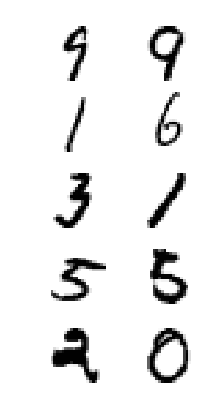

In [270]:
plt.figure(figsize=(3, 3 * batch_size))  # width, height
plt.subplot(121)
plt.imshow(X_batch[:,0].reshape(28 * batch_size, 28), cmap="binary", interpolation="nearest")
plt.axis('off')
plt.subplot(122)
plt.imshow(X_batch[:,1].reshape(28 * batch_size, 28), cmap="binary", interpolation="nearest")
plt.axis('off')
plt.show()

And let's look at the labels (0 means "different", 1 means "same"):

In [271]:
y_batch

array([[1],
       [0],
       [0],
       [1],
       [0]])

Perfect!

### 10.3.
_Exercise: train the DNN on this training set. For each image pair, you can simultaneously feed the first image to DNN A and the second image to DNN B. The whole network will gradually learn to tell whether two images belong to the same class or not._

Let's generate a test set composed of many pairs of images pulled from the MNIST test set:

In [272]:
X_test1, y_test1 = generate_batch(X_test, y_test, batch_size=len(X_test))

And now, let's train the model. There's really nothing special about this step, except for the fact that we need a fairly large `batch_size`, otherwise the model fails to learn anything and ends up with an accuracy of 50%:

In [273]:
n_epochs = 100
batch_size = 500

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(len(X_train1) // batch_size):
            X_batch, y_batch = generate_batch(X_train1, y_train1, batch_size)
            loss_val, _ = sess.run([loss, training_op], feed_dict={X: X_batch, y: y_batch})
        print(epoch, "Train loss:", loss_val)
        if epoch % 5 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test1, y: y_test1})
            print(epoch, "Test accuracy:", acc_test)

    save_path = saver.save(sess, "./my_digit_comparison_model.ckpt")

0 Train loss: 0.69236004
0 Test accuracy: 0.5031
1 Train loss: 0.6937517
2 Train loss: 0.6889615
3 Train loss: 0.62794894
4 Train loss: 0.52220035
5 Train loss: 0.5394396
5 Test accuracy: 0.7317
6 Train loss: 0.5403051
7 Train loss: 0.4539397
8 Train loss: 0.4506486
9 Train loss: 0.46825844
10 Train loss: 0.35033748
10 Test accuracy: 0.8226
11 Train loss: 0.41334057
12 Train loss: 0.3694389
13 Train loss: 0.3761535
14 Train loss: 0.32001552
15 Train loss: 0.32761735
15 Test accuracy: 0.8599
16 Train loss: 0.31543645
17 Train loss: 0.3408298
18 Train loss: 0.28993767
19 Train loss: 0.30727524
20 Train loss: 0.35425156
20 Test accuracy: 0.8762
21 Train loss: 0.23173125
22 Train loss: 0.29069817
23 Train loss: 0.24736324
24 Train loss: 0.26694354
25 Train loss: 0.23917961
25 Test accuracy: 0.8854
26 Train loss: 0.2561812
27 Train loss: 0.30616868
28 Train loss: 0.2619913
29 Train loss: 0.25882086
30 Train loss: 0.26606965
30 Test accuracy: 0.8996
31 Train loss: 0.26256472
32 Train loss: 0

All right, we reach 97.6% accuracy on this digit comparison task. That's not too bad, this model knows a thing or two about comparing handwritten digits!

Let's see if some of that knowledge can be useful for the regular MNIST classification task.

### 10.4.
_Exercise: now create a new DNN by reusing and freezing the hidden layers of DNN A and adding a softmax output layer on top with 10 neurons. Train this network on split #2 and see if you can achieve high performance despite having only 500 images per class._

Let's create the model, it is pretty straightforward. There are many ways to freeze the lower layers, as explained in the book. In this example, we chose to use the `tf.stop_gradient()` function. Note that we need one `Saver` to restore the pretrained DNN A, and another `Saver` to save the final model: 

In [274]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

dnn_outputs = dnn(X, name="DNN_A")
frozen_outputs = tf.stop_gradient(dnn_outputs)

logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init)
Y_proba = tf.nn.softmax(logits)

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

dnn_A_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="DNN_A")
restore_saver = tf.train.Saver(var_list={var.op.name: var for var in dnn_A_vars})
saver = tf.train.Saver()

Now on to training! We first initialize all variables (including the variables in the new output layer), then we restore the pretrained DNN A. Next, we just train the model on the small MNIST dataset (containing just 5,000 images):

In [275]:
n_epochs = 100
batch_size = 50

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_digit_comparison_model.ckpt")

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 10 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
            print(epoch, "Test accuracy:", acc_test)

    save_path = saver.save(sess, "./my_mnist_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_digit_comparison_model.ckpt
0 Test accuracy: 0.9308
10 Test accuracy: 0.9603
20 Test accuracy: 0.963
30 Test accuracy: 0.9632
40 Test accuracy: 0.9632
50 Test accuracy: 0.9633
60 Test accuracy: 0.9631
70 Test accuracy: 0.9634
80 Test accuracy: 0.9633
90 Test accuracy: 0.9633


Well, 96.7% accuracy, that's not the best MNIST model we have trained so far, but recall that we are only using a small training set (just 500 images per digit). Let's compare this result with the same DNN trained from scratch, without using transfer learning:

In [276]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

dnn_outputs = dnn(X, name="DNN_A")

logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init)
Y_proba = tf.nn.softmax(logits)

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

dnn_A_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="DNN_A")
restore_saver = tf.train.Saver(var_list={var.op.name: var for var in dnn_A_vars})
saver = tf.train.Saver()

In [277]:
n_epochs = 150
batch_size = 50

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 10 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
            print(epoch, "Test accuracy:", acc_test)

    save_path = saver.save(sess, "./my_mnist_model_final.ckpt")

0 Test accuracy: 0.8623
10 Test accuracy: 0.9184
20 Test accuracy: 0.9381
30 Test accuracy: 0.9403
40 Test accuracy: 0.9403
50 Test accuracy: 0.941
60 Test accuracy: 0.9405
70 Test accuracy: 0.9408
80 Test accuracy: 0.9407
90 Test accuracy: 0.9406
100 Test accuracy: 0.9407
110 Test accuracy: 0.9407
120 Test accuracy: 0.9409
130 Test accuracy: 0.9407
140 Test accuracy: 0.9406


Only 94.8% accuracy... So transfer learning helped us reduce the error rate from 5.2% to 3.3% (that's over 36% error reduction). Moreover, the model using transfer learning reached over 96% accuracy in less than 10 epochs.

Bottom line: transfer learning does not always work (as we saw in exercise 9), but when it does it can make a big difference. So try it out!